In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./eql1/trainy_eql1.csv")
valy = pd.read_csv("./eql1/valy_eql1.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype'])
with open("./eql1/label_encoder_eql1.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype']))
y_val = pd.DataFrame(le.transform(valy['celltype']))
np.save('./eql1/train_eql1_label.npy', y_train)
np.save('./eql1/val_eql1_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./eql1/checkpoint_model_eql1.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./eql1/acc.txt", "w") as f:
        with open("./eql1/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./eql1/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
num_classes = 31
batch_size = 128
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=31)
net._fc.out_features = num_classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./eql1/train_eql1.npy", "./eql1/train_eql1_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./eql1/val_eql1.npy", "./eql1/val_eql1_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9, weight_decay=1e-6)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 50,
                                                           early_patience = 20,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 3.454 | Accuracy: 1.562% 
[epoch:1, iter:2] Loss: 3.346 | Accuracy: 14.062% 
[epoch:1, iter:3] Loss: 3.256 | Accuracy: 21.615% 
[epoch:1, iter:4] Loss: 3.181 | Accuracy: 25.000% 
[epoch:1, iter:5] Loss: 3.100 | Accuracy: 28.906% 
[epoch:1, iter:6] Loss: 3.023 | Accuracy: 30.990% 
[epoch:1, iter:7] Loss: 2.933 | Accuracy: 34.152% 
[epoch:1, iter:8] Loss: 2.864 | Accuracy: 36.035% 
[epoch:1, iter:9] Loss: 2.808 | Accuracy: 36.892% 
[epoch:1, iter:10] Loss: 2.764 | Accuracy: 37.266% 
[epoch:1, iter:11] Loss: 2.706 | Accuracy: 38.991% 
[epoch:1, iter:12] Loss: 2.643 | Accuracy: 40.365% 
[epoch:1, iter:13] Loss: 2.601 | Accuracy: 40.865% 
[epoch:1, iter:14] Loss: 2.559 | Accuracy: 41.741% 
[epoch:1, iter:15] Loss: 2.510 | Accuracy: 43.125% 
[epoch:1, iter:16] Loss: 2.462 | Accuracy: 44.141% 
[epoch:1, iter:17] Loss: 2.414 | Accuracy: 45.404% 
[epoch:1, iter:18] Loss: 2.375 | Accuracy: 46.224% 
[epoch:1, iter:19] Loss: 2.342 | Accuracy: 46.998% 
[epoch:1, it

[epoch:1, iter:158] Loss: 1.291 | Accuracy: 77.368% 
[epoch:1, iter:159] Loss: 1.290 | Accuracy: 77.398% 
[epoch:1, iter:160] Loss: 1.289 | Accuracy: 77.466% 
[epoch:1, iter:161] Loss: 1.287 | Accuracy: 77.533% 
[epoch:1, iter:162] Loss: 1.285 | Accuracy: 77.599% 
[epoch:1, iter:163] Loss: 1.282 | Accuracy: 77.684% 
[epoch:1, iter:164] Loss: 1.281 | Accuracy: 77.749% 
[epoch:1, iter:165] Loss: 1.279 | Accuracy: 77.817% 
[epoch:1, iter:166] Loss: 1.276 | Accuracy: 77.899% 
[epoch:1, iter:167] Loss: 1.275 | Accuracy: 77.961% 
[epoch:1, iter:168] Loss: 1.273 | Accuracy: 78.027% 
[epoch:1, iter:169] Loss: 1.271 | Accuracy: 78.102% 
[epoch:1, iter:170] Loss: 1.269 | Accuracy: 78.166% 
[epoch:1, iter:171] Loss: 1.268 | Accuracy: 78.180% 
[epoch:1, iter:172] Loss: 1.266 | Accuracy: 78.257% 
[epoch:1, iter:173] Loss: 1.265 | Accuracy: 78.328% 
[epoch:1, iter:174] Loss: 1.263 | Accuracy: 78.363% 
[epoch:1, iter:175] Loss: 1.262 | Accuracy: 78.406% 
[epoch:1, iter:176] Loss: 1.260 | Accuracy: 78

[epoch:1, iter:313] Loss: 1.132 | Accuracy: 82.570% 
[epoch:1, iter:314] Loss: 1.131 | Accuracy: 82.589% 
[epoch:1, iter:315] Loss: 1.130 | Accuracy: 82.614% 
[epoch:1, iter:316] Loss: 1.130 | Accuracy: 82.632% 
[epoch:1, iter:317] Loss: 1.129 | Accuracy: 82.655% 
[epoch:1, iter:318] Loss: 1.128 | Accuracy: 82.672% 
[epoch:1, iter:319] Loss: 1.128 | Accuracy: 82.692% 
[epoch:1, iter:320] Loss: 1.127 | Accuracy: 82.710% 
[epoch:1, iter:321] Loss: 1.126 | Accuracy: 82.742% 
[epoch:1, iter:322] Loss: 1.125 | Accuracy: 82.769% 
[epoch:1, iter:323] Loss: 1.125 | Accuracy: 82.793% 
[epoch:1, iter:324] Loss: 1.125 | Accuracy: 82.798% 
[epoch:1, iter:325] Loss: 1.124 | Accuracy: 82.815% 
[epoch:1, iter:326] Loss: 1.124 | Accuracy: 82.820% 
[epoch:1, iter:327] Loss: 1.123 | Accuracy: 82.858% 
[epoch:1, iter:328] Loss: 1.123 | Accuracy: 82.860% 
[epoch:1, iter:329] Loss: 1.122 | Accuracy: 82.874% 
[epoch:1, iter:330] Loss: 1.121 | Accuracy: 82.910% 
[epoch:1, iter:331] Loss: 1.121 | Accuracy: 82

[epoch:1, iter:468] Loss: 1.060 | Accuracy: 84.938% 
[epoch:1, iter:469] Loss: 1.060 | Accuracy: 84.948% 
[epoch:1, iter:470] Loss: 1.059 | Accuracy: 84.962% 
[epoch:1, iter:471] Loss: 1.059 | Accuracy: 84.977% 
[epoch:1, iter:472] Loss: 1.059 | Accuracy: 84.984% 
[epoch:1, iter:473] Loss: 1.058 | Accuracy: 84.996% 
[epoch:1, iter:474] Loss: 1.058 | Accuracy: 85.000% 
[epoch:1, iter:475] Loss: 1.058 | Accuracy: 85.013% 
[epoch:1, iter:476] Loss: 1.057 | Accuracy: 85.022% 
[epoch:1, iter:477] Loss: 1.057 | Accuracy: 85.040% 
[epoch:1, iter:478] Loss: 1.056 | Accuracy: 85.052% 
[epoch:1, iter:479] Loss: 1.056 | Accuracy: 85.065% 
[epoch:1, iter:480] Loss: 1.056 | Accuracy: 85.081% 
[epoch:1, iter:481] Loss: 1.055 | Accuracy: 85.086% 
[epoch:1, iter:482] Loss: 1.055 | Accuracy: 85.098% 
[epoch:1, iter:483] Loss: 1.055 | Accuracy: 85.111% 
[epoch:1, iter:484] Loss: 1.054 | Accuracy: 85.129% 
[epoch:1, iter:485] Loss: 1.054 | Accuracy: 85.145% 
[epoch:1, iter:486] Loss: 1.054 | Accuracy: 85

[epoch:1, iter:623] Loss: 1.015 | Accuracy: 86.542% 
[epoch:1, iter:624] Loss: 1.014 | Accuracy: 86.550% 
[epoch:1, iter:625] Loss: 1.014 | Accuracy: 86.561% 
[epoch:1, iter:626] Loss: 1.014 | Accuracy: 86.570% 
[epoch:1, iter:627] Loss: 1.014 | Accuracy: 86.582% 
[epoch:1, iter:628] Loss: 1.013 | Accuracy: 86.589% 
[epoch:1, iter:629] Loss: 1.013 | Accuracy: 86.606% 
[epoch:1, iter:630] Loss: 1.013 | Accuracy: 86.617% 
[epoch:1, iter:631] Loss: 1.012 | Accuracy: 86.626% 
[epoch:1, iter:632] Loss: 1.012 | Accuracy: 86.637% 
[epoch:1, iter:633] Loss: 1.012 | Accuracy: 86.636% 
[epoch:1, iter:634] Loss: 1.012 | Accuracy: 86.636% 
[epoch:1, iter:635] Loss: 1.012 | Accuracy: 86.649% 
[epoch:1, iter:636] Loss: 1.012 | Accuracy: 86.656% 
[epoch:1, iter:637] Loss: 1.012 | Accuracy: 86.662% 
[epoch:1, iter:638] Loss: 1.011 | Accuracy: 86.671% 
[epoch:1, iter:639] Loss: 1.011 | Accuracy: 86.680% 
[epoch:1, iter:640] Loss: 1.011 | Accuracy: 86.686% 
[epoch:1, iter:641] Loss: 1.011 | Accuracy: 86

[epoch:1, iter:778] Loss: 0.986 | Accuracy: 87.508% 
[epoch:1, iter:779] Loss: 0.986 | Accuracy: 87.517% 
[epoch:1, iter:780] Loss: 0.986 | Accuracy: 87.521% 
[epoch:1, iter:781] Loss: 0.986 | Accuracy: 87.530% 
[epoch:1, iter:782] Loss: 0.985 | Accuracy: 87.537% 
[epoch:1, iter:783] Loss: 0.985 | Accuracy: 87.547% 
[epoch:1, iter:784] Loss: 0.985 | Accuracy: 87.553% 
[epoch:1, iter:785] Loss: 0.985 | Accuracy: 87.561% 
[epoch:1, iter:786] Loss: 0.985 | Accuracy: 87.564% 
[epoch:1, iter:787] Loss: 0.985 | Accuracy: 87.569% 
[epoch:1, iter:788] Loss: 0.984 | Accuracy: 87.570% 
[epoch:1, iter:789] Loss: 0.984 | Accuracy: 87.578% 
[epoch:1, iter:790] Loss: 0.984 | Accuracy: 87.579% 
[epoch:1, iter:791] Loss: 0.984 | Accuracy: 87.589% 
[epoch:1, iter:792] Loss: 0.984 | Accuracy: 87.595% 
[epoch:1, iter:793] Loss: 0.984 | Accuracy: 87.601% 
[epoch:1, iter:794] Loss: 0.983 | Accuracy: 87.609% 
[epoch:1, iter:795] Loss: 0.983 | Accuracy: 87.618% 
[epoch:1, iter:796] Loss: 0.983 | Accuracy: 87

[epoch:1, iter:933] Loss: 0.963 | Accuracy: 88.324% 
[epoch:1, iter:934] Loss: 0.963 | Accuracy: 88.327% 
[epoch:1, iter:935] Loss: 0.963 | Accuracy: 88.335% 
[epoch:1, iter:936] Loss: 0.963 | Accuracy: 88.339% 
[epoch:1, iter:937] Loss: 0.963 | Accuracy: 88.343% 
[epoch:1, iter:938] Loss: 0.962 | Accuracy: 88.345% 
[epoch:1, iter:939] Loss: 0.962 | Accuracy: 88.357% 
[epoch:1, iter:940] Loss: 0.962 | Accuracy: 88.361% 
[epoch:1, iter:941] Loss: 0.962 | Accuracy: 88.364% 
[epoch:1, iter:942] Loss: 0.962 | Accuracy: 88.370% 
[epoch:1, iter:943] Loss: 0.962 | Accuracy: 88.378% 
[epoch:1, iter:944] Loss: 0.961 | Accuracy: 88.383% 
[epoch:1, iter:945] Loss: 0.961 | Accuracy: 88.389% 
[epoch:1, iter:946] Loss: 0.961 | Accuracy: 88.394% 
[epoch:1, iter:947] Loss: 0.961 | Accuracy: 88.397% 
[epoch:1, iter:948] Loss: 0.961 | Accuracy: 88.402% 
[epoch:1, iter:949] Loss: 0.961 | Accuracy: 88.406% 
[epoch:1, iter:950] Loss: 0.961 | Accuracy: 88.414% 
[epoch:1, iter:951] Loss: 0.961 | Accuracy: 88

[epoch:2, iter:1083] Loss: 0.829 | Accuracy: 93.182% 
[epoch:2, iter:1084] Loss: 0.826 | Accuracy: 93.359% 
[epoch:2, iter:1085] Loss: 0.823 | Accuracy: 93.450% 
[epoch:2, iter:1086] Loss: 0.823 | Accuracy: 93.638% 
[epoch:2, iter:1087] Loss: 0.825 | Accuracy: 93.385% 
[epoch:2, iter:1088] Loss: 0.819 | Accuracy: 93.701% 
[epoch:2, iter:1089] Loss: 0.820 | Accuracy: 93.612% 
[epoch:2, iter:1090] Loss: 0.820 | Accuracy: 93.663% 
[epoch:2, iter:1091] Loss: 0.815 | Accuracy: 93.791% 
[epoch:2, iter:1092] Loss: 0.828 | Accuracy: 93.203% 
[epoch:2, iter:1093] Loss: 0.828 | Accuracy: 93.118% 
[epoch:2, iter:1094] Loss: 0.828 | Accuracy: 93.040% 
[epoch:2, iter:1095] Loss: 0.824 | Accuracy: 93.173% 
[epoch:2, iter:1096] Loss: 0.824 | Accuracy: 93.229% 
[epoch:2, iter:1097] Loss: 0.827 | Accuracy: 93.094% 
[epoch:2, iter:1098] Loss: 0.829 | Accuracy: 92.909% 
[epoch:2, iter:1099] Loss: 0.832 | Accuracy: 92.766% 
[epoch:2, iter:1100] Loss: 0.833 | Accuracy: 92.662% 
[epoch:2, iter:1101] Loss: 0

[epoch:2, iter:1235] Loss: 0.826 | Accuracy: 93.247% 
[epoch:2, iter:1236] Loss: 0.826 | Accuracy: 93.240% 
[epoch:2, iter:1237] Loss: 0.826 | Accuracy: 93.253% 
[epoch:2, iter:1238] Loss: 0.826 | Accuracy: 93.256% 
[epoch:2, iter:1239] Loss: 0.826 | Accuracy: 93.263% 
[epoch:2, iter:1240] Loss: 0.826 | Accuracy: 93.248% 
[epoch:2, iter:1241] Loss: 0.827 | Accuracy: 93.223% 
[epoch:2, iter:1242] Loss: 0.826 | Accuracy: 93.226% 
[epoch:2, iter:1243] Loss: 0.826 | Accuracy: 93.234% 
[epoch:2, iter:1244] Loss: 0.826 | Accuracy: 93.237% 
[epoch:2, iter:1245] Loss: 0.826 | Accuracy: 93.240% 
[epoch:2, iter:1246] Loss: 0.826 | Accuracy: 93.238% 
[epoch:2, iter:1247] Loss: 0.826 | Accuracy: 93.232% 
[epoch:2, iter:1248] Loss: 0.826 | Accuracy: 93.226% 
[epoch:2, iter:1249] Loss: 0.826 | Accuracy: 93.238% 
[epoch:2, iter:1250] Loss: 0.826 | Accuracy: 93.241% 
[epoch:2, iter:1251] Loss: 0.826 | Accuracy: 93.248% 
[epoch:2, iter:1252] Loss: 0.826 | Accuracy: 93.247% 
[epoch:2, iter:1253] Loss: 0

[epoch:2, iter:1387] Loss: 0.823 | Accuracy: 93.361% 
[epoch:2, iter:1388] Loss: 0.823 | Accuracy: 93.352% 
[epoch:2, iter:1389] Loss: 0.823 | Accuracy: 93.351% 
[epoch:2, iter:1390] Loss: 0.823 | Accuracy: 93.359% 
[epoch:2, iter:1391] Loss: 0.823 | Accuracy: 93.365% 
[epoch:2, iter:1392] Loss: 0.823 | Accuracy: 93.354% 
[epoch:2, iter:1393] Loss: 0.822 | Accuracy: 93.363% 
[epoch:2, iter:1394] Loss: 0.822 | Accuracy: 93.374% 
[epoch:2, iter:1395] Loss: 0.822 | Accuracy: 93.373% 
[epoch:2, iter:1396] Loss: 0.822 | Accuracy: 93.367% 
[epoch:2, iter:1397] Loss: 0.823 | Accuracy: 93.353% 
[epoch:2, iter:1398] Loss: 0.823 | Accuracy: 93.355% 
[epoch:2, iter:1399] Loss: 0.822 | Accuracy: 93.353% 
[epoch:2, iter:1400] Loss: 0.823 | Accuracy: 93.350% 
[epoch:2, iter:1401] Loss: 0.823 | Accuracy: 93.342% 
[epoch:2, iter:1402] Loss: 0.823 | Accuracy: 93.340% 
[epoch:2, iter:1403] Loss: 0.823 | Accuracy: 93.344% 
[epoch:2, iter:1404] Loss: 0.823 | Accuracy: 93.341% 
[epoch:2, iter:1405] Loss: 0

[epoch:2, iter:1539] Loss: 0.822 | Accuracy: 93.359% 
[epoch:2, iter:1540] Loss: 0.822 | Accuracy: 93.359% 
[epoch:2, iter:1541] Loss: 0.822 | Accuracy: 93.354% 
[epoch:2, iter:1542] Loss: 0.822 | Accuracy: 93.356% 
[epoch:2, iter:1543] Loss: 0.822 | Accuracy: 93.355% 
[epoch:2, iter:1544] Loss: 0.822 | Accuracy: 93.356% 
[epoch:2, iter:1545] Loss: 0.822 | Accuracy: 93.362% 
[epoch:2, iter:1546] Loss: 0.822 | Accuracy: 93.349% 
[epoch:2, iter:1547] Loss: 0.822 | Accuracy: 93.352% 
[epoch:2, iter:1548] Loss: 0.822 | Accuracy: 93.353% 
[epoch:2, iter:1549] Loss: 0.822 | Accuracy: 93.359% 
[epoch:2, iter:1550] Loss: 0.821 | Accuracy: 93.363% 
[epoch:2, iter:1551] Loss: 0.821 | Accuracy: 93.367% 
[epoch:2, iter:1552] Loss: 0.821 | Accuracy: 93.371% 
[epoch:2, iter:1553] Loss: 0.821 | Accuracy: 93.376% 
[epoch:2, iter:1554] Loss: 0.821 | Accuracy: 93.366% 
[epoch:2, iter:1555] Loss: 0.821 | Accuracy: 93.367% 
[epoch:2, iter:1556] Loss: 0.821 | Accuracy: 93.366% 
[epoch:2, iter:1557] Loss: 0

[epoch:2, iter:1691] Loss: 0.821 | Accuracy: 93.336% 
[epoch:2, iter:1692] Loss: 0.821 | Accuracy: 93.338% 
[epoch:2, iter:1693] Loss: 0.821 | Accuracy: 93.339% 
[epoch:2, iter:1694] Loss: 0.821 | Accuracy: 93.346% 
[epoch:2, iter:1695] Loss: 0.821 | Accuracy: 93.344% 
[epoch:2, iter:1696] Loss: 0.821 | Accuracy: 93.346% 
[epoch:2, iter:1697] Loss: 0.821 | Accuracy: 93.350% 
[epoch:2, iter:1698] Loss: 0.821 | Accuracy: 93.344% 
[epoch:2, iter:1699] Loss: 0.821 | Accuracy: 93.345% 
[epoch:2, iter:1700] Loss: 0.821 | Accuracy: 93.347% 
[epoch:2, iter:1701] Loss: 0.821 | Accuracy: 93.345% 
[epoch:2, iter:1702] Loss: 0.821 | Accuracy: 93.349% 
[epoch:2, iter:1703] Loss: 0.821 | Accuracy: 93.348% 
[epoch:2, iter:1704] Loss: 0.821 | Accuracy: 93.351% 
[epoch:2, iter:1705] Loss: 0.821 | Accuracy: 93.348% 
[epoch:2, iter:1706] Loss: 0.821 | Accuracy: 93.352% 
[epoch:2, iter:1707] Loss: 0.821 | Accuracy: 93.355% 
[epoch:2, iter:1708] Loss: 0.821 | Accuracy: 93.361% 
[epoch:2, iter:1709] Loss: 0

[epoch:2, iter:1843] Loss: 0.820 | Accuracy: 93.429% 
[epoch:2, iter:1844] Loss: 0.820 | Accuracy: 93.428% 
[epoch:2, iter:1845] Loss: 0.820 | Accuracy: 93.431% 
[epoch:2, iter:1846] Loss: 0.820 | Accuracy: 93.433% 
[epoch:2, iter:1847] Loss: 0.820 | Accuracy: 93.433% 
[epoch:2, iter:1848] Loss: 0.819 | Accuracy: 93.434% 
[epoch:2, iter:1849] Loss: 0.819 | Accuracy: 93.435% 
[epoch:2, iter:1850] Loss: 0.819 | Accuracy: 93.438% 
[epoch:2, iter:1851] Loss: 0.819 | Accuracy: 93.438% 
[epoch:2, iter:1852] Loss: 0.819 | Accuracy: 93.439% 
[epoch:2, iter:1853] Loss: 0.819 | Accuracy: 93.439% 
[epoch:2, iter:1854] Loss: 0.819 | Accuracy: 93.444% 
[epoch:2, iter:1855] Loss: 0.819 | Accuracy: 93.446% 
[epoch:2, iter:1856] Loss: 0.819 | Accuracy: 93.444% 
[epoch:2, iter:1857] Loss: 0.819 | Accuracy: 93.444% 
[epoch:2, iter:1858] Loss: 0.819 | Accuracy: 93.446% 
[epoch:2, iter:1859] Loss: 0.819 | Accuracy: 93.443% 
[epoch:2, iter:1860] Loss: 0.819 | Accuracy: 93.449% 
[epoch:2, iter:1861] Loss: 0

[epoch:2, iter:1995] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:1996] Loss: 0.817 | Accuracy: 93.519% 
[epoch:2, iter:1997] Loss: 0.817 | Accuracy: 93.521% 
[epoch:2, iter:1998] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:1999] Loss: 0.817 | Accuracy: 93.516% 
[epoch:2, iter:2000] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:2001] Loss: 0.817 | Accuracy: 93.520% 
[epoch:2, iter:2002] Loss: 0.817 | Accuracy: 93.522% 
[epoch:2, iter:2003] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:2004] Loss: 0.817 | Accuracy: 93.516% 
[epoch:2, iter:2005] Loss: 0.817 | Accuracy: 93.516% 
[epoch:2, iter:2006] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:2007] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:2008] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:2009] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:2010] Loss: 0.817 | Accuracy: 93.513% 
[epoch:2, iter:2011] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:2012] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:2013] Loss: 0


Epoch: 3
[epoch:3, iter:2145] Loss: 0.759 | Accuracy: 96.094% 
[epoch:3, iter:2146] Loss: 0.772 | Accuracy: 94.922% 
[epoch:3, iter:2147] Loss: 0.783 | Accuracy: 95.052% 
[epoch:3, iter:2148] Loss: 0.764 | Accuracy: 95.703% 
[epoch:3, iter:2149] Loss: 0.766 | Accuracy: 95.625% 
[epoch:3, iter:2150] Loss: 0.763 | Accuracy: 95.964% 
[epoch:3, iter:2151] Loss: 0.757 | Accuracy: 96.205% 
[epoch:3, iter:2152] Loss: 0.752 | Accuracy: 96.582% 
[epoch:3, iter:2153] Loss: 0.754 | Accuracy: 96.528% 
[epoch:3, iter:2154] Loss: 0.757 | Accuracy: 96.484% 
[epoch:3, iter:2155] Loss: 0.754 | Accuracy: 96.520% 
[epoch:3, iter:2156] Loss: 0.757 | Accuracy: 96.354% 
[epoch:3, iter:2157] Loss: 0.762 | Accuracy: 96.274% 
[epoch:3, iter:2158] Loss: 0.765 | Accuracy: 96.205% 
[epoch:3, iter:2159] Loss: 0.766 | Accuracy: 95.938% 
[epoch:3, iter:2160] Loss: 0.764 | Accuracy: 96.094% 
[epoch:3, iter:2161] Loss: 0.768 | Accuracy: 95.956% 
[epoch:3, iter:2162] Loss: 0.770 | Accuracy: 95.877% 
[epoch:3, iter:216

[epoch:3, iter:2297] Loss: 0.791 | Accuracy: 94.547% 
[epoch:3, iter:2298] Loss: 0.791 | Accuracy: 94.546% 
[epoch:3, iter:2299] Loss: 0.791 | Accuracy: 94.556% 
[epoch:3, iter:2300] Loss: 0.791 | Accuracy: 94.556% 
[epoch:3, iter:2301] Loss: 0.791 | Accuracy: 94.561% 
[epoch:3, iter:2302] Loss: 0.791 | Accuracy: 94.566% 
[epoch:3, iter:2303] Loss: 0.791 | Accuracy: 94.566% 
[epoch:3, iter:2304] Loss: 0.791 | Accuracy: 94.556% 
[epoch:3, iter:2305] Loss: 0.791 | Accuracy: 94.565% 
[epoch:3, iter:2306] Loss: 0.791 | Accuracy: 94.555% 
[epoch:3, iter:2307] Loss: 0.790 | Accuracy: 94.574% 
[epoch:3, iter:2308] Loss: 0.791 | Accuracy: 94.579% 
[epoch:3, iter:2309] Loss: 0.790 | Accuracy: 94.579% 
[epoch:3, iter:2310] Loss: 0.790 | Accuracy: 94.578% 
[epoch:3, iter:2311] Loss: 0.790 | Accuracy: 94.597% 
[epoch:3, iter:2312] Loss: 0.790 | Accuracy: 94.606% 
[epoch:3, iter:2313] Loss: 0.790 | Accuracy: 94.587% 
[epoch:3, iter:2314] Loss: 0.791 | Accuracy: 94.559% 
[epoch:3, iter:2315] Loss: 0

[epoch:3, iter:2449] Loss: 0.790 | Accuracy: 94.529% 
[epoch:3, iter:2450] Loss: 0.790 | Accuracy: 94.531% 
[epoch:3, iter:2451] Loss: 0.790 | Accuracy: 94.516% 
[epoch:3, iter:2452] Loss: 0.790 | Accuracy: 94.513% 
[epoch:3, iter:2453] Loss: 0.790 | Accuracy: 94.521% 
[epoch:3, iter:2454] Loss: 0.790 | Accuracy: 94.519% 
[epoch:3, iter:2455] Loss: 0.790 | Accuracy: 94.511% 
[epoch:3, iter:2456] Loss: 0.790 | Accuracy: 94.521% 
[epoch:3, iter:2457] Loss: 0.790 | Accuracy: 94.529% 
[epoch:3, iter:2458] Loss: 0.790 | Accuracy: 94.531% 
[epoch:3, iter:2459] Loss: 0.790 | Accuracy: 94.531% 
[epoch:3, iter:2460] Loss: 0.790 | Accuracy: 94.536% 
[epoch:3, iter:2461] Loss: 0.790 | Accuracy: 94.531% 
[epoch:3, iter:2462] Loss: 0.790 | Accuracy: 94.531% 
[epoch:3, iter:2463] Loss: 0.790 | Accuracy: 94.536% 
[epoch:3, iter:2464] Loss: 0.790 | Accuracy: 94.534% 
[epoch:3, iter:2465] Loss: 0.790 | Accuracy: 94.529% 
[epoch:3, iter:2466] Loss: 0.790 | Accuracy: 94.524% 
[epoch:3, iter:2467] Loss: 0

[epoch:3, iter:2601] Loss: 0.793 | Accuracy: 94.475% 
[epoch:3, iter:2602] Loss: 0.793 | Accuracy: 94.475% 
[epoch:3, iter:2603] Loss: 0.793 | Accuracy: 94.480% 
[epoch:3, iter:2604] Loss: 0.793 | Accuracy: 94.472% 
[epoch:3, iter:2605] Loss: 0.792 | Accuracy: 94.480% 
[epoch:3, iter:2606] Loss: 0.792 | Accuracy: 94.484% 
[epoch:3, iter:2607] Loss: 0.792 | Accuracy: 94.486% 
[epoch:3, iter:2608] Loss: 0.792 | Accuracy: 94.493% 
[epoch:3, iter:2609] Loss: 0.792 | Accuracy: 94.499% 
[epoch:3, iter:2610] Loss: 0.792 | Accuracy: 94.496% 
[epoch:3, iter:2611] Loss: 0.792 | Accuracy: 94.498% 
[epoch:3, iter:2612] Loss: 0.792 | Accuracy: 94.496% 
[epoch:3, iter:2613] Loss: 0.792 | Accuracy: 94.496% 
[epoch:3, iter:2614] Loss: 0.792 | Accuracy: 94.498% 
[epoch:3, iter:2615] Loss: 0.792 | Accuracy: 94.505% 
[epoch:3, iter:2616] Loss: 0.792 | Accuracy: 94.505% 
[epoch:3, iter:2617] Loss: 0.792 | Accuracy: 94.508% 
[epoch:3, iter:2618] Loss: 0.792 | Accuracy: 94.515% 
[epoch:3, iter:2619] Loss: 0

[epoch:3, iter:2753] Loss: 0.792 | Accuracy: 94.483% 
[epoch:3, iter:2754] Loss: 0.792 | Accuracy: 94.481% 
[epoch:3, iter:2755] Loss: 0.792 | Accuracy: 94.481% 
[epoch:3, iter:2756] Loss: 0.792 | Accuracy: 94.475% 
[epoch:3, iter:2757] Loss: 0.792 | Accuracy: 94.476% 
[epoch:3, iter:2758] Loss: 0.792 | Accuracy: 94.471% 
[epoch:3, iter:2759] Loss: 0.792 | Accuracy: 94.473% 
[epoch:3, iter:2760] Loss: 0.792 | Accuracy: 94.473% 
[epoch:3, iter:2761] Loss: 0.792 | Accuracy: 94.470% 
[epoch:3, iter:2762] Loss: 0.792 | Accuracy: 94.466% 
[epoch:3, iter:2763] Loss: 0.792 | Accuracy: 94.464% 
[epoch:3, iter:2764] Loss: 0.792 | Accuracy: 94.464% 
[epoch:3, iter:2765] Loss: 0.792 | Accuracy: 94.471% 
[epoch:3, iter:2766] Loss: 0.792 | Accuracy: 94.472% 
[epoch:3, iter:2767] Loss: 0.792 | Accuracy: 94.474% 
[epoch:3, iter:2768] Loss: 0.792 | Accuracy: 94.477% 
[epoch:3, iter:2769] Loss: 0.792 | Accuracy: 94.478% 
[epoch:3, iter:2770] Loss: 0.792 | Accuracy: 94.475% 
[epoch:3, iter:2771] Loss: 0

[epoch:3, iter:2905] Loss: 0.792 | Accuracy: 94.456% 
[epoch:3, iter:2906] Loss: 0.792 | Accuracy: 94.454% 
[epoch:3, iter:2907] Loss: 0.792 | Accuracy: 94.458% 
[epoch:3, iter:2908] Loss: 0.792 | Accuracy: 94.456% 
[epoch:3, iter:2909] Loss: 0.792 | Accuracy: 94.457% 
[epoch:3, iter:2910] Loss: 0.792 | Accuracy: 94.458% 
[epoch:3, iter:2911] Loss: 0.792 | Accuracy: 94.455% 
[epoch:3, iter:2912] Loss: 0.792 | Accuracy: 94.453% 
[epoch:3, iter:2913] Loss: 0.792 | Accuracy: 94.450% 
[epoch:3, iter:2914] Loss: 0.792 | Accuracy: 94.448% 
[epoch:3, iter:2915] Loss: 0.792 | Accuracy: 94.446% 
[epoch:3, iter:2916] Loss: 0.792 | Accuracy: 94.444% 
[epoch:3, iter:2917] Loss: 0.792 | Accuracy: 94.442% 
[epoch:3, iter:2918] Loss: 0.792 | Accuracy: 94.438% 
[epoch:3, iter:2919] Loss: 0.792 | Accuracy: 94.438% 
[epoch:3, iter:2920] Loss: 0.793 | Accuracy: 94.435% 
[epoch:3, iter:2921] Loss: 0.792 | Accuracy: 94.438% 
[epoch:3, iter:2922] Loss: 0.792 | Accuracy: 94.440% 
[epoch:3, iter:2923] Loss: 0

[epoch:3, iter:3057] Loss: 0.793 | Accuracy: 94.418% 
[epoch:3, iter:3058] Loss: 0.793 | Accuracy: 94.418% 
[epoch:3, iter:3059] Loss: 0.793 | Accuracy: 94.419% 
[epoch:3, iter:3060] Loss: 0.793 | Accuracy: 94.417% 
[epoch:3, iter:3061] Loss: 0.793 | Accuracy: 94.417% 
[epoch:3, iter:3062] Loss: 0.793 | Accuracy: 94.418% 
[epoch:3, iter:3063] Loss: 0.793 | Accuracy: 94.420% 
[epoch:3, iter:3064] Loss: 0.793 | Accuracy: 94.420% 
[epoch:3, iter:3065] Loss: 0.793 | Accuracy: 94.419% 
[epoch:3, iter:3066] Loss: 0.793 | Accuracy: 94.421% 
[epoch:3, iter:3067] Loss: 0.793 | Accuracy: 94.419% 
[epoch:3, iter:3068] Loss: 0.793 | Accuracy: 94.421% 
[epoch:3, iter:3069] Loss: 0.793 | Accuracy: 94.422% 
[epoch:3, iter:3070] Loss: 0.793 | Accuracy: 94.422% 
[epoch:3, iter:3071] Loss: 0.793 | Accuracy: 94.423% 
[epoch:3, iter:3072] Loss: 0.793 | Accuracy: 94.423% 
[epoch:3, iter:3073] Loss: 0.793 | Accuracy: 94.419% 
[epoch:3, iter:3074] Loss: 0.793 | Accuracy: 94.417% 
[epoch:3, iter:3075] Loss: 0

[epoch:3, iter:3209] Loss: 0.793 | Accuracy: 94.408% 
[epoch:3, iter:3210] Loss: 0.793 | Accuracy: 94.405% 
[epoch:3, iter:3211] Loss: 0.793 | Accuracy: 94.405% 
[epoch:3, iter:3212] Loss: 0.793 | Accuracy: 94.403% 
[epoch:3, iter:3213] Loss: 0.793 | Accuracy: 94.403% 
[epoch:3, iter:3214] Loss: 0.793 | Accuracy: 94.406% 
[epoch:3, iter:3215] Loss: 0.793 | Accuracy: 94.401% 
[epoch:3, iter:3216] Loss: 0.793 | Accuracy: 94.402% 
Waiting Test!
EPOCH=003, Loss: 0.842, Accuracy= 92.068%
Training complete in 9m 11s
EarlyStopping counter: 1 out of 20

Epoch: 4
[epoch:4, iter:3217] Loss: 0.816 | Accuracy: 92.969% 
[epoch:4, iter:3218] Loss: 0.784 | Accuracy: 94.141% 
[epoch:4, iter:3219] Loss: 0.792 | Accuracy: 94.010% 
[epoch:4, iter:3220] Loss: 0.793 | Accuracy: 94.141% 
[epoch:4, iter:3221] Loss: 0.798 | Accuracy: 94.375% 
[epoch:4, iter:3222] Loss: 0.789 | Accuracy: 94.792% 
[epoch:4, iter:3223] Loss: 0.796 | Accuracy: 94.196% 
[epoch:4, iter:3224] Loss: 0.799 | Accuracy: 94.238% 
[epoch:

[epoch:4, iter:3359] Loss: 0.781 | Accuracy: 94.957% 
[epoch:4, iter:3360] Loss: 0.781 | Accuracy: 94.949% 
[epoch:4, iter:3361] Loss: 0.781 | Accuracy: 94.957% 
[epoch:4, iter:3362] Loss: 0.781 | Accuracy: 94.959% 
[epoch:4, iter:3363] Loss: 0.781 | Accuracy: 94.983% 
[epoch:4, iter:3364] Loss: 0.781 | Accuracy: 94.990% 
[epoch:4, iter:3365] Loss: 0.781 | Accuracy: 94.982% 
[epoch:4, iter:3366] Loss: 0.781 | Accuracy: 94.974% 
[epoch:4, iter:3367] Loss: 0.781 | Accuracy: 94.987% 
[epoch:4, iter:3368] Loss: 0.781 | Accuracy: 94.999% 
[epoch:4, iter:3369] Loss: 0.781 | Accuracy: 95.001% 
[epoch:4, iter:3370] Loss: 0.780 | Accuracy: 95.008% 
[epoch:4, iter:3371] Loss: 0.780 | Accuracy: 94.990% 
[epoch:4, iter:3372] Loss: 0.780 | Accuracy: 94.997% 
[epoch:4, iter:3373] Loss: 0.780 | Accuracy: 94.989% 
[epoch:4, iter:3374] Loss: 0.780 | Accuracy: 94.996% 
[epoch:4, iter:3375] Loss: 0.780 | Accuracy: 94.993% 
[epoch:4, iter:3376] Loss: 0.780 | Accuracy: 94.990% 
[epoch:4, iter:3377] Loss: 0

[epoch:4, iter:3511] Loss: 0.781 | Accuracy: 94.891% 
[epoch:4, iter:3512] Loss: 0.781 | Accuracy: 94.888% 
[epoch:4, iter:3513] Loss: 0.782 | Accuracy: 94.878% 
[epoch:4, iter:3514] Loss: 0.782 | Accuracy: 94.867% 
[epoch:4, iter:3515] Loss: 0.782 | Accuracy: 94.868% 
[epoch:4, iter:3516] Loss: 0.782 | Accuracy: 94.859% 
[epoch:4, iter:3517] Loss: 0.782 | Accuracy: 94.858% 
[epoch:4, iter:3518] Loss: 0.782 | Accuracy: 94.855% 
[epoch:4, iter:3519] Loss: 0.782 | Accuracy: 94.854% 
[epoch:4, iter:3520] Loss: 0.782 | Accuracy: 94.852% 
[epoch:4, iter:3521] Loss: 0.782 | Accuracy: 94.851% 
[epoch:4, iter:3522] Loss: 0.782 | Accuracy: 94.843% 
[epoch:4, iter:3523] Loss: 0.782 | Accuracy: 94.837% 
[epoch:4, iter:3524] Loss: 0.782 | Accuracy: 94.841% 
[epoch:4, iter:3525] Loss: 0.782 | Accuracy: 94.837% 
[epoch:4, iter:3526] Loss: 0.782 | Accuracy: 94.839% 
[epoch:4, iter:3527] Loss: 0.782 | Accuracy: 94.838% 
[epoch:4, iter:3528] Loss: 0.782 | Accuracy: 94.829% 
[epoch:4, iter:3529] Loss: 0

[epoch:4, iter:3663] Loss: 0.781 | Accuracy: 94.890% 
[epoch:4, iter:3664] Loss: 0.781 | Accuracy: 94.894% 
[epoch:4, iter:3665] Loss: 0.781 | Accuracy: 94.897% 
[epoch:4, iter:3666] Loss: 0.781 | Accuracy: 94.899% 
[epoch:4, iter:3667] Loss: 0.781 | Accuracy: 94.900% 
[epoch:4, iter:3668] Loss: 0.781 | Accuracy: 94.905% 
[epoch:4, iter:3669] Loss: 0.780 | Accuracy: 94.907% 
[epoch:4, iter:3670] Loss: 0.780 | Accuracy: 94.910% 
[epoch:4, iter:3671] Loss: 0.780 | Accuracy: 94.909% 
[epoch:4, iter:3672] Loss: 0.780 | Accuracy: 94.912% 
[epoch:4, iter:3673] Loss: 0.780 | Accuracy: 94.909% 
[epoch:4, iter:3674] Loss: 0.780 | Accuracy: 94.910% 
[epoch:4, iter:3675] Loss: 0.781 | Accuracy: 94.901% 
[epoch:4, iter:3676] Loss: 0.781 | Accuracy: 94.901% 
[epoch:4, iter:3677] Loss: 0.780 | Accuracy: 94.902% 
[epoch:4, iter:3678] Loss: 0.780 | Accuracy: 94.902% 
[epoch:4, iter:3679] Loss: 0.781 | Accuracy: 94.886% 
[epoch:4, iter:3680] Loss: 0.781 | Accuracy: 94.887% 
[epoch:4, iter:3681] Loss: 0

[epoch:4, iter:3815] Loss: 0.779 | Accuracy: 94.960% 
[epoch:4, iter:3816] Loss: 0.779 | Accuracy: 94.961% 
[epoch:4, iter:3817] Loss: 0.779 | Accuracy: 94.962% 
[epoch:4, iter:3818] Loss: 0.779 | Accuracy: 94.961% 
[epoch:4, iter:3819] Loss: 0.779 | Accuracy: 94.965% 
[epoch:4, iter:3820] Loss: 0.779 | Accuracy: 94.967% 
[epoch:4, iter:3821] Loss: 0.779 | Accuracy: 94.972% 
[epoch:4, iter:3822] Loss: 0.779 | Accuracy: 94.973% 
[epoch:4, iter:3823] Loss: 0.779 | Accuracy: 94.970% 
[epoch:4, iter:3824] Loss: 0.779 | Accuracy: 94.966% 
[epoch:4, iter:3825] Loss: 0.779 | Accuracy: 94.964% 
[epoch:4, iter:3826] Loss: 0.779 | Accuracy: 94.968% 
[epoch:4, iter:3827] Loss: 0.779 | Accuracy: 94.966% 
[epoch:4, iter:3828] Loss: 0.779 | Accuracy: 94.968% 
[epoch:4, iter:3829] Loss: 0.779 | Accuracy: 94.968% 
[epoch:4, iter:3830] Loss: 0.779 | Accuracy: 94.968% 
[epoch:4, iter:3831] Loss: 0.779 | Accuracy: 94.972% 
[epoch:4, iter:3832] Loss: 0.779 | Accuracy: 94.973% 
[epoch:4, iter:3833] Loss: 0

[epoch:4, iter:3967] Loss: 0.778 | Accuracy: 94.952% 
[epoch:4, iter:3968] Loss: 0.778 | Accuracy: 94.953% 
[epoch:4, iter:3969] Loss: 0.778 | Accuracy: 94.951% 
[epoch:4, iter:3970] Loss: 0.778 | Accuracy: 94.954% 
[epoch:4, iter:3971] Loss: 0.778 | Accuracy: 94.954% 
[epoch:4, iter:3972] Loss: 0.778 | Accuracy: 94.955% 
[epoch:4, iter:3973] Loss: 0.778 | Accuracy: 94.950% 
[epoch:4, iter:3974] Loss: 0.778 | Accuracy: 94.947% 
[epoch:4, iter:3975] Loss: 0.778 | Accuracy: 94.947% 
[epoch:4, iter:3976] Loss: 0.778 | Accuracy: 94.946% 
[epoch:4, iter:3977] Loss: 0.778 | Accuracy: 94.949% 
[epoch:4, iter:3978] Loss: 0.778 | Accuracy: 94.953% 
[epoch:4, iter:3979] Loss: 0.778 | Accuracy: 94.949% 
[epoch:4, iter:3980] Loss: 0.778 | Accuracy: 94.951% 
[epoch:4, iter:3981] Loss: 0.778 | Accuracy: 94.954% 
[epoch:4, iter:3982] Loss: 0.778 | Accuracy: 94.953% 
[epoch:4, iter:3983] Loss: 0.778 | Accuracy: 94.956% 
[epoch:4, iter:3984] Loss: 0.778 | Accuracy: 94.950% 
[epoch:4, iter:3985] Loss: 0

[epoch:4, iter:4119] Loss: 0.779 | Accuracy: 94.931% 
[epoch:4, iter:4120] Loss: 0.779 | Accuracy: 94.934% 
[epoch:4, iter:4121] Loss: 0.779 | Accuracy: 94.932% 
[epoch:4, iter:4122] Loss: 0.779 | Accuracy: 94.931% 
[epoch:4, iter:4123] Loss: 0.779 | Accuracy: 94.929% 
[epoch:4, iter:4124] Loss: 0.779 | Accuracy: 94.928% 
[epoch:4, iter:4125] Loss: 0.779 | Accuracy: 94.931% 
[epoch:4, iter:4126] Loss: 0.779 | Accuracy: 94.927% 
[epoch:4, iter:4127] Loss: 0.779 | Accuracy: 94.926% 
[epoch:4, iter:4128] Loss: 0.779 | Accuracy: 94.925% 
[epoch:4, iter:4129] Loss: 0.779 | Accuracy: 94.928% 
[epoch:4, iter:4130] Loss: 0.779 | Accuracy: 94.926% 
[epoch:4, iter:4131] Loss: 0.779 | Accuracy: 94.927% 
[epoch:4, iter:4132] Loss: 0.779 | Accuracy: 94.929% 
[epoch:4, iter:4133] Loss: 0.779 | Accuracy: 94.929% 
[epoch:4, iter:4134] Loss: 0.779 | Accuracy: 94.930% 
[epoch:4, iter:4135] Loss: 0.779 | Accuracy: 94.931% 
[epoch:4, iter:4136] Loss: 0.779 | Accuracy: 94.932% 
[epoch:4, iter:4137] Loss: 0

[epoch:4, iter:4271] Loss: 0.779 | Accuracy: 94.944% 
[epoch:4, iter:4272] Loss: 0.779 | Accuracy: 94.946% 
[epoch:4, iter:4273] Loss: 0.779 | Accuracy: 94.947% 
[epoch:4, iter:4274] Loss: 0.779 | Accuracy: 94.948% 
[epoch:4, iter:4275] Loss: 0.779 | Accuracy: 94.949% 
[epoch:4, iter:4276] Loss: 0.779 | Accuracy: 94.948% 
[epoch:4, iter:4277] Loss: 0.779 | Accuracy: 94.946% 
[epoch:4, iter:4278] Loss: 0.779 | Accuracy: 94.950% 
[epoch:4, iter:4279] Loss: 0.779 | Accuracy: 94.951% 
[epoch:4, iter:4280] Loss: 0.779 | Accuracy: 94.951% 
[epoch:4, iter:4281] Loss: 0.779 | Accuracy: 94.951% 
[epoch:4, iter:4282] Loss: 0.779 | Accuracy: 94.949% 
[epoch:4, iter:4283] Loss: 0.779 | Accuracy: 94.949% 
[epoch:4, iter:4284] Loss: 0.779 | Accuracy: 94.946% 
[epoch:4, iter:4285] Loss: 0.779 | Accuracy: 94.950% 
[epoch:4, iter:4286] Loss: 0.779 | Accuracy: 94.949% 
[epoch:4, iter:4287] Loss: 0.779 | Accuracy: 94.951% 
[epoch:4, iter:4288] Loss: 0.779 | Accuracy: 94.950% 
Waiting Test!
EPOCH=004, Los

[epoch:5, iter:4420] Loss: 0.765 | Accuracy: 95.455% 
[epoch:5, iter:4421] Loss: 0.765 | Accuracy: 95.448% 
[epoch:5, iter:4422] Loss: 0.765 | Accuracy: 95.452% 
[epoch:5, iter:4423] Loss: 0.764 | Accuracy: 95.463% 
[epoch:5, iter:4424] Loss: 0.765 | Accuracy: 95.450% 
[epoch:5, iter:4425] Loss: 0.765 | Accuracy: 95.449% 
[epoch:5, iter:4426] Loss: 0.764 | Accuracy: 95.460% 
[epoch:5, iter:4427] Loss: 0.764 | Accuracy: 95.470% 
[epoch:5, iter:4428] Loss: 0.764 | Accuracy: 95.491% 
[epoch:5, iter:4429] Loss: 0.764 | Accuracy: 95.495% 
[epoch:5, iter:4430] Loss: 0.764 | Accuracy: 95.483% 
[epoch:5, iter:4431] Loss: 0.764 | Accuracy: 95.487% 
[epoch:5, iter:4432] Loss: 0.763 | Accuracy: 95.497% 
[epoch:5, iter:4433] Loss: 0.764 | Accuracy: 95.485% 
[epoch:5, iter:4434] Loss: 0.763 | Accuracy: 95.489% 
[epoch:5, iter:4435] Loss: 0.763 | Accuracy: 95.493% 
[epoch:5, iter:4436] Loss: 0.764 | Accuracy: 95.476% 
[epoch:5, iter:4437] Loss: 0.764 | Accuracy: 95.475% 
[epoch:5, iter:4438] Loss: 0

[epoch:5, iter:4572] Loss: 0.764 | Accuracy: 95.486% 
[epoch:5, iter:4573] Loss: 0.764 | Accuracy: 95.480% 
[epoch:5, iter:4574] Loss: 0.764 | Accuracy: 95.479% 
[epoch:5, iter:4575] Loss: 0.764 | Accuracy: 95.476% 
[epoch:5, iter:4576] Loss: 0.764 | Accuracy: 95.478% 
[epoch:5, iter:4577] Loss: 0.764 | Accuracy: 95.480% 
[epoch:5, iter:4578] Loss: 0.764 | Accuracy: 95.480% 
[epoch:5, iter:4579] Loss: 0.764 | Accuracy: 95.466% 
[epoch:5, iter:4580] Loss: 0.764 | Accuracy: 95.473% 
[epoch:5, iter:4581] Loss: 0.764 | Accuracy: 95.467% 
[epoch:5, iter:4582] Loss: 0.764 | Accuracy: 95.469% 
[epoch:5, iter:4583] Loss: 0.764 | Accuracy: 95.469% 
[epoch:5, iter:4584] Loss: 0.764 | Accuracy: 95.474% 
[epoch:5, iter:4585] Loss: 0.764 | Accuracy: 95.483% 
[epoch:5, iter:4586] Loss: 0.764 | Accuracy: 95.475% 
[epoch:5, iter:4587] Loss: 0.764 | Accuracy: 95.480% 
[epoch:5, iter:4588] Loss: 0.764 | Accuracy: 95.479% 
[epoch:5, iter:4589] Loss: 0.764 | Accuracy: 95.473% 
[epoch:5, iter:4590] Loss: 0

[epoch:5, iter:4724] Loss: 0.765 | Accuracy: 95.407% 
[epoch:5, iter:4725] Loss: 0.765 | Accuracy: 95.400% 
[epoch:5, iter:4726] Loss: 0.765 | Accuracy: 95.402% 
[epoch:5, iter:4727] Loss: 0.765 | Accuracy: 95.394% 
[epoch:5, iter:4728] Loss: 0.765 | Accuracy: 95.400% 
[epoch:5, iter:4729] Loss: 0.765 | Accuracy: 95.396% 
[epoch:5, iter:4730] Loss: 0.765 | Accuracy: 95.394% 
[epoch:5, iter:4731] Loss: 0.765 | Accuracy: 95.399% 
[epoch:5, iter:4732] Loss: 0.765 | Accuracy: 95.399% 
[epoch:5, iter:4733] Loss: 0.765 | Accuracy: 95.400% 
[epoch:5, iter:4734] Loss: 0.765 | Accuracy: 95.391% 
[epoch:5, iter:4735] Loss: 0.765 | Accuracy: 95.384% 
[epoch:5, iter:4736] Loss: 0.765 | Accuracy: 95.387% 
[epoch:5, iter:4737] Loss: 0.765 | Accuracy: 95.391% 
[epoch:5, iter:4738] Loss: 0.765 | Accuracy: 95.387% 
[epoch:5, iter:4739] Loss: 0.765 | Accuracy: 95.396% 
[epoch:5, iter:4740] Loss: 0.765 | Accuracy: 95.394% 
[epoch:5, iter:4741] Loss: 0.765 | Accuracy: 95.399% 
[epoch:5, iter:4742] Loss: 0

[epoch:5, iter:4876] Loss: 0.765 | Accuracy: 95.433% 
[epoch:5, iter:4877] Loss: 0.765 | Accuracy: 95.439% 
[epoch:5, iter:4878] Loss: 0.765 | Accuracy: 95.436% 
[epoch:5, iter:4879] Loss: 0.765 | Accuracy: 95.431% 
[epoch:5, iter:4880] Loss: 0.765 | Accuracy: 95.430% 
[epoch:5, iter:4881] Loss: 0.765 | Accuracy: 95.430% 
[epoch:5, iter:4882] Loss: 0.765 | Accuracy: 95.427% 
[epoch:5, iter:4883] Loss: 0.765 | Accuracy: 95.428% 
[epoch:5, iter:4884] Loss: 0.765 | Accuracy: 95.428% 
[epoch:5, iter:4885] Loss: 0.765 | Accuracy: 95.430% 
[epoch:5, iter:4886] Loss: 0.765 | Accuracy: 95.426% 
[epoch:5, iter:4887] Loss: 0.765 | Accuracy: 95.429% 
[epoch:5, iter:4888] Loss: 0.765 | Accuracy: 95.431% 
[epoch:5, iter:4889] Loss: 0.765 | Accuracy: 95.431% 
[epoch:5, iter:4890] Loss: 0.765 | Accuracy: 95.432% 
[epoch:5, iter:4891] Loss: 0.765 | Accuracy: 95.433% 
[epoch:5, iter:4892] Loss: 0.765 | Accuracy: 95.431% 
[epoch:5, iter:4893] Loss: 0.765 | Accuracy: 95.433% 
[epoch:5, iter:4894] Loss: 0

[epoch:5, iter:5028] Loss: 0.766 | Accuracy: 95.439% 
[epoch:5, iter:5029] Loss: 0.766 | Accuracy: 95.437% 
[epoch:5, iter:5030] Loss: 0.766 | Accuracy: 95.439% 
[epoch:5, iter:5031] Loss: 0.766 | Accuracy: 95.437% 
[epoch:5, iter:5032] Loss: 0.766 | Accuracy: 95.436% 
[epoch:5, iter:5033] Loss: 0.766 | Accuracy: 95.436% 
[epoch:5, iter:5034] Loss: 0.766 | Accuracy: 95.437% 
[epoch:5, iter:5035] Loss: 0.766 | Accuracy: 95.440% 
[epoch:5, iter:5036] Loss: 0.766 | Accuracy: 95.441% 
[epoch:5, iter:5037] Loss: 0.766 | Accuracy: 95.445% 
[epoch:5, iter:5038] Loss: 0.766 | Accuracy: 95.442% 
[epoch:5, iter:5039] Loss: 0.766 | Accuracy: 95.440% 
[epoch:5, iter:5040] Loss: 0.766 | Accuracy: 95.441% 
[epoch:5, iter:5041] Loss: 0.766 | Accuracy: 95.442% 
[epoch:5, iter:5042] Loss: 0.766 | Accuracy: 95.439% 
[epoch:5, iter:5043] Loss: 0.766 | Accuracy: 95.443% 
[epoch:5, iter:5044] Loss: 0.766 | Accuracy: 95.445% 
[epoch:5, iter:5045] Loss: 0.766 | Accuracy: 95.444% 
[epoch:5, iter:5046] Loss: 0

[epoch:5, iter:5180] Loss: 0.766 | Accuracy: 95.419% 
[epoch:5, iter:5181] Loss: 0.766 | Accuracy: 95.418% 
[epoch:5, iter:5182] Loss: 0.766 | Accuracy: 95.416% 
[epoch:5, iter:5183] Loss: 0.766 | Accuracy: 95.412% 
[epoch:5, iter:5184] Loss: 0.766 | Accuracy: 95.410% 
[epoch:5, iter:5185] Loss: 0.766 | Accuracy: 95.410% 
[epoch:5, iter:5186] Loss: 0.766 | Accuracy: 95.409% 
[epoch:5, iter:5187] Loss: 0.766 | Accuracy: 95.405% 
[epoch:5, iter:5188] Loss: 0.766 | Accuracy: 95.403% 
[epoch:5, iter:5189] Loss: 0.766 | Accuracy: 95.404% 
[epoch:5, iter:5190] Loss: 0.766 | Accuracy: 95.405% 
[epoch:5, iter:5191] Loss: 0.766 | Accuracy: 95.405% 
[epoch:5, iter:5192] Loss: 0.766 | Accuracy: 95.408% 
[epoch:5, iter:5193] Loss: 0.766 | Accuracy: 95.403% 
[epoch:5, iter:5194] Loss: 0.766 | Accuracy: 95.407% 
[epoch:5, iter:5195] Loss: 0.766 | Accuracy: 95.406% 
[epoch:5, iter:5196] Loss: 0.766 | Accuracy: 95.405% 
[epoch:5, iter:5197] Loss: 0.766 | Accuracy: 95.407% 
[epoch:5, iter:5198] Loss: 0

[epoch:5, iter:5332] Loss: 0.767 | Accuracy: 95.393% 
[epoch:5, iter:5333] Loss: 0.767 | Accuracy: 95.392% 
[epoch:5, iter:5334] Loss: 0.767 | Accuracy: 95.391% 
[epoch:5, iter:5335] Loss: 0.767 | Accuracy: 95.391% 
[epoch:5, iter:5336] Loss: 0.767 | Accuracy: 95.389% 
[epoch:5, iter:5337] Loss: 0.767 | Accuracy: 95.391% 
[epoch:5, iter:5338] Loss: 0.767 | Accuracy: 95.387% 
[epoch:5, iter:5339] Loss: 0.767 | Accuracy: 95.388% 
[epoch:5, iter:5340] Loss: 0.767 | Accuracy: 95.390% 
[epoch:5, iter:5341] Loss: 0.767 | Accuracy: 95.389% 
[epoch:5, iter:5342] Loss: 0.767 | Accuracy: 95.392% 
[epoch:5, iter:5343] Loss: 0.767 | Accuracy: 95.390% 
[epoch:5, iter:5344] Loss: 0.767 | Accuracy: 95.392% 
[epoch:5, iter:5345] Loss: 0.767 | Accuracy: 95.392% 
[epoch:5, iter:5346] Loss: 0.766 | Accuracy: 95.392% 
[epoch:5, iter:5347] Loss: 0.766 | Accuracy: 95.395% 
[epoch:5, iter:5348] Loss: 0.766 | Accuracy: 95.394% 
[epoch:5, iter:5349] Loss: 0.767 | Accuracy: 95.392% 
[epoch:5, iter:5350] Loss: 0

[epoch:6, iter:5482] Loss: 0.751 | Accuracy: 96.094% 
[epoch:6, iter:5483] Loss: 0.750 | Accuracy: 96.100% 
[epoch:6, iter:5484] Loss: 0.750 | Accuracy: 96.106% 
[epoch:6, iter:5485] Loss: 0.751 | Accuracy: 96.100% 
[epoch:6, iter:5486] Loss: 0.751 | Accuracy: 96.094% 
[epoch:6, iter:5487] Loss: 0.750 | Accuracy: 96.106% 
[epoch:6, iter:5488] Loss: 0.750 | Accuracy: 96.094% 
[epoch:6, iter:5489] Loss: 0.751 | Accuracy: 96.094% 
[epoch:6, iter:5490] Loss: 0.751 | Accuracy: 96.064% 
[epoch:6, iter:5491] Loss: 0.752 | Accuracy: 96.052% 
[epoch:6, iter:5492] Loss: 0.751 | Accuracy: 96.035% 
[epoch:6, iter:5493] Loss: 0.752 | Accuracy: 96.029% 
[epoch:6, iter:5494] Loss: 0.752 | Accuracy: 96.018% 
[epoch:6, iter:5495] Loss: 0.752 | Accuracy: 96.024% 
[epoch:6, iter:5496] Loss: 0.752 | Accuracy: 96.031% 
[epoch:6, iter:5497] Loss: 0.752 | Accuracy: 96.037% 
[epoch:6, iter:5498] Loss: 0.752 | Accuracy: 96.020% 
[epoch:6, iter:5499] Loss: 0.752 | Accuracy: 96.021% 
[epoch:6, iter:5500] Loss: 0

[epoch:6, iter:5634] Loss: 0.753 | Accuracy: 95.985% 
[epoch:6, iter:5635] Loss: 0.753 | Accuracy: 95.991% 
[epoch:6, iter:5636] Loss: 0.753 | Accuracy: 95.995% 
[epoch:6, iter:5637] Loss: 0.753 | Accuracy: 95.995% 
[epoch:6, iter:5638] Loss: 0.752 | Accuracy: 95.995% 
[epoch:6, iter:5639] Loss: 0.752 | Accuracy: 96.004% 
[epoch:6, iter:5640] Loss: 0.752 | Accuracy: 95.999% 
[epoch:6, iter:5641] Loss: 0.752 | Accuracy: 96.008% 
[epoch:6, iter:5642] Loss: 0.752 | Accuracy: 96.002% 
[epoch:6, iter:5643] Loss: 0.752 | Accuracy: 96.005% 
[epoch:6, iter:5644] Loss: 0.752 | Accuracy: 96.011% 
[epoch:6, iter:5645] Loss: 0.752 | Accuracy: 96.014% 
[epoch:6, iter:5646] Loss: 0.752 | Accuracy: 96.009% 
[epoch:6, iter:5647] Loss: 0.752 | Accuracy: 96.012% 
[epoch:6, iter:5648] Loss: 0.752 | Accuracy: 96.015% 
[epoch:6, iter:5649] Loss: 0.752 | Accuracy: 96.021% 
[epoch:6, iter:5650] Loss: 0.752 | Accuracy: 96.024% 
[epoch:6, iter:5651] Loss: 0.752 | Accuracy: 96.029% 
[epoch:6, iter:5652] Loss: 0

[epoch:6, iter:5786] Loss: 0.754 | Accuracy: 95.909% 
[epoch:6, iter:5787] Loss: 0.754 | Accuracy: 95.907% 
[epoch:6, iter:5788] Loss: 0.754 | Accuracy: 95.911% 
[epoch:6, iter:5789] Loss: 0.754 | Accuracy: 95.912% 
[epoch:6, iter:5790] Loss: 0.754 | Accuracy: 95.907% 
[epoch:6, iter:5791] Loss: 0.754 | Accuracy: 95.911% 
[epoch:6, iter:5792] Loss: 0.754 | Accuracy: 95.911% 
[epoch:6, iter:5793] Loss: 0.754 | Accuracy: 95.910% 
[epoch:6, iter:5794] Loss: 0.754 | Accuracy: 95.910% 
[epoch:6, iter:5795] Loss: 0.754 | Accuracy: 95.909% 
[epoch:6, iter:5796] Loss: 0.754 | Accuracy: 95.915% 
[epoch:6, iter:5797] Loss: 0.754 | Accuracy: 95.906% 
[epoch:6, iter:5798] Loss: 0.754 | Accuracy: 95.905% 
[epoch:6, iter:5799] Loss: 0.754 | Accuracy: 95.902% 
[epoch:6, iter:5800] Loss: 0.754 | Accuracy: 95.906% 
[epoch:6, iter:5801] Loss: 0.754 | Accuracy: 95.904% 
[epoch:6, iter:5802] Loss: 0.754 | Accuracy: 95.903% 
[epoch:6, iter:5803] Loss: 0.754 | Accuracy: 95.903% 
[epoch:6, iter:5804] Loss: 0

[epoch:6, iter:5938] Loss: 0.756 | Accuracy: 95.837% 
[epoch:6, iter:5939] Loss: 0.756 | Accuracy: 95.840% 
[epoch:6, iter:5940] Loss: 0.756 | Accuracy: 95.838% 
[epoch:6, iter:5941] Loss: 0.756 | Accuracy: 95.838% 
[epoch:6, iter:5942] Loss: 0.756 | Accuracy: 95.835% 
[epoch:6, iter:5943] Loss: 0.756 | Accuracy: 95.832% 
[epoch:6, iter:5944] Loss: 0.756 | Accuracy: 95.829% 
[epoch:6, iter:5945] Loss: 0.756 | Accuracy: 95.829% 
[epoch:6, iter:5946] Loss: 0.756 | Accuracy: 95.826% 
[epoch:6, iter:5947] Loss: 0.756 | Accuracy: 95.828% 
[epoch:6, iter:5948] Loss: 0.756 | Accuracy: 95.828% 
[epoch:6, iter:5949] Loss: 0.756 | Accuracy: 95.823% 
[epoch:6, iter:5950] Loss: 0.756 | Accuracy: 95.818% 
[epoch:6, iter:5951] Loss: 0.756 | Accuracy: 95.819% 
[epoch:6, iter:5952] Loss: 0.756 | Accuracy: 95.821% 
[epoch:6, iter:5953] Loss: 0.756 | Accuracy: 95.824% 
[epoch:6, iter:5954] Loss: 0.756 | Accuracy: 95.825% 
[epoch:6, iter:5955] Loss: 0.756 | Accuracy: 95.825% 
[epoch:6, iter:5956] Loss: 0

[epoch:6, iter:6090] Loss: 0.756 | Accuracy: 95.809% 
[epoch:6, iter:6091] Loss: 0.756 | Accuracy: 95.806% 
[epoch:6, iter:6092] Loss: 0.756 | Accuracy: 95.808% 
[epoch:6, iter:6093] Loss: 0.756 | Accuracy: 95.811% 
[epoch:6, iter:6094] Loss: 0.756 | Accuracy: 95.813% 
[epoch:6, iter:6095] Loss: 0.755 | Accuracy: 95.816% 
[epoch:6, iter:6096] Loss: 0.756 | Accuracy: 95.814% 
[epoch:6, iter:6097] Loss: 0.756 | Accuracy: 95.815% 
[epoch:6, iter:6098] Loss: 0.755 | Accuracy: 95.819% 
[epoch:6, iter:6099] Loss: 0.755 | Accuracy: 95.818% 
[epoch:6, iter:6100] Loss: 0.755 | Accuracy: 95.819% 
[epoch:6, iter:6101] Loss: 0.755 | Accuracy: 95.821% 
[epoch:6, iter:6102] Loss: 0.755 | Accuracy: 95.823% 
[epoch:6, iter:6103] Loss: 0.755 | Accuracy: 95.820% 
[epoch:6, iter:6104] Loss: 0.755 | Accuracy: 95.819% 
[epoch:6, iter:6105] Loss: 0.755 | Accuracy: 95.817% 
[epoch:6, iter:6106] Loss: 0.755 | Accuracy: 95.814% 
[epoch:6, iter:6107] Loss: 0.755 | Accuracy: 95.816% 
[epoch:6, iter:6108] Loss: 0

[epoch:6, iter:6242] Loss: 0.756 | Accuracy: 95.832% 
[epoch:6, iter:6243] Loss: 0.756 | Accuracy: 95.833% 
[epoch:6, iter:6244] Loss: 0.755 | Accuracy: 95.832% 
[epoch:6, iter:6245] Loss: 0.755 | Accuracy: 95.833% 
[epoch:6, iter:6246] Loss: 0.755 | Accuracy: 95.837% 
[epoch:6, iter:6247] Loss: 0.755 | Accuracy: 95.838% 
[epoch:6, iter:6248] Loss: 0.755 | Accuracy: 95.839% 
[epoch:6, iter:6249] Loss: 0.755 | Accuracy: 95.840% 
[epoch:6, iter:6250] Loss: 0.755 | Accuracy: 95.840% 
[epoch:6, iter:6251] Loss: 0.755 | Accuracy: 95.838% 
[epoch:6, iter:6252] Loss: 0.755 | Accuracy: 95.837% 
[epoch:6, iter:6253] Loss: 0.755 | Accuracy: 95.838% 
[epoch:6, iter:6254] Loss: 0.755 | Accuracy: 95.841% 
[epoch:6, iter:6255] Loss: 0.755 | Accuracy: 95.843% 
[epoch:6, iter:6256] Loss: 0.755 | Accuracy: 95.844% 
[epoch:6, iter:6257] Loss: 0.755 | Accuracy: 95.846% 
[epoch:6, iter:6258] Loss: 0.755 | Accuracy: 95.846% 
[epoch:6, iter:6259] Loss: 0.755 | Accuracy: 95.848% 
[epoch:6, iter:6260] Loss: 0

[epoch:6, iter:6394] Loss: 0.756 | Accuracy: 95.819% 
[epoch:6, iter:6395] Loss: 0.756 | Accuracy: 95.817% 
[epoch:6, iter:6396] Loss: 0.756 | Accuracy: 95.817% 
[epoch:6, iter:6397] Loss: 0.756 | Accuracy: 95.816% 
[epoch:6, iter:6398] Loss: 0.756 | Accuracy: 95.816% 
[epoch:6, iter:6399] Loss: 0.756 | Accuracy: 95.813% 
[epoch:6, iter:6400] Loss: 0.756 | Accuracy: 95.814% 
[epoch:6, iter:6401] Loss: 0.756 | Accuracy: 95.812% 
[epoch:6, iter:6402] Loss: 0.756 | Accuracy: 95.810% 
[epoch:6, iter:6403] Loss: 0.756 | Accuracy: 95.810% 
[epoch:6, iter:6404] Loss: 0.756 | Accuracy: 95.809% 
[epoch:6, iter:6405] Loss: 0.756 | Accuracy: 95.807% 
[epoch:6, iter:6406] Loss: 0.756 | Accuracy: 95.804% 
[epoch:6, iter:6407] Loss: 0.756 | Accuracy: 95.805% 
[epoch:6, iter:6408] Loss: 0.756 | Accuracy: 95.802% 
[epoch:6, iter:6409] Loss: 0.756 | Accuracy: 95.802% 
[epoch:6, iter:6410] Loss: 0.756 | Accuracy: 95.802% 
[epoch:6, iter:6411] Loss: 0.756 | Accuracy: 95.804% 
[epoch:6, iter:6412] Loss: 0

[epoch:7, iter:6543] Loss: 0.738 | Accuracy: 96.502% 
[epoch:7, iter:6544] Loss: 0.738 | Accuracy: 96.477% 
[epoch:7, iter:6545] Loss: 0.738 | Accuracy: 96.502% 
[epoch:7, iter:6546] Loss: 0.738 | Accuracy: 96.498% 
[epoch:7, iter:6547] Loss: 0.737 | Accuracy: 96.501% 
[epoch:7, iter:6548] Loss: 0.738 | Accuracy: 96.505% 
[epoch:7, iter:6549] Loss: 0.738 | Accuracy: 96.501% 
[epoch:7, iter:6550] Loss: 0.738 | Accuracy: 96.498% 
[epoch:7, iter:6551] Loss: 0.738 | Accuracy: 96.494% 
[epoch:7, iter:6552] Loss: 0.738 | Accuracy: 96.497% 
[epoch:7, iter:6553] Loss: 0.738 | Accuracy: 96.507% 
[epoch:7, iter:6554] Loss: 0.738 | Accuracy: 96.504% 
[epoch:7, iter:6555] Loss: 0.738 | Accuracy: 96.494% 
[epoch:7, iter:6556] Loss: 0.738 | Accuracy: 96.484% 
[epoch:7, iter:6557] Loss: 0.739 | Accuracy: 96.463% 
[epoch:7, iter:6558] Loss: 0.739 | Accuracy: 96.447% 
[epoch:7, iter:6559] Loss: 0.739 | Accuracy: 96.444% 
[epoch:7, iter:6560] Loss: 0.739 | Accuracy: 96.448% 
[epoch:7, iter:6561] Loss: 0

[epoch:7, iter:6695] Loss: 0.742 | Accuracy: 96.346% 
[epoch:7, iter:6696] Loss: 0.742 | Accuracy: 96.342% 
[epoch:7, iter:6697] Loss: 0.742 | Accuracy: 96.341% 
[epoch:7, iter:6698] Loss: 0.743 | Accuracy: 96.338% 
[epoch:7, iter:6699] Loss: 0.743 | Accuracy: 96.337% 
[epoch:7, iter:6700] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:6701] Loss: 0.743 | Accuracy: 96.329% 
[epoch:7, iter:6702] Loss: 0.743 | Accuracy: 96.334% 
[epoch:7, iter:6703] Loss: 0.743 | Accuracy: 96.324% 
[epoch:7, iter:6704] Loss: 0.743 | Accuracy: 96.329% 
[epoch:7, iter:6705] Loss: 0.743 | Accuracy: 96.331% 
[epoch:7, iter:6706] Loss: 0.742 | Accuracy: 96.339% 
[epoch:7, iter:6707] Loss: 0.742 | Accuracy: 96.344% 
[epoch:7, iter:6708] Loss: 0.743 | Accuracy: 96.343% 
[epoch:7, iter:6709] Loss: 0.743 | Accuracy: 96.339% 
[epoch:7, iter:6710] Loss: 0.743 | Accuracy: 96.330% 
[epoch:7, iter:6711] Loss: 0.743 | Accuracy: 96.329% 
[epoch:7, iter:6712] Loss: 0.743 | Accuracy: 96.331% 
[epoch:7, iter:6713] Loss: 0

[epoch:7, iter:6847] Loss: 0.743 | Accuracy: 96.333% 
[epoch:7, iter:6848] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:6849] Loss: 0.743 | Accuracy: 96.339% 
[epoch:7, iter:6850] Loss: 0.743 | Accuracy: 96.344% 
[epoch:7, iter:6851] Loss: 0.742 | Accuracy: 96.347% 
[epoch:7, iter:6852] Loss: 0.742 | Accuracy: 96.350% 
[epoch:7, iter:6853] Loss: 0.742 | Accuracy: 96.355% 
[epoch:7, iter:6854] Loss: 0.742 | Accuracy: 96.362% 
[epoch:7, iter:6855] Loss: 0.743 | Accuracy: 96.352% 
[epoch:7, iter:6856] Loss: 0.743 | Accuracy: 96.348% 
[epoch:7, iter:6857] Loss: 0.743 | Accuracy: 96.349% 
[epoch:7, iter:6858] Loss: 0.743 | Accuracy: 96.347% 
[epoch:7, iter:6859] Loss: 0.743 | Accuracy: 96.346% 
[epoch:7, iter:6860] Loss: 0.743 | Accuracy: 96.349% 
[epoch:7, iter:6861] Loss: 0.742 | Accuracy: 96.356% 
[epoch:7, iter:6862] Loss: 0.742 | Accuracy: 96.357% 
[epoch:7, iter:6863] Loss: 0.742 | Accuracy: 96.357% 
[epoch:7, iter:6864] Loss: 0.742 | Accuracy: 96.354% 
[epoch:7, iter:6865] Loss: 0

[epoch:7, iter:6999] Loss: 0.743 | Accuracy: 96.333% 
[epoch:7, iter:7000] Loss: 0.743 | Accuracy: 96.339% 
[epoch:7, iter:7001] Loss: 0.743 | Accuracy: 96.338% 
[epoch:7, iter:7002] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:7003] Loss: 0.743 | Accuracy: 96.339% 
[epoch:7, iter:7004] Loss: 0.742 | Accuracy: 96.340% 
[epoch:7, iter:7005] Loss: 0.743 | Accuracy: 96.334% 
[epoch:7, iter:7006] Loss: 0.743 | Accuracy: 96.333% 
[epoch:7, iter:7007] Loss: 0.743 | Accuracy: 96.337% 
[epoch:7, iter:7008] Loss: 0.743 | Accuracy: 96.335% 
[epoch:7, iter:7009] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:7010] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:7011] Loss: 0.743 | Accuracy: 96.335% 
[epoch:7, iter:7012] Loss: 0.743 | Accuracy: 96.332% 
[epoch:7, iter:7013] Loss: 0.743 | Accuracy: 96.330% 
[epoch:7, iter:7014] Loss: 0.743 | Accuracy: 96.330% 
[epoch:7, iter:7015] Loss: 0.743 | Accuracy: 96.332% 
[epoch:7, iter:7016] Loss: 0.743 | Accuracy: 96.336% 
[epoch:7, iter:7017] Loss: 0

[epoch:7, iter:7151] Loss: 0.745 | Accuracy: 96.247% 
[epoch:7, iter:7152] Loss: 0.745 | Accuracy: 96.242% 
[epoch:7, iter:7153] Loss: 0.745 | Accuracy: 96.243% 
[epoch:7, iter:7154] Loss: 0.745 | Accuracy: 96.240% 
[epoch:7, iter:7155] Loss: 0.745 | Accuracy: 96.243% 
[epoch:7, iter:7156] Loss: 0.745 | Accuracy: 96.243% 
[epoch:7, iter:7157] Loss: 0.745 | Accuracy: 96.246% 
[epoch:7, iter:7158] Loss: 0.745 | Accuracy: 96.242% 
[epoch:7, iter:7159] Loss: 0.745 | Accuracy: 96.244% 
[epoch:7, iter:7160] Loss: 0.745 | Accuracy: 96.247% 
[epoch:7, iter:7161] Loss: 0.745 | Accuracy: 96.246% 
[epoch:7, iter:7162] Loss: 0.745 | Accuracy: 96.246% 
[epoch:7, iter:7163] Loss: 0.745 | Accuracy: 96.242% 
[epoch:7, iter:7164] Loss: 0.745 | Accuracy: 96.242% 
[epoch:7, iter:7165] Loss: 0.745 | Accuracy: 96.245% 
[epoch:7, iter:7166] Loss: 0.745 | Accuracy: 96.246% 
[epoch:7, iter:7167] Loss: 0.745 | Accuracy: 96.247% 
[epoch:7, iter:7168] Loss: 0.745 | Accuracy: 96.242% 
[epoch:7, iter:7169] Loss: 0

[epoch:7, iter:7303] Loss: 0.746 | Accuracy: 96.203% 
[epoch:7, iter:7304] Loss: 0.746 | Accuracy: 96.204% 
[epoch:7, iter:7305] Loss: 0.746 | Accuracy: 96.203% 
[epoch:7, iter:7306] Loss: 0.746 | Accuracy: 96.202% 
[epoch:7, iter:7307] Loss: 0.746 | Accuracy: 96.198% 
[epoch:7, iter:7308] Loss: 0.746 | Accuracy: 96.196% 
[epoch:7, iter:7309] Loss: 0.746 | Accuracy: 96.194% 
[epoch:7, iter:7310] Loss: 0.746 | Accuracy: 96.193% 
[epoch:7, iter:7311] Loss: 0.746 | Accuracy: 96.192% 
[epoch:7, iter:7312] Loss: 0.746 | Accuracy: 96.187% 
[epoch:7, iter:7313] Loss: 0.746 | Accuracy: 96.187% 
[epoch:7, iter:7314] Loss: 0.746 | Accuracy: 96.189% 
[epoch:7, iter:7315] Loss: 0.746 | Accuracy: 96.189% 
[epoch:7, iter:7316] Loss: 0.746 | Accuracy: 96.189% 
[epoch:7, iter:7317] Loss: 0.746 | Accuracy: 96.191% 
[epoch:7, iter:7318] Loss: 0.746 | Accuracy: 96.191% 
[epoch:7, iter:7319] Loss: 0.746 | Accuracy: 96.189% 
[epoch:7, iter:7320] Loss: 0.746 | Accuracy: 96.186% 
[epoch:7, iter:7321] Loss: 0

[epoch:7, iter:7455] Loss: 0.746 | Accuracy: 96.208% 
[epoch:7, iter:7456] Loss: 0.746 | Accuracy: 96.204% 
[epoch:7, iter:7457] Loss: 0.746 | Accuracy: 96.204% 
[epoch:7, iter:7458] Loss: 0.746 | Accuracy: 96.205% 
[epoch:7, iter:7459] Loss: 0.746 | Accuracy: 96.206% 
[epoch:7, iter:7460] Loss: 0.746 | Accuracy: 96.205% 
[epoch:7, iter:7461] Loss: 0.746 | Accuracy: 96.203% 
[epoch:7, iter:7462] Loss: 0.746 | Accuracy: 96.203% 
[epoch:7, iter:7463] Loss: 0.746 | Accuracy: 96.198% 
[epoch:7, iter:7464] Loss: 0.746 | Accuracy: 96.196% 
[epoch:7, iter:7465] Loss: 0.746 | Accuracy: 96.197% 
[epoch:7, iter:7466] Loss: 0.746 | Accuracy: 96.200% 
[epoch:7, iter:7467] Loss: 0.746 | Accuracy: 96.201% 
[epoch:7, iter:7468] Loss: 0.746 | Accuracy: 96.199% 
[epoch:7, iter:7469] Loss: 0.746 | Accuracy: 96.200% 
[epoch:7, iter:7470] Loss: 0.746 | Accuracy: 96.201% 
[epoch:7, iter:7471] Loss: 0.746 | Accuracy: 96.200% 
[epoch:7, iter:7472] Loss: 0.746 | Accuracy: 96.196% 
[epoch:7, iter:7473] Loss: 0

[epoch:8, iter:7605] Loss: 0.726 | Accuracy: 97.153% 
[epoch:8, iter:7606] Loss: 0.726 | Accuracy: 97.174% 
[epoch:8, iter:7607] Loss: 0.727 | Accuracy: 97.133% 
[epoch:8, iter:7608] Loss: 0.727 | Accuracy: 97.153% 
[epoch:8, iter:7609] Loss: 0.727 | Accuracy: 97.158% 
[epoch:8, iter:7610] Loss: 0.727 | Accuracy: 97.162% 
[epoch:8, iter:7611] Loss: 0.727 | Accuracy: 97.138% 
[epoch:8, iter:7612] Loss: 0.727 | Accuracy: 97.128% 
[epoch:8, iter:7613] Loss: 0.727 | Accuracy: 97.133% 
[epoch:8, iter:7614] Loss: 0.727 | Accuracy: 97.124% 
[epoch:8, iter:7615] Loss: 0.728 | Accuracy: 97.107% 
[epoch:8, iter:7616] Loss: 0.728 | Accuracy: 97.091% 
[epoch:8, iter:7617] Loss: 0.727 | Accuracy: 97.103% 
[epoch:8, iter:7618] Loss: 0.727 | Accuracy: 97.101% 
[epoch:8, iter:7619] Loss: 0.727 | Accuracy: 97.106% 
[epoch:8, iter:7620] Loss: 0.727 | Accuracy: 97.124% 
[epoch:8, iter:7621] Loss: 0.727 | Accuracy: 97.129% 
[epoch:8, iter:7622] Loss: 0.727 | Accuracy: 97.127% 
[epoch:8, iter:7623] Loss: 0

[epoch:8, iter:7757] Loss: 0.730 | Accuracy: 96.924% 
[epoch:8, iter:7758] Loss: 0.730 | Accuracy: 96.933% 
[epoch:8, iter:7759] Loss: 0.730 | Accuracy: 96.930% 
[epoch:8, iter:7760] Loss: 0.730 | Accuracy: 96.924% 
[epoch:8, iter:7761] Loss: 0.730 | Accuracy: 96.918% 
[epoch:8, iter:7762] Loss: 0.730 | Accuracy: 96.911% 
[epoch:8, iter:7763] Loss: 0.730 | Accuracy: 96.902% 
[epoch:8, iter:7764] Loss: 0.730 | Accuracy: 96.905% 
[epoch:8, iter:7765] Loss: 0.730 | Accuracy: 96.914% 
[epoch:8, iter:7766] Loss: 0.730 | Accuracy: 96.911% 
[epoch:8, iter:7767] Loss: 0.730 | Accuracy: 96.911% 
[epoch:8, iter:7768] Loss: 0.730 | Accuracy: 96.911% 
[epoch:8, iter:7769] Loss: 0.730 | Accuracy: 96.902% 
[epoch:8, iter:7770] Loss: 0.730 | Accuracy: 96.898% 
[epoch:8, iter:7771] Loss: 0.730 | Accuracy: 96.893% 
[epoch:8, iter:7772] Loss: 0.730 | Accuracy: 96.878% 
[epoch:8, iter:7773] Loss: 0.730 | Accuracy: 96.881% 
[epoch:8, iter:7774] Loss: 0.730 | Accuracy: 96.881% 
[epoch:8, iter:7775] Loss: 0

[epoch:8, iter:7909] Loss: 0.731 | Accuracy: 96.840% 
[epoch:8, iter:7910] Loss: 0.731 | Accuracy: 96.837% 
[epoch:8, iter:7911] Loss: 0.731 | Accuracy: 96.831% 
[epoch:8, iter:7912] Loss: 0.731 | Accuracy: 96.833% 
[epoch:8, iter:7913] Loss: 0.731 | Accuracy: 96.833% 
[epoch:8, iter:7914] Loss: 0.731 | Accuracy: 96.837% 
[epoch:8, iter:7915] Loss: 0.731 | Accuracy: 96.841% 
[epoch:8, iter:7916] Loss: 0.731 | Accuracy: 96.843% 
[epoch:8, iter:7917] Loss: 0.731 | Accuracy: 96.845% 
[epoch:8, iter:7918] Loss: 0.731 | Accuracy: 96.841% 
[epoch:8, iter:7919] Loss: 0.731 | Accuracy: 96.847% 
[epoch:8, iter:7920] Loss: 0.731 | Accuracy: 96.851% 
[epoch:8, iter:7921] Loss: 0.731 | Accuracy: 96.854% 
[epoch:8, iter:7922] Loss: 0.731 | Accuracy: 96.856% 
[epoch:8, iter:7923] Loss: 0.731 | Accuracy: 96.854% 
[epoch:8, iter:7924] Loss: 0.731 | Accuracy: 96.855% 
[epoch:8, iter:7925] Loss: 0.731 | Accuracy: 96.853% 
[epoch:8, iter:7926] Loss: 0.731 | Accuracy: 96.851% 
[epoch:8, iter:7927] Loss: 0

[epoch:8, iter:8061] Loss: 0.732 | Accuracy: 96.760% 
[epoch:8, iter:8062] Loss: 0.732 | Accuracy: 96.757% 
[epoch:8, iter:8063] Loss: 0.732 | Accuracy: 96.756% 
[epoch:8, iter:8064] Loss: 0.732 | Accuracy: 96.758% 
[epoch:8, iter:8065] Loss: 0.732 | Accuracy: 96.751% 
[epoch:8, iter:8066] Loss: 0.732 | Accuracy: 96.757% 
[epoch:8, iter:8067] Loss: 0.732 | Accuracy: 96.758% 
[epoch:8, iter:8068] Loss: 0.732 | Accuracy: 96.760% 
[epoch:8, iter:8069] Loss: 0.732 | Accuracy: 96.763% 
[epoch:8, iter:8070] Loss: 0.732 | Accuracy: 96.765% 
[epoch:8, iter:8071] Loss: 0.732 | Accuracy: 96.766% 
[epoch:8, iter:8072] Loss: 0.732 | Accuracy: 96.758% 
[epoch:8, iter:8073] Loss: 0.732 | Accuracy: 96.757% 
[epoch:8, iter:8074] Loss: 0.732 | Accuracy: 96.760% 
[epoch:8, iter:8075] Loss: 0.732 | Accuracy: 96.759% 
[epoch:8, iter:8076] Loss: 0.732 | Accuracy: 96.764% 
[epoch:8, iter:8077] Loss: 0.732 | Accuracy: 96.766% 
[epoch:8, iter:8078] Loss: 0.732 | Accuracy: 96.763% 
[epoch:8, iter:8079] Loss: 0

[epoch:8, iter:8213] Loss: 0.733 | Accuracy: 96.713% 
[epoch:8, iter:8214] Loss: 0.733 | Accuracy: 96.712% 
[epoch:8, iter:8215] Loss: 0.733 | Accuracy: 96.713% 
[epoch:8, iter:8216] Loss: 0.733 | Accuracy: 96.714% 
[epoch:8, iter:8217] Loss: 0.733 | Accuracy: 96.712% 
[epoch:8, iter:8218] Loss: 0.733 | Accuracy: 96.713% 
[epoch:8, iter:8219] Loss: 0.733 | Accuracy: 96.713% 
[epoch:8, iter:8220] Loss: 0.733 | Accuracy: 96.711% 
[epoch:8, iter:8221] Loss: 0.733 | Accuracy: 96.713% 
[epoch:8, iter:8222] Loss: 0.733 | Accuracy: 96.714% 
[epoch:8, iter:8223] Loss: 0.733 | Accuracy: 96.714% 
[epoch:8, iter:8224] Loss: 0.733 | Accuracy: 96.710% 
[epoch:8, iter:8225] Loss: 0.733 | Accuracy: 96.710% 
[epoch:8, iter:8226] Loss: 0.733 | Accuracy: 96.715% 
[epoch:8, iter:8227] Loss: 0.733 | Accuracy: 96.715% 
[epoch:8, iter:8228] Loss: 0.733 | Accuracy: 96.716% 
[epoch:8, iter:8229] Loss: 0.733 | Accuracy: 96.720% 
[epoch:8, iter:8230] Loss: 0.733 | Accuracy: 96.719% 
[epoch:8, iter:8231] Loss: 0

[epoch:8, iter:8365] Loss: 0.734 | Accuracy: 96.670% 
[epoch:8, iter:8366] Loss: 0.734 | Accuracy: 96.672% 
[epoch:8, iter:8367] Loss: 0.734 | Accuracy: 96.675% 
[epoch:8, iter:8368] Loss: 0.734 | Accuracy: 96.676% 
[epoch:8, iter:8369] Loss: 0.734 | Accuracy: 96.675% 
[epoch:8, iter:8370] Loss: 0.734 | Accuracy: 96.671% 
[epoch:8, iter:8371] Loss: 0.734 | Accuracy: 96.671% 
[epoch:8, iter:8372] Loss: 0.734 | Accuracy: 96.672% 
[epoch:8, iter:8373] Loss: 0.734 | Accuracy: 96.672% 
[epoch:8, iter:8374] Loss: 0.734 | Accuracy: 96.671% 
[epoch:8, iter:8375] Loss: 0.734 | Accuracy: 96.672% 
[epoch:8, iter:8376] Loss: 0.734 | Accuracy: 96.671% 
[epoch:8, iter:8377] Loss: 0.734 | Accuracy: 96.672% 
[epoch:8, iter:8378] Loss: 0.734 | Accuracy: 96.674% 
[epoch:8, iter:8379] Loss: 0.734 | Accuracy: 96.670% 
[epoch:8, iter:8380] Loss: 0.734 | Accuracy: 96.669% 
[epoch:8, iter:8381] Loss: 0.734 | Accuracy: 96.669% 
[epoch:8, iter:8382] Loss: 0.734 | Accuracy: 96.666% 
[epoch:8, iter:8383] Loss: 0

[epoch:8, iter:8517] Loss: 0.735 | Accuracy: 96.624% 
[epoch:8, iter:8518] Loss: 0.735 | Accuracy: 96.625% 
[epoch:8, iter:8519] Loss: 0.735 | Accuracy: 96.628% 
[epoch:8, iter:8520] Loss: 0.735 | Accuracy: 96.626% 
[epoch:8, iter:8521] Loss: 0.735 | Accuracy: 96.623% 
[epoch:8, iter:8522] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8523] Loss: 0.735 | Accuracy: 96.619% 
[epoch:8, iter:8524] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8525] Loss: 0.735 | Accuracy: 96.622% 
[epoch:8, iter:8526] Loss: 0.735 | Accuracy: 96.622% 
[epoch:8, iter:8527] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8528] Loss: 0.735 | Accuracy: 96.622% 
[epoch:8, iter:8529] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8530] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8531] Loss: 0.735 | Accuracy: 96.621% 
[epoch:8, iter:8532] Loss: 0.735 | Accuracy: 96.617% 
[epoch:8, iter:8533] Loss: 0.735 | Accuracy: 96.617% 
[epoch:8, iter:8534] Loss: 0.735 | Accuracy: 96.616% 
[epoch:8, iter:8535] Loss: 0

[epoch:9, iter:8666] Loss: 0.721 | Accuracy: 97.135% 
[epoch:9, iter:8667] Loss: 0.721 | Accuracy: 97.133% 
[epoch:9, iter:8668] Loss: 0.721 | Accuracy: 97.155% 
[epoch:9, iter:8669] Loss: 0.721 | Accuracy: 97.135% 
[epoch:9, iter:8670] Loss: 0.721 | Accuracy: 97.141% 
[epoch:9, iter:8671] Loss: 0.720 | Accuracy: 97.155% 
[epoch:9, iter:8672] Loss: 0.720 | Accuracy: 97.184% 
[epoch:9, iter:8673] Loss: 0.719 | Accuracy: 97.205% 
[epoch:9, iter:8674] Loss: 0.719 | Accuracy: 97.202% 
[epoch:9, iter:8675] Loss: 0.719 | Accuracy: 97.206% 
[epoch:9, iter:8676] Loss: 0.720 | Accuracy: 97.203% 
[epoch:9, iter:8677] Loss: 0.720 | Accuracy: 97.208% 
[epoch:9, iter:8678] Loss: 0.719 | Accuracy: 97.227% 
[epoch:9, iter:8679] Loss: 0.719 | Accuracy: 97.247% 
[epoch:9, iter:8680] Loss: 0.720 | Accuracy: 97.236% 
[epoch:9, iter:8681] Loss: 0.720 | Accuracy: 97.240% 
[epoch:9, iter:8682] Loss: 0.720 | Accuracy: 97.244% 
[epoch:9, iter:8683] Loss: 0.720 | Accuracy: 97.240% 
[epoch:9, iter:8684] Loss: 0

[epoch:9, iter:8818] Loss: 0.723 | Accuracy: 97.146% 
[epoch:9, iter:8819] Loss: 0.723 | Accuracy: 97.148% 
[epoch:9, iter:8820] Loss: 0.723 | Accuracy: 97.147% 
[epoch:9, iter:8821] Loss: 0.723 | Accuracy: 97.152% 
[epoch:9, iter:8822] Loss: 0.722 | Accuracy: 97.161% 
[epoch:9, iter:8823] Loss: 0.723 | Accuracy: 97.160% 
[epoch:9, iter:8824] Loss: 0.723 | Accuracy: 97.162% 
[epoch:9, iter:8825] Loss: 0.722 | Accuracy: 97.161% 
[epoch:9, iter:8826] Loss: 0.722 | Accuracy: 97.172% 
[epoch:9, iter:8827] Loss: 0.722 | Accuracy: 97.168% 
[epoch:9, iter:8828] Loss: 0.722 | Accuracy: 97.170% 
[epoch:9, iter:8829] Loss: 0.722 | Accuracy: 97.162% 
[epoch:9, iter:8830] Loss: 0.722 | Accuracy: 97.164% 
[epoch:9, iter:8831] Loss: 0.722 | Accuracy: 97.169% 
[epoch:9, iter:8832] Loss: 0.722 | Accuracy: 97.168% 
[epoch:9, iter:8833] Loss: 0.722 | Accuracy: 97.173% 
[epoch:9, iter:8834] Loss: 0.722 | Accuracy: 97.172% 
[epoch:9, iter:8835] Loss: 0.722 | Accuracy: 97.165% 
[epoch:9, iter:8836] Loss: 0

[epoch:9, iter:8970] Loss: 0.725 | Accuracy: 97.107% 
[epoch:9, iter:8971] Loss: 0.725 | Accuracy: 97.108% 
[epoch:9, iter:8972] Loss: 0.725 | Accuracy: 97.102% 
[epoch:9, iter:8973] Loss: 0.726 | Accuracy: 97.095% 
[epoch:9, iter:8974] Loss: 0.725 | Accuracy: 97.097% 
[epoch:9, iter:8975] Loss: 0.725 | Accuracy: 97.100% 
[epoch:9, iter:8976] Loss: 0.725 | Accuracy: 97.102% 
[epoch:9, iter:8977] Loss: 0.725 | Accuracy: 97.101% 
[epoch:9, iter:8978] Loss: 0.726 | Accuracy: 97.095% 
[epoch:9, iter:8979] Loss: 0.725 | Accuracy: 97.096% 
[epoch:9, iter:8980] Loss: 0.725 | Accuracy: 97.095% 
[epoch:9, iter:8981] Loss: 0.725 | Accuracy: 97.093% 
[epoch:9, iter:8982] Loss: 0.725 | Accuracy: 97.094% 
[epoch:9, iter:8983] Loss: 0.725 | Accuracy: 97.094% 
[epoch:9, iter:8984] Loss: 0.725 | Accuracy: 97.091% 
[epoch:9, iter:8985] Loss: 0.725 | Accuracy: 97.097% 
[epoch:9, iter:8986] Loss: 0.725 | Accuracy: 97.092% 
[epoch:9, iter:8987] Loss: 0.725 | Accuracy: 97.095% 
[epoch:9, iter:8988] Loss: 0

[epoch:9, iter:9122] Loss: 0.726 | Accuracy: 97.052% 
[epoch:9, iter:9123] Loss: 0.726 | Accuracy: 97.051% 
[epoch:9, iter:9124] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9125] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9126] Loss: 0.726 | Accuracy: 97.047% 
[epoch:9, iter:9127] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9128] Loss: 0.726 | Accuracy: 97.055% 
[epoch:9, iter:9129] Loss: 0.726 | Accuracy: 97.050% 
[epoch:9, iter:9130] Loss: 0.726 | Accuracy: 97.053% 
[epoch:9, iter:9131] Loss: 0.726 | Accuracy: 97.055% 
[epoch:9, iter:9132] Loss: 0.726 | Accuracy: 97.052% 
[epoch:9, iter:9133] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9134] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9135] Loss: 0.726 | Accuracy: 97.050% 
[epoch:9, iter:9136] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9137] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9138] Loss: 0.726 | Accuracy: 97.054% 
[epoch:9, iter:9139] Loss: 0.726 | Accuracy: 97.054% 
[epoch:9, iter:9140] Loss: 0

[epoch:9, iter:9274] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9275] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9276] Loss: 0.726 | Accuracy: 97.045% 
[epoch:9, iter:9277] Loss: 0.726 | Accuracy: 97.041% 
[epoch:9, iter:9278] Loss: 0.726 | Accuracy: 97.042% 
[epoch:9, iter:9279] Loss: 0.726 | Accuracy: 97.044% 
[epoch:9, iter:9280] Loss: 0.726 | Accuracy: 97.047% 
[epoch:9, iter:9281] Loss: 0.726 | Accuracy: 97.043% 
[epoch:9, iter:9282] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9283] Loss: 0.726 | Accuracy: 97.046% 
[epoch:9, iter:9284] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9285] Loss: 0.726 | Accuracy: 97.052% 
[epoch:9, iter:9286] Loss: 0.726 | Accuracy: 97.054% 
[epoch:9, iter:9287] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9288] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9289] Loss: 0.726 | Accuracy: 97.057% 
[epoch:9, iter:9290] Loss: 0.726 | Accuracy: 97.058% 
[epoch:9, iter:9291] Loss: 0.726 | Accuracy: 97.055% 
[epoch:9, iter:9292] Loss: 0

[epoch:9, iter:9426] Loss: 0.726 | Accuracy: 97.047% 
[epoch:9, iter:9427] Loss: 0.726 | Accuracy: 97.047% 
[epoch:9, iter:9428] Loss: 0.726 | Accuracy: 97.046% 
[epoch:9, iter:9429] Loss: 0.726 | Accuracy: 97.048% 
[epoch:9, iter:9430] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9431] Loss: 0.726 | Accuracy: 97.050% 
[epoch:9, iter:9432] Loss: 0.726 | Accuracy: 97.051% 
[epoch:9, iter:9433] Loss: 0.726 | Accuracy: 97.054% 
[epoch:9, iter:9434] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9435] Loss: 0.726 | Accuracy: 97.055% 
[epoch:9, iter:9436] Loss: 0.726 | Accuracy: 97.055% 
[epoch:9, iter:9437] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9438] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9439] Loss: 0.726 | Accuracy: 97.056% 
[epoch:9, iter:9440] Loss: 0.726 | Accuracy: 97.054% 
[epoch:9, iter:9441] Loss: 0.726 | Accuracy: 97.051% 
[epoch:9, iter:9442] Loss: 0.726 | Accuracy: 97.049% 
[epoch:9, iter:9443] Loss: 0.726 | Accuracy: 97.050% 
[epoch:9, iter:9444] Loss: 0

[epoch:9, iter:9578] Loss: 0.727 | Accuracy: 96.990% 
[epoch:9, iter:9579] Loss: 0.727 | Accuracy: 96.990% 
[epoch:9, iter:9580] Loss: 0.727 | Accuracy: 96.991% 
[epoch:9, iter:9581] Loss: 0.727 | Accuracy: 96.993% 
[epoch:9, iter:9582] Loss: 0.727 | Accuracy: 96.991% 
[epoch:9, iter:9583] Loss: 0.727 | Accuracy: 96.991% 
[epoch:9, iter:9584] Loss: 0.727 | Accuracy: 96.991% 
[epoch:9, iter:9585] Loss: 0.727 | Accuracy: 96.988% 
[epoch:9, iter:9586] Loss: 0.727 | Accuracy: 96.988% 
[epoch:9, iter:9587] Loss: 0.727 | Accuracy: 96.990% 
[epoch:9, iter:9588] Loss: 0.727 | Accuracy: 96.987% 
[epoch:9, iter:9589] Loss: 0.727 | Accuracy: 96.988% 
[epoch:9, iter:9590] Loss: 0.727 | Accuracy: 96.987% 
[epoch:9, iter:9591] Loss: 0.728 | Accuracy: 96.987% 
[epoch:9, iter:9592] Loss: 0.728 | Accuracy: 96.985% 
[epoch:9, iter:9593] Loss: 0.728 | Accuracy: 96.985% 
[epoch:9, iter:9594] Loss: 0.728 | Accuracy: 96.985% 
[epoch:9, iter:9595] Loss: 0.727 | Accuracy: 96.988% 
[epoch:9, iter:9596] Loss: 0

[epoch:10, iter:9726] Loss: 0.714 | Accuracy: 97.626% 
[epoch:10, iter:9727] Loss: 0.714 | Accuracy: 97.607% 
[epoch:10, iter:9728] Loss: 0.714 | Accuracy: 97.627% 
[epoch:10, iter:9729] Loss: 0.713 | Accuracy: 97.647% 
[epoch:10, iter:9730] Loss: 0.714 | Accuracy: 97.647% 
[epoch:10, iter:9731] Loss: 0.714 | Accuracy: 97.656% 
[epoch:10, iter:9732] Loss: 0.713 | Accuracy: 97.684% 
[epoch:10, iter:9733] Loss: 0.713 | Accuracy: 97.656% 
[epoch:10, iter:9734] Loss: 0.714 | Accuracy: 97.638% 
[epoch:10, iter:9735] Loss: 0.714 | Accuracy: 97.638% 
[epoch:10, iter:9736] Loss: 0.713 | Accuracy: 97.647% 
[epoch:10, iter:9737] Loss: 0.714 | Accuracy: 97.639% 
[epoch:10, iter:9738] Loss: 0.713 | Accuracy: 97.665% 
[epoch:10, iter:9739] Loss: 0.714 | Accuracy: 97.665% 
[epoch:10, iter:9740] Loss: 0.714 | Accuracy: 97.648% 
[epoch:10, iter:9741] Loss: 0.714 | Accuracy: 97.656% 
[epoch:10, iter:9742] Loss: 0.713 | Accuracy: 97.665% 
[epoch:10, iter:9743] Loss: 0.714 | Accuracy: 97.664% 
[epoch:10,

[epoch:10, iter:9875] Loss: 0.715 | Accuracy: 97.608% 
[epoch:10, iter:9876] Loss: 0.715 | Accuracy: 97.612% 
[epoch:10, iter:9877] Loss: 0.715 | Accuracy: 97.619% 
[epoch:10, iter:9878] Loss: 0.715 | Accuracy: 97.622% 
[epoch:10, iter:9879] Loss: 0.715 | Accuracy: 97.629% 
[epoch:10, iter:9880] Loss: 0.715 | Accuracy: 97.629% 
[epoch:10, iter:9881] Loss: 0.714 | Accuracy: 97.629% 
[epoch:10, iter:9882] Loss: 0.715 | Accuracy: 97.626% 
[epoch:10, iter:9883] Loss: 0.714 | Accuracy: 97.623% 
[epoch:10, iter:9884] Loss: 0.714 | Accuracy: 97.630% 
[epoch:10, iter:9885] Loss: 0.714 | Accuracy: 97.623% 
[epoch:10, iter:9886] Loss: 0.715 | Accuracy: 97.614% 
[epoch:10, iter:9887] Loss: 0.715 | Accuracy: 97.610% 
[epoch:10, iter:9888] Loss: 0.715 | Accuracy: 97.598% 
[epoch:10, iter:9889] Loss: 0.715 | Accuracy: 97.591% 
[epoch:10, iter:9890] Loss: 0.715 | Accuracy: 97.598% 
[epoch:10, iter:9891] Loss: 0.715 | Accuracy: 97.598% 
[epoch:10, iter:9892] Loss: 0.715 | Accuracy: 97.589% 
[epoch:10,

[epoch:10, iter:10024] Loss: 0.717 | Accuracy: 97.465% 
[epoch:10, iter:10025] Loss: 0.717 | Accuracy: 97.464% 
[epoch:10, iter:10026] Loss: 0.717 | Accuracy: 97.462% 
[epoch:10, iter:10027] Loss: 0.717 | Accuracy: 97.467% 
[epoch:10, iter:10028] Loss: 0.716 | Accuracy: 97.469% 
[epoch:10, iter:10029] Loss: 0.716 | Accuracy: 97.474% 
[epoch:10, iter:10030] Loss: 0.716 | Accuracy: 97.470% 
[epoch:10, iter:10031] Loss: 0.716 | Accuracy: 97.473% 
[epoch:10, iter:10032] Loss: 0.716 | Accuracy: 97.467% 
[epoch:10, iter:10033] Loss: 0.716 | Accuracy: 97.466% 
[epoch:10, iter:10034] Loss: 0.716 | Accuracy: 97.464% 
[epoch:10, iter:10035] Loss: 0.716 | Accuracy: 97.466% 
[epoch:10, iter:10036] Loss: 0.716 | Accuracy: 97.473% 
[epoch:10, iter:10037] Loss: 0.716 | Accuracy: 97.478% 
[epoch:10, iter:10038] Loss: 0.716 | Accuracy: 97.478% 
[epoch:10, iter:10039] Loss: 0.716 | Accuracy: 97.476% 
[epoch:10, iter:10040] Loss: 0.716 | Accuracy: 97.475% 
[epoch:10, iter:10041] Loss: 0.716 | Accuracy: 9

[epoch:10, iter:10171] Loss: 0.718 | Accuracy: 97.390% 
[epoch:10, iter:10172] Loss: 0.718 | Accuracy: 97.392% 
[epoch:10, iter:10173] Loss: 0.718 | Accuracy: 97.393% 
[epoch:10, iter:10174] Loss: 0.718 | Accuracy: 97.390% 
[epoch:10, iter:10175] Loss: 0.718 | Accuracy: 97.389% 
[epoch:10, iter:10176] Loss: 0.718 | Accuracy: 97.390% 
[epoch:10, iter:10177] Loss: 0.718 | Accuracy: 97.393% 
[epoch:10, iter:10178] Loss: 0.718 | Accuracy: 97.395% 
[epoch:10, iter:10179] Loss: 0.718 | Accuracy: 97.393% 
[epoch:10, iter:10180] Loss: 0.718 | Accuracy: 97.396% 
[epoch:10, iter:10181] Loss: 0.718 | Accuracy: 97.400% 
[epoch:10, iter:10182] Loss: 0.718 | Accuracy: 97.397% 
[epoch:10, iter:10183] Loss: 0.718 | Accuracy: 97.395% 
[epoch:10, iter:10184] Loss: 0.718 | Accuracy: 97.394% 
[epoch:10, iter:10185] Loss: 0.718 | Accuracy: 97.390% 
[epoch:10, iter:10186] Loss: 0.718 | Accuracy: 97.389% 
[epoch:10, iter:10187] Loss: 0.718 | Accuracy: 97.390% 
[epoch:10, iter:10188] Loss: 0.718 | Accuracy: 9

[epoch:10, iter:10318] Loss: 0.719 | Accuracy: 97.348% 
[epoch:10, iter:10319] Loss: 0.719 | Accuracy: 97.347% 
[epoch:10, iter:10320] Loss: 0.719 | Accuracy: 97.346% 
[epoch:10, iter:10321] Loss: 0.719 | Accuracy: 97.346% 
[epoch:10, iter:10322] Loss: 0.719 | Accuracy: 97.343% 
[epoch:10, iter:10323] Loss: 0.719 | Accuracy: 97.343% 
[epoch:10, iter:10324] Loss: 0.719 | Accuracy: 97.347% 
[epoch:10, iter:10325] Loss: 0.719 | Accuracy: 97.347% 
[epoch:10, iter:10326] Loss: 0.719 | Accuracy: 97.345% 
[epoch:10, iter:10327] Loss: 0.719 | Accuracy: 97.346% 
[epoch:10, iter:10328] Loss: 0.719 | Accuracy: 97.345% 
[epoch:10, iter:10329] Loss: 0.719 | Accuracy: 97.347% 
[epoch:10, iter:10330] Loss: 0.719 | Accuracy: 97.349% 
[epoch:10, iter:10331] Loss: 0.719 | Accuracy: 97.353% 
[epoch:10, iter:10332] Loss: 0.719 | Accuracy: 97.354% 
[epoch:10, iter:10333] Loss: 0.719 | Accuracy: 97.353% 
[epoch:10, iter:10334] Loss: 0.719 | Accuracy: 97.356% 
[epoch:10, iter:10335] Loss: 0.719 | Accuracy: 9

[epoch:10, iter:10465] Loss: 0.719 | Accuracy: 97.351% 
[epoch:10, iter:10466] Loss: 0.719 | Accuracy: 97.352% 
[epoch:10, iter:10467] Loss: 0.719 | Accuracy: 97.353% 
[epoch:10, iter:10468] Loss: 0.719 | Accuracy: 97.353% 
[epoch:10, iter:10469] Loss: 0.719 | Accuracy: 97.352% 
[epoch:10, iter:10470] Loss: 0.719 | Accuracy: 97.353% 
[epoch:10, iter:10471] Loss: 0.719 | Accuracy: 97.355% 
[epoch:10, iter:10472] Loss: 0.719 | Accuracy: 97.356% 
[epoch:10, iter:10473] Loss: 0.719 | Accuracy: 97.357% 
[epoch:10, iter:10474] Loss: 0.718 | Accuracy: 97.358% 
[epoch:10, iter:10475] Loss: 0.718 | Accuracy: 97.358% 
[epoch:10, iter:10476] Loss: 0.718 | Accuracy: 97.357% 
[epoch:10, iter:10477] Loss: 0.718 | Accuracy: 97.358% 
[epoch:10, iter:10478] Loss: 0.718 | Accuracy: 97.360% 
[epoch:10, iter:10479] Loss: 0.718 | Accuracy: 97.360% 
[epoch:10, iter:10480] Loss: 0.718 | Accuracy: 97.361% 
[epoch:10, iter:10481] Loss: 0.718 | Accuracy: 97.362% 
[epoch:10, iter:10482] Loss: 0.718 | Accuracy: 9

[epoch:10, iter:10612] Loss: 0.719 | Accuracy: 97.333% 
[epoch:10, iter:10613] Loss: 0.719 | Accuracy: 97.329% 
[epoch:10, iter:10614] Loss: 0.719 | Accuracy: 97.329% 
[epoch:10, iter:10615] Loss: 0.719 | Accuracy: 97.327% 
[epoch:10, iter:10616] Loss: 0.719 | Accuracy: 97.328% 
[epoch:10, iter:10617] Loss: 0.719 | Accuracy: 97.326% 
[epoch:10, iter:10618] Loss: 0.719 | Accuracy: 97.327% 
[epoch:10, iter:10619] Loss: 0.719 | Accuracy: 97.328% 
[epoch:10, iter:10620] Loss: 0.719 | Accuracy: 97.329% 
[epoch:10, iter:10621] Loss: 0.719 | Accuracy: 97.330% 
[epoch:10, iter:10622] Loss: 0.719 | Accuracy: 97.330% 
[epoch:10, iter:10623] Loss: 0.719 | Accuracy: 97.329% 
[epoch:10, iter:10624] Loss: 0.719 | Accuracy: 97.330% 
[epoch:10, iter:10625] Loss: 0.719 | Accuracy: 97.332% 
[epoch:10, iter:10626] Loss: 0.719 | Accuracy: 97.332% 
[epoch:10, iter:10627] Loss: 0.719 | Accuracy: 97.331% 
[epoch:10, iter:10628] Loss: 0.719 | Accuracy: 97.332% 
[epoch:10, iter:10629] Loss: 0.719 | Accuracy: 9

[epoch:11, iter:10756] Loss: 0.712 | Accuracy: 97.678% 
[epoch:11, iter:10757] Loss: 0.712 | Accuracy: 97.698% 
[epoch:11, iter:10758] Loss: 0.711 | Accuracy: 97.697% 
[epoch:11, iter:10759] Loss: 0.712 | Accuracy: 97.696% 
[epoch:11, iter:10760] Loss: 0.711 | Accuracy: 97.695% 
[epoch:11, iter:10761] Loss: 0.710 | Accuracy: 97.752% 
[epoch:11, iter:10762] Loss: 0.710 | Accuracy: 97.768% 
[epoch:11, iter:10763] Loss: 0.710 | Accuracy: 97.747% 
[epoch:11, iter:10764] Loss: 0.711 | Accuracy: 97.745% 
[epoch:11, iter:10765] Loss: 0.711 | Accuracy: 97.708% 
[epoch:11, iter:10766] Loss: 0.711 | Accuracy: 97.741% 
[epoch:11, iter:10767] Loss: 0.710 | Accuracy: 97.739% 
[epoch:11, iter:10768] Loss: 0.709 | Accuracy: 97.770% 
[epoch:11, iter:10769] Loss: 0.710 | Accuracy: 97.720% 
[epoch:11, iter:10770] Loss: 0.710 | Accuracy: 97.750% 
[epoch:11, iter:10771] Loss: 0.710 | Accuracy: 97.718% 
[epoch:11, iter:10772] Loss: 0.710 | Accuracy: 97.731% 
[epoch:11, iter:10773] Loss: 0.709 | Accuracy: 9

[epoch:11, iter:10903] Loss: 0.707 | Accuracy: 97.853% 
[epoch:11, iter:10904] Loss: 0.707 | Accuracy: 97.856% 
[epoch:11, iter:10905] Loss: 0.707 | Accuracy: 97.851% 
[epoch:11, iter:10906] Loss: 0.707 | Accuracy: 97.858% 
[epoch:11, iter:10907] Loss: 0.707 | Accuracy: 97.865% 
[epoch:11, iter:10908] Loss: 0.707 | Accuracy: 97.860% 
[epoch:11, iter:10909] Loss: 0.707 | Accuracy: 97.859% 
[epoch:11, iter:10910] Loss: 0.707 | Accuracy: 97.862% 
[epoch:11, iter:10911] Loss: 0.707 | Accuracy: 97.869% 
[epoch:11, iter:10912] Loss: 0.707 | Accuracy: 97.864% 
[epoch:11, iter:10913] Loss: 0.707 | Accuracy: 97.863% 
[epoch:11, iter:10914] Loss: 0.707 | Accuracy: 97.866% 
[epoch:11, iter:10915] Loss: 0.707 | Accuracy: 97.861% 
[epoch:11, iter:10916] Loss: 0.707 | Accuracy: 97.868% 
[epoch:11, iter:10917] Loss: 0.707 | Accuracy: 97.870% 
[epoch:11, iter:10918] Loss: 0.707 | Accuracy: 97.877% 
[epoch:11, iter:10919] Loss: 0.707 | Accuracy: 97.880% 
[epoch:11, iter:10920] Loss: 0.707 | Accuracy: 9

[epoch:11, iter:11050] Loss: 0.707 | Accuracy: 97.855% 
[epoch:11, iter:11051] Loss: 0.707 | Accuracy: 97.857% 
[epoch:11, iter:11052] Loss: 0.707 | Accuracy: 97.845% 
[epoch:11, iter:11053] Loss: 0.707 | Accuracy: 97.844% 
[epoch:11, iter:11054] Loss: 0.707 | Accuracy: 97.843% 
[epoch:11, iter:11055] Loss: 0.707 | Accuracy: 97.845% 
[epoch:11, iter:11056] Loss: 0.707 | Accuracy: 97.845% 
[epoch:11, iter:11057] Loss: 0.707 | Accuracy: 97.849% 
[epoch:11, iter:11058] Loss: 0.707 | Accuracy: 97.846% 
[epoch:11, iter:11059] Loss: 0.707 | Accuracy: 97.843% 
[epoch:11, iter:11060] Loss: 0.707 | Accuracy: 97.835% 
[epoch:11, iter:11061] Loss: 0.707 | Accuracy: 97.837% 
[epoch:11, iter:11062] Loss: 0.707 | Accuracy: 97.834% 
[epoch:11, iter:11063] Loss: 0.707 | Accuracy: 97.836% 
[epoch:11, iter:11064] Loss: 0.707 | Accuracy: 97.833% 
[epoch:11, iter:11065] Loss: 0.707 | Accuracy: 97.831% 
[epoch:11, iter:11066] Loss: 0.707 | Accuracy: 97.830% 
[epoch:11, iter:11067] Loss: 0.707 | Accuracy: 9

[epoch:11, iter:11197] Loss: 0.708 | Accuracy: 97.776% 
[epoch:11, iter:11198] Loss: 0.708 | Accuracy: 97.771% 
[epoch:11, iter:11199] Loss: 0.708 | Accuracy: 97.767% 
[epoch:11, iter:11200] Loss: 0.709 | Accuracy: 97.764% 
[epoch:11, iter:11201] Loss: 0.709 | Accuracy: 97.765% 
[epoch:11, iter:11202] Loss: 0.709 | Accuracy: 97.760% 
[epoch:11, iter:11203] Loss: 0.709 | Accuracy: 97.758% 
[epoch:11, iter:11204] Loss: 0.709 | Accuracy: 97.763% 
[epoch:11, iter:11205] Loss: 0.709 | Accuracy: 97.759% 
[epoch:11, iter:11206] Loss: 0.709 | Accuracy: 97.756% 
[epoch:11, iter:11207] Loss: 0.709 | Accuracy: 97.756% 
[epoch:11, iter:11208] Loss: 0.709 | Accuracy: 97.756% 
[epoch:11, iter:11209] Loss: 0.709 | Accuracy: 97.755% 
[epoch:11, iter:11210] Loss: 0.709 | Accuracy: 97.757% 
[epoch:11, iter:11211] Loss: 0.709 | Accuracy: 97.760% 
[epoch:11, iter:11212] Loss: 0.709 | Accuracy: 97.758% 
[epoch:11, iter:11213] Loss: 0.709 | Accuracy: 97.759% 
[epoch:11, iter:11214] Loss: 0.709 | Accuracy: 9

[epoch:11, iter:11344] Loss: 0.709 | Accuracy: 97.725% 
[epoch:11, iter:11345] Loss: 0.709 | Accuracy: 97.726% 
[epoch:11, iter:11346] Loss: 0.709 | Accuracy: 97.725% 
[epoch:11, iter:11347] Loss: 0.709 | Accuracy: 97.725% 
[epoch:11, iter:11348] Loss: 0.709 | Accuracy: 97.721% 
[epoch:11, iter:11349] Loss: 0.709 | Accuracy: 97.717% 
[epoch:11, iter:11350] Loss: 0.709 | Accuracy: 97.718% 
[epoch:11, iter:11351] Loss: 0.709 | Accuracy: 97.721% 
[epoch:11, iter:11352] Loss: 0.709 | Accuracy: 97.722% 
[epoch:11, iter:11353] Loss: 0.709 | Accuracy: 97.720% 
[epoch:11, iter:11354] Loss: 0.709 | Accuracy: 97.719% 
[epoch:11, iter:11355] Loss: 0.709 | Accuracy: 97.717% 
[epoch:11, iter:11356] Loss: 0.709 | Accuracy: 97.718% 
[epoch:11, iter:11357] Loss: 0.709 | Accuracy: 97.716% 
[epoch:11, iter:11358] Loss: 0.709 | Accuracy: 97.715% 
[epoch:11, iter:11359] Loss: 0.709 | Accuracy: 97.710% 
[epoch:11, iter:11360] Loss: 0.710 | Accuracy: 97.709% 
[epoch:11, iter:11361] Loss: 0.710 | Accuracy: 9

[epoch:11, iter:11491] Loss: 0.710 | Accuracy: 97.684% 
[epoch:11, iter:11492] Loss: 0.710 | Accuracy: 97.680% 
[epoch:11, iter:11493] Loss: 0.710 | Accuracy: 97.676% 
[epoch:11, iter:11494] Loss: 0.710 | Accuracy: 97.672% 
[epoch:11, iter:11495] Loss: 0.710 | Accuracy: 97.671% 
[epoch:11, iter:11496] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11497] Loss: 0.710 | Accuracy: 97.674% 
[epoch:11, iter:11498] Loss: 0.710 | Accuracy: 97.675% 
[epoch:11, iter:11499] Loss: 0.710 | Accuracy: 97.677% 
[epoch:11, iter:11500] Loss: 0.710 | Accuracy: 97.676% 
[epoch:11, iter:11501] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11502] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11503] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11504] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11505] Loss: 0.710 | Accuracy: 97.673% 
[epoch:11, iter:11506] Loss: 0.710 | Accuracy: 97.670% 
[epoch:11, iter:11507] Loss: 0.710 | Accuracy: 97.669% 
[epoch:11, iter:11508] Loss: 0.710 | Accuracy: 9

[epoch:11, iter:11638] Loss: 0.711 | Accuracy: 97.629% 
[epoch:11, iter:11639] Loss: 0.711 | Accuracy: 97.629% 
[epoch:11, iter:11640] Loss: 0.711 | Accuracy: 97.629% 
[epoch:11, iter:11641] Loss: 0.711 | Accuracy: 97.629% 
[epoch:11, iter:11642] Loss: 0.711 | Accuracy: 97.631% 
[epoch:11, iter:11643] Loss: 0.711 | Accuracy: 97.629% 
[epoch:11, iter:11644] Loss: 0.711 | Accuracy: 97.628% 
[epoch:11, iter:11645] Loss: 0.711 | Accuracy: 97.628% 
[epoch:11, iter:11646] Loss: 0.711 | Accuracy: 97.628% 
[epoch:11, iter:11647] Loss: 0.711 | Accuracy: 97.624% 
[epoch:11, iter:11648] Loss: 0.711 | Accuracy: 97.623% 
[epoch:11, iter:11649] Loss: 0.711 | Accuracy: 97.623% 
[epoch:11, iter:11650] Loss: 0.711 | Accuracy: 97.623% 
[epoch:11, iter:11651] Loss: 0.711 | Accuracy: 97.624% 
[epoch:11, iter:11652] Loss: 0.711 | Accuracy: 97.624% 
[epoch:11, iter:11653] Loss: 0.711 | Accuracy: 97.623% 
[epoch:11, iter:11654] Loss: 0.711 | Accuracy: 97.623% 
[epoch:11, iter:11655] Loss: 0.711 | Accuracy: 9

[epoch:11, iter:11785] Loss: 0.712 | Accuracy: 97.603% 
[epoch:11, iter:11786] Loss: 0.712 | Accuracy: 97.603% 
[epoch:11, iter:11787] Loss: 0.712 | Accuracy: 97.601% 
[epoch:11, iter:11788] Loss: 0.712 | Accuracy: 97.603% 
[epoch:11, iter:11789] Loss: 0.712 | Accuracy: 97.603% 
[epoch:11, iter:11790] Loss: 0.712 | Accuracy: 97.603% 
[epoch:11, iter:11791] Loss: 0.712 | Accuracy: 97.602% 
[epoch:11, iter:11792] Loss: 0.712 | Accuracy: 97.601% 
Waiting Test!
EPOCH=011, Loss: 0.797, Accuracy= 94.571%
Training complete in 9m 20s
EarlyStopping counter: 3 out of 20

Epoch: 12
[epoch:12, iter:11793] Loss: 0.694 | Accuracy: 99.219% 
[epoch:12, iter:11794] Loss: 0.683 | Accuracy: 99.219% 
[epoch:12, iter:11795] Loss: 0.693 | Accuracy: 98.958% 
[epoch:12, iter:11796] Loss: 0.693 | Accuracy: 98.828% 
[epoch:12, iter:11797] Loss: 0.692 | Accuracy: 98.906% 
[epoch:12, iter:11798] Loss: 0.692 | Accuracy: 98.568% 
[epoch:12, iter:11799] Loss: 0.692 | Accuracy: 98.661% 
[epoch:12, iter:11800] Loss: 0

[epoch:12, iter:11929] Loss: 0.698 | Accuracy: 98.278% 
[epoch:12, iter:11930] Loss: 0.698 | Accuracy: 98.273% 
[epoch:12, iter:11931] Loss: 0.698 | Accuracy: 98.280% 
[epoch:12, iter:11932] Loss: 0.697 | Accuracy: 98.292% 
[epoch:12, iter:11933] Loss: 0.698 | Accuracy: 98.282% 
[epoch:12, iter:11934] Loss: 0.698 | Accuracy: 98.283% 
[epoch:12, iter:11935] Loss: 0.698 | Accuracy: 98.290% 
[epoch:12, iter:11936] Loss: 0.698 | Accuracy: 98.286% 
[epoch:12, iter:11937] Loss: 0.698 | Accuracy: 98.292% 
[epoch:12, iter:11938] Loss: 0.698 | Accuracy: 98.293% 
[epoch:12, iter:11939] Loss: 0.698 | Accuracy: 98.294% 
[epoch:12, iter:11940] Loss: 0.698 | Accuracy: 98.290% 
[epoch:12, iter:11941] Loss: 0.697 | Accuracy: 98.301% 
[epoch:12, iter:11942] Loss: 0.697 | Accuracy: 98.302% 
[epoch:12, iter:11943] Loss: 0.698 | Accuracy: 98.287% 
[epoch:12, iter:11944] Loss: 0.698 | Accuracy: 98.288% 
[epoch:12, iter:11945] Loss: 0.698 | Accuracy: 98.284% 
[epoch:12, iter:11946] Loss: 0.698 | Accuracy: 9

[epoch:12, iter:12076] Loss: 0.700 | Accuracy: 98.140% 
[epoch:12, iter:12077] Loss: 0.700 | Accuracy: 98.139% 
[epoch:12, iter:12078] Loss: 0.700 | Accuracy: 98.137% 
[epoch:12, iter:12079] Loss: 0.700 | Accuracy: 98.138% 
[epoch:12, iter:12080] Loss: 0.700 | Accuracy: 98.139% 
[epoch:12, iter:12081] Loss: 0.700 | Accuracy: 98.137% 
[epoch:12, iter:12082] Loss: 0.700 | Accuracy: 98.141% 
[epoch:12, iter:12083] Loss: 0.700 | Accuracy: 98.139% 
[epoch:12, iter:12084] Loss: 0.700 | Accuracy: 98.135% 
[epoch:12, iter:12085] Loss: 0.700 | Accuracy: 98.136% 
[epoch:12, iter:12086] Loss: 0.700 | Accuracy: 98.143% 
[epoch:12, iter:12087] Loss: 0.700 | Accuracy: 98.138% 
[epoch:12, iter:12088] Loss: 0.700 | Accuracy: 98.137% 
[epoch:12, iter:12089] Loss: 0.700 | Accuracy: 98.140% 
[epoch:12, iter:12090] Loss: 0.700 | Accuracy: 98.139% 
[epoch:12, iter:12091] Loss: 0.700 | Accuracy: 98.132% 
[epoch:12, iter:12092] Loss: 0.700 | Accuracy: 98.133% 
[epoch:12, iter:12093] Loss: 0.700 | Accuracy: 9

[epoch:12, iter:12223] Loss: 0.700 | Accuracy: 98.120% 
[epoch:12, iter:12224] Loss: 0.700 | Accuracy: 98.123% 
[epoch:12, iter:12225] Loss: 0.700 | Accuracy: 98.124% 
[epoch:12, iter:12226] Loss: 0.700 | Accuracy: 98.122% 
[epoch:12, iter:12227] Loss: 0.700 | Accuracy: 98.123% 
[epoch:12, iter:12228] Loss: 0.700 | Accuracy: 98.120% 
[epoch:12, iter:12229] Loss: 0.700 | Accuracy: 98.121% 
[epoch:12, iter:12230] Loss: 0.700 | Accuracy: 98.118% 
[epoch:12, iter:12231] Loss: 0.700 | Accuracy: 98.117% 
[epoch:12, iter:12232] Loss: 0.700 | Accuracy: 98.120% 
[epoch:12, iter:12233] Loss: 0.700 | Accuracy: 98.124% 
[epoch:12, iter:12234] Loss: 0.700 | Accuracy: 98.128% 
[epoch:12, iter:12235] Loss: 0.700 | Accuracy: 98.131% 
[epoch:12, iter:12236] Loss: 0.700 | Accuracy: 98.135% 
[epoch:12, iter:12237] Loss: 0.700 | Accuracy: 98.136% 
[epoch:12, iter:12238] Loss: 0.700 | Accuracy: 98.136% 
[epoch:12, iter:12239] Loss: 0.700 | Accuracy: 98.133% 
[epoch:12, iter:12240] Loss: 0.700 | Accuracy: 9

[epoch:12, iter:12370] Loss: 0.701 | Accuracy: 98.074% 
[epoch:12, iter:12371] Loss: 0.701 | Accuracy: 98.073% 
[epoch:12, iter:12372] Loss: 0.701 | Accuracy: 98.074% 
[epoch:12, iter:12373] Loss: 0.701 | Accuracy: 98.074% 
[epoch:12, iter:12374] Loss: 0.701 | Accuracy: 98.074% 
[epoch:12, iter:12375] Loss: 0.701 | Accuracy: 98.070% 
[epoch:12, iter:12376] Loss: 0.701 | Accuracy: 98.068% 
[epoch:12, iter:12377] Loss: 0.701 | Accuracy: 98.069% 
[epoch:12, iter:12378] Loss: 0.701 | Accuracy: 98.067% 
[epoch:12, iter:12379] Loss: 0.701 | Accuracy: 98.069% 
[epoch:12, iter:12380] Loss: 0.701 | Accuracy: 98.059% 
[epoch:12, iter:12381] Loss: 0.701 | Accuracy: 98.058% 
[epoch:12, iter:12382] Loss: 0.701 | Accuracy: 98.059% 
[epoch:12, iter:12383] Loss: 0.701 | Accuracy: 98.057% 
[epoch:12, iter:12384] Loss: 0.701 | Accuracy: 98.057% 
[epoch:12, iter:12385] Loss: 0.701 | Accuracy: 98.058% 
[epoch:12, iter:12386] Loss: 0.701 | Accuracy: 98.055% 
[epoch:12, iter:12387] Loss: 0.701 | Accuracy: 9

[epoch:12, iter:12517] Loss: 0.703 | Accuracy: 97.990% 
[epoch:12, iter:12518] Loss: 0.703 | Accuracy: 97.990% 
[epoch:12, iter:12519] Loss: 0.703 | Accuracy: 97.986% 
[epoch:12, iter:12520] Loss: 0.703 | Accuracy: 97.988% 
[epoch:12, iter:12521] Loss: 0.703 | Accuracy: 97.986% 
[epoch:12, iter:12522] Loss: 0.703 | Accuracy: 97.983% 
[epoch:12, iter:12523] Loss: 0.703 | Accuracy: 97.982% 
[epoch:12, iter:12524] Loss: 0.703 | Accuracy: 97.983% 
[epoch:12, iter:12525] Loss: 0.703 | Accuracy: 97.982% 
[epoch:12, iter:12526] Loss: 0.703 | Accuracy: 97.985% 
[epoch:12, iter:12527] Loss: 0.703 | Accuracy: 97.985% 
[epoch:12, iter:12528] Loss: 0.703 | Accuracy: 97.983% 
[epoch:12, iter:12529] Loss: 0.703 | Accuracy: 97.985% 
[epoch:12, iter:12530] Loss: 0.703 | Accuracy: 97.984% 
[epoch:12, iter:12531] Loss: 0.703 | Accuracy: 97.981% 
[epoch:12, iter:12532] Loss: 0.703 | Accuracy: 97.982% 
[epoch:12, iter:12533] Loss: 0.703 | Accuracy: 97.983% 
[epoch:12, iter:12534] Loss: 0.703 | Accuracy: 9

[epoch:12, iter:12664] Loss: 0.703 | Accuracy: 97.946% 
[epoch:12, iter:12665] Loss: 0.703 | Accuracy: 97.947% 
[epoch:12, iter:12666] Loss: 0.703 | Accuracy: 97.948% 
[epoch:12, iter:12667] Loss: 0.703 | Accuracy: 97.949% 
[epoch:12, iter:12668] Loss: 0.703 | Accuracy: 97.951% 
[epoch:12, iter:12669] Loss: 0.703 | Accuracy: 97.950% 
[epoch:12, iter:12670] Loss: 0.703 | Accuracy: 97.951% 
[epoch:12, iter:12671] Loss: 0.703 | Accuracy: 97.950% 
[epoch:12, iter:12672] Loss: 0.703 | Accuracy: 97.950% 
[epoch:12, iter:12673] Loss: 0.703 | Accuracy: 97.948% 
[epoch:12, iter:12674] Loss: 0.703 | Accuracy: 97.948% 
[epoch:12, iter:12675] Loss: 0.703 | Accuracy: 97.948% 
[epoch:12, iter:12676] Loss: 0.703 | Accuracy: 97.946% 
[epoch:12, iter:12677] Loss: 0.703 | Accuracy: 97.945% 
[epoch:12, iter:12678] Loss: 0.703 | Accuracy: 97.945% 
[epoch:12, iter:12679] Loss: 0.704 | Accuracy: 97.943% 
[epoch:12, iter:12680] Loss: 0.704 | Accuracy: 97.943% 
[epoch:12, iter:12681] Loss: 0.704 | Accuracy: 9

[epoch:12, iter:12811] Loss: 0.705 | Accuracy: 97.887% 
[epoch:12, iter:12812] Loss: 0.705 | Accuracy: 97.887% 
[epoch:12, iter:12813] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12814] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12815] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12816] Loss: 0.705 | Accuracy: 97.887% 
[epoch:12, iter:12817] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12818] Loss: 0.705 | Accuracy: 97.889% 
[epoch:12, iter:12819] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12820] Loss: 0.705 | Accuracy: 97.890% 
[epoch:12, iter:12821] Loss: 0.705 | Accuracy: 97.892% 
[epoch:12, iter:12822] Loss: 0.705 | Accuracy: 97.891% 
[epoch:12, iter:12823] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12824] Loss: 0.705 | Accuracy: 97.889% 
[epoch:12, iter:12825] Loss: 0.705 | Accuracy: 97.888% 
[epoch:12, iter:12826] Loss: 0.705 | Accuracy: 97.889% 
[epoch:12, iter:12827] Loss: 0.705 | Accuracy: 97.889% 
[epoch:12, iter:12828] Loss: 0.705 | Accuracy: 9

[epoch:13, iter:12954] Loss: 0.688 | Accuracy: 98.655% 
[epoch:13, iter:12955] Loss: 0.689 | Accuracy: 98.644% 
[epoch:13, iter:12956] Loss: 0.689 | Accuracy: 98.650% 
[epoch:13, iter:12957] Loss: 0.689 | Accuracy: 98.656% 
[epoch:13, iter:12958] Loss: 0.688 | Accuracy: 98.662% 
[epoch:13, iter:12959] Loss: 0.689 | Accuracy: 98.651% 
[epoch:13, iter:12960] Loss: 0.689 | Accuracy: 98.649% 
[epoch:13, iter:12961] Loss: 0.689 | Accuracy: 98.647% 
[epoch:13, iter:12962] Loss: 0.689 | Accuracy: 98.645% 
[epoch:13, iter:12963] Loss: 0.689 | Accuracy: 98.643% 
[epoch:13, iter:12964] Loss: 0.689 | Accuracy: 98.633% 
[epoch:13, iter:12965] Loss: 0.689 | Accuracy: 98.631% 
[epoch:13, iter:12966] Loss: 0.689 | Accuracy: 98.606% 
[epoch:13, iter:12967] Loss: 0.689 | Accuracy: 98.612% 
[epoch:13, iter:12968] Loss: 0.689 | Accuracy: 98.618% 
[epoch:13, iter:12969] Loss: 0.689 | Accuracy: 98.631% 
[epoch:13, iter:12970] Loss: 0.689 | Accuracy: 98.636% 
[epoch:13, iter:12971] Loss: 0.689 | Accuracy: 9

[epoch:13, iter:13101] Loss: 0.689 | Accuracy: 98.622% 
[epoch:13, iter:13102] Loss: 0.688 | Accuracy: 98.628% 
[epoch:13, iter:13103] Loss: 0.688 | Accuracy: 98.634% 
[epoch:13, iter:13104] Loss: 0.688 | Accuracy: 98.633% 
[epoch:13, iter:13105] Loss: 0.688 | Accuracy: 98.638% 
[epoch:13, iter:13106] Loss: 0.688 | Accuracy: 98.634% 
[epoch:13, iter:13107] Loss: 0.688 | Accuracy: 98.637% 
[epoch:13, iter:13108] Loss: 0.688 | Accuracy: 98.639% 
[epoch:13, iter:13109] Loss: 0.688 | Accuracy: 98.645% 
[epoch:13, iter:13110] Loss: 0.688 | Accuracy: 98.641% 
[epoch:13, iter:13111] Loss: 0.688 | Accuracy: 98.643% 
[epoch:13, iter:13112] Loss: 0.688 | Accuracy: 98.645% 
[epoch:13, iter:13113] Loss: 0.688 | Accuracy: 98.648% 
[epoch:13, iter:13114] Loss: 0.688 | Accuracy: 98.647% 
[epoch:13, iter:13115] Loss: 0.688 | Accuracy: 98.643% 
[epoch:13, iter:13116] Loss: 0.688 | Accuracy: 98.645% 
[epoch:13, iter:13117] Loss: 0.688 | Accuracy: 98.638% 
[epoch:13, iter:13118] Loss: 0.688 | Accuracy: 9

[epoch:13, iter:13248] Loss: 0.688 | Accuracy: 98.661% 
[epoch:13, iter:13249] Loss: 0.688 | Accuracy: 98.665% 
[epoch:13, iter:13250] Loss: 0.688 | Accuracy: 98.662% 
[epoch:13, iter:13251] Loss: 0.688 | Accuracy: 98.666% 
[epoch:13, iter:13252] Loss: 0.688 | Accuracy: 98.665% 
[epoch:13, iter:13253] Loss: 0.688 | Accuracy: 98.668% 
[epoch:13, iter:13254] Loss: 0.687 | Accuracy: 98.672% 
[epoch:13, iter:13255] Loss: 0.687 | Accuracy: 98.675% 
[epoch:13, iter:13256] Loss: 0.687 | Accuracy: 98.677% 
[epoch:13, iter:13257] Loss: 0.687 | Accuracy: 98.680% 
[epoch:13, iter:13258] Loss: 0.687 | Accuracy: 98.679% 
[epoch:13, iter:13259] Loss: 0.687 | Accuracy: 98.677% 
[epoch:13, iter:13260] Loss: 0.687 | Accuracy: 98.678% 
[epoch:13, iter:13261] Loss: 0.687 | Accuracy: 98.680% 
[epoch:13, iter:13262] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13263] Loss: 0.687 | Accuracy: 98.678% 
[epoch:13, iter:13264] Loss: 0.687 | Accuracy: 98.678% 
[epoch:13, iter:13265] Loss: 0.687 | Accuracy: 9

[epoch:13, iter:13395] Loss: 0.687 | Accuracy: 98.714% 
[epoch:13, iter:13396] Loss: 0.687 | Accuracy: 98.715% 
[epoch:13, iter:13397] Loss: 0.687 | Accuracy: 98.717% 
[epoch:13, iter:13398] Loss: 0.687 | Accuracy: 98.718% 
[epoch:13, iter:13399] Loss: 0.687 | Accuracy: 98.716% 
[epoch:13, iter:13400] Loss: 0.687 | Accuracy: 98.717% 
[epoch:13, iter:13401] Loss: 0.687 | Accuracy: 98.717% 
[epoch:13, iter:13402] Loss: 0.687 | Accuracy: 98.719% 
[epoch:13, iter:13403] Loss: 0.687 | Accuracy: 98.720% 
[epoch:13, iter:13404] Loss: 0.687 | Accuracy: 98.720% 
[epoch:13, iter:13405] Loss: 0.687 | Accuracy: 98.718% 
[epoch:13, iter:13406] Loss: 0.687 | Accuracy: 98.717% 
[epoch:13, iter:13407] Loss: 0.687 | Accuracy: 98.719% 
[epoch:13, iter:13408] Loss: 0.687 | Accuracy: 98.720% 
[epoch:13, iter:13409] Loss: 0.687 | Accuracy: 98.718% 
[epoch:13, iter:13410] Loss: 0.687 | Accuracy: 98.719% 
[epoch:13, iter:13411] Loss: 0.687 | Accuracy: 98.720% 
[epoch:13, iter:13412] Loss: 0.687 | Accuracy: 9

[epoch:13, iter:13542] Loss: 0.687 | Accuracy: 98.709% 
[epoch:13, iter:13543] Loss: 0.687 | Accuracy: 98.711% 
[epoch:13, iter:13544] Loss: 0.687 | Accuracy: 98.712% 
[epoch:13, iter:13545] Loss: 0.687 | Accuracy: 98.709% 
[epoch:13, iter:13546] Loss: 0.687 | Accuracy: 98.708% 
[epoch:13, iter:13547] Loss: 0.687 | Accuracy: 98.710% 
[epoch:13, iter:13548] Loss: 0.687 | Accuracy: 98.708% 
[epoch:13, iter:13549] Loss: 0.687 | Accuracy: 98.710% 
[epoch:13, iter:13550] Loss: 0.687 | Accuracy: 98.710% 
[epoch:13, iter:13551] Loss: 0.687 | Accuracy: 98.712% 
[epoch:13, iter:13552] Loss: 0.687 | Accuracy: 98.712% 
[epoch:13, iter:13553] Loss: 0.687 | Accuracy: 98.711% 
[epoch:13, iter:13554] Loss: 0.687 | Accuracy: 98.709% 
[epoch:13, iter:13555] Loss: 0.687 | Accuracy: 98.711% 
[epoch:13, iter:13556] Loss: 0.687 | Accuracy: 98.713% 
[epoch:13, iter:13557] Loss: 0.686 | Accuracy: 98.714% 
[epoch:13, iter:13558] Loss: 0.686 | Accuracy: 98.714% 
[epoch:13, iter:13559] Loss: 0.686 | Accuracy: 9

[epoch:13, iter:13689] Loss: 0.687 | Accuracy: 98.683% 
[epoch:13, iter:13690] Loss: 0.687 | Accuracy: 98.682% 
[epoch:13, iter:13691] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13692] Loss: 0.687 | Accuracy: 98.683% 
[epoch:13, iter:13693] Loss: 0.687 | Accuracy: 98.683% 
[epoch:13, iter:13694] Loss: 0.687 | Accuracy: 98.680% 
[epoch:13, iter:13695] Loss: 0.687 | Accuracy: 98.680% 
[epoch:13, iter:13696] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13697] Loss: 0.687 | Accuracy: 98.679% 
[epoch:13, iter:13698] Loss: 0.687 | Accuracy: 98.678% 
[epoch:13, iter:13699] Loss: 0.687 | Accuracy: 98.679% 
[epoch:13, iter:13700] Loss: 0.687 | Accuracy: 98.680% 
[epoch:13, iter:13701] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13702] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13703] Loss: 0.687 | Accuracy: 98.681% 
[epoch:13, iter:13704] Loss: 0.687 | Accuracy: 98.683% 
[epoch:13, iter:13705] Loss: 0.687 | Accuracy: 98.683% 
[epoch:13, iter:13706] Loss: 0.687 | Accuracy: 9

[epoch:13, iter:13836] Loss: 0.687 | Accuracy: 98.651% 
[epoch:13, iter:13837] Loss: 0.687 | Accuracy: 98.653% 
[epoch:13, iter:13838] Loss: 0.687 | Accuracy: 98.654% 
[epoch:13, iter:13839] Loss: 0.687 | Accuracy: 98.654% 
[epoch:13, iter:13840] Loss: 0.687 | Accuracy: 98.654% 
[epoch:13, iter:13841] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13842] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13843] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13844] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13845] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13846] Loss: 0.687 | Accuracy: 98.654% 
[epoch:13, iter:13847] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13848] Loss: 0.687 | Accuracy: 98.655% 
[epoch:13, iter:13849] Loss: 0.687 | Accuracy: 98.652% 
[epoch:13, iter:13850] Loss: 0.687 | Accuracy: 98.651% 
[epoch:13, iter:13851] Loss: 0.687 | Accuracy: 98.652% 
[epoch:13, iter:13852] Loss: 0.687 | Accuracy: 98.653% 
[epoch:13, iter:13853] Loss: 0.687 | Accuracy: 9

[epoch:14, iter:13980] Loss: 0.675 | Accuracy: 98.935% 
[epoch:14, iter:13981] Loss: 0.675 | Accuracy: 98.941% 
[epoch:14, iter:13982] Loss: 0.675 | Accuracy: 98.913% 
[epoch:14, iter:13983] Loss: 0.675 | Accuracy: 98.920% 
[epoch:14, iter:13984] Loss: 0.675 | Accuracy: 98.942% 
[epoch:14, iter:13985] Loss: 0.676 | Accuracy: 98.900% 
[epoch:14, iter:13986] Loss: 0.676 | Accuracy: 98.906% 
[epoch:14, iter:13987] Loss: 0.676 | Accuracy: 98.912% 
[epoch:14, iter:13988] Loss: 0.675 | Accuracy: 98.933% 
[epoch:14, iter:13989] Loss: 0.676 | Accuracy: 98.924% 
[epoch:14, iter:13990] Loss: 0.676 | Accuracy: 98.900% 
[epoch:14, iter:13991] Loss: 0.676 | Accuracy: 98.920% 
[epoch:14, iter:13992] Loss: 0.676 | Accuracy: 98.926% 
[epoch:14, iter:13993] Loss: 0.677 | Accuracy: 98.890% 
[epoch:14, iter:13994] Loss: 0.677 | Accuracy: 98.895% 
[epoch:14, iter:13995] Loss: 0.677 | Accuracy: 98.888% 
[epoch:14, iter:13996] Loss: 0.677 | Accuracy: 98.906% 
[epoch:14, iter:13997] Loss: 0.677 | Accuracy: 9

[epoch:14, iter:14127] Loss: 0.678 | Accuracy: 98.994% 
[epoch:14, iter:14128] Loss: 0.678 | Accuracy: 98.995% 
[epoch:14, iter:14129] Loss: 0.678 | Accuracy: 98.992% 
[epoch:14, iter:14130] Loss: 0.678 | Accuracy: 98.993% 
[epoch:14, iter:14131] Loss: 0.678 | Accuracy: 98.982% 
[epoch:14, iter:14132] Loss: 0.678 | Accuracy: 98.988% 
[epoch:14, iter:14133] Loss: 0.678 | Accuracy: 98.985% 
[epoch:14, iter:14134] Loss: 0.678 | Accuracy: 98.990% 
[epoch:14, iter:14135] Loss: 0.678 | Accuracy: 98.995% 
[epoch:14, iter:14136] Loss: 0.678 | Accuracy: 98.996% 
[epoch:14, iter:14137] Loss: 0.678 | Accuracy: 98.993% 
[epoch:14, iter:14138] Loss: 0.678 | Accuracy: 98.994% 
[epoch:14, iter:14139] Loss: 0.678 | Accuracy: 98.988% 
[epoch:14, iter:14140] Loss: 0.678 | Accuracy: 98.989% 
[epoch:14, iter:14141] Loss: 0.678 | Accuracy: 98.990% 
[epoch:14, iter:14142] Loss: 0.678 | Accuracy: 98.991% 
[epoch:14, iter:14143] Loss: 0.678 | Accuracy: 98.989% 
[epoch:14, iter:14144] Loss: 0.678 | Accuracy: 9

[epoch:14, iter:14274] Loss: 0.679 | Accuracy: 98.964% 
[epoch:14, iter:14275] Loss: 0.679 | Accuracy: 98.968% 
[epoch:14, iter:14276] Loss: 0.679 | Accuracy: 98.966% 
[epoch:14, iter:14277] Loss: 0.679 | Accuracy: 98.962% 
[epoch:14, iter:14278] Loss: 0.679 | Accuracy: 98.954% 
[epoch:14, iter:14279] Loss: 0.679 | Accuracy: 98.950% 
[epoch:14, iter:14280] Loss: 0.679 | Accuracy: 98.951% 
[epoch:14, iter:14281] Loss: 0.679 | Accuracy: 98.954% 
[epoch:14, iter:14282] Loss: 0.679 | Accuracy: 98.955% 
[epoch:14, iter:14283] Loss: 0.679 | Accuracy: 98.951% 
[epoch:14, iter:14284] Loss: 0.679 | Accuracy: 98.949% 
[epoch:14, iter:14285] Loss: 0.679 | Accuracy: 98.950% 
[epoch:14, iter:14286] Loss: 0.679 | Accuracy: 98.949% 
[epoch:14, iter:14287] Loss: 0.679 | Accuracy: 98.949% 
[epoch:14, iter:14288] Loss: 0.679 | Accuracy: 98.950% 
[epoch:14, iter:14289] Loss: 0.679 | Accuracy: 98.944% 
[epoch:14, iter:14290] Loss: 0.679 | Accuracy: 98.947% 
[epoch:14, iter:14291] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:14421] Loss: 0.680 | Accuracy: 98.924% 
[epoch:14, iter:14422] Loss: 0.680 | Accuracy: 98.926% 
[epoch:14, iter:14423] Loss: 0.680 | Accuracy: 98.928% 
[epoch:14, iter:14424] Loss: 0.680 | Accuracy: 98.929% 
[epoch:14, iter:14425] Loss: 0.680 | Accuracy: 98.930% 
[epoch:14, iter:14426] Loss: 0.680 | Accuracy: 98.932% 
[epoch:14, iter:14427] Loss: 0.680 | Accuracy: 98.934% 
[epoch:14, iter:14428] Loss: 0.680 | Accuracy: 98.936% 
[epoch:14, iter:14429] Loss: 0.680 | Accuracy: 98.932% 
[epoch:14, iter:14430] Loss: 0.680 | Accuracy: 98.933% 
[epoch:14, iter:14431] Loss: 0.680 | Accuracy: 98.933% 
[epoch:14, iter:14432] Loss: 0.680 | Accuracy: 98.932% 
[epoch:14, iter:14433] Loss: 0.680 | Accuracy: 98.931% 
[epoch:14, iter:14434] Loss: 0.680 | Accuracy: 98.927% 
[epoch:14, iter:14435] Loss: 0.680 | Accuracy: 98.929% 
[epoch:14, iter:14436] Loss: 0.680 | Accuracy: 98.928% 
[epoch:14, iter:14437] Loss: 0.680 | Accuracy: 98.930% 
[epoch:14, iter:14438] Loss: 0.680 | Accuracy: 9

[epoch:14, iter:14568] Loss: 0.680 | Accuracy: 98.902% 
[epoch:14, iter:14569] Loss: 0.680 | Accuracy: 98.902% 
[epoch:14, iter:14570] Loss: 0.680 | Accuracy: 98.903% 
[epoch:14, iter:14571] Loss: 0.680 | Accuracy: 98.904% 
[epoch:14, iter:14572] Loss: 0.680 | Accuracy: 98.906% 
[epoch:14, iter:14573] Loss: 0.680 | Accuracy: 98.906% 
[epoch:14, iter:14574] Loss: 0.680 | Accuracy: 98.906% 
[epoch:14, iter:14575] Loss: 0.680 | Accuracy: 98.907% 
[epoch:14, iter:14576] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14577] Loss: 0.680 | Accuracy: 98.910% 
[epoch:14, iter:14578] Loss: 0.680 | Accuracy: 98.908% 
[epoch:14, iter:14579] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14580] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14581] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14582] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14583] Loss: 0.680 | Accuracy: 98.911% 
[epoch:14, iter:14584] Loss: 0.680 | Accuracy: 98.909% 
[epoch:14, iter:14585] Loss: 0.680 | Accuracy: 9

[epoch:14, iter:14715] Loss: 0.681 | Accuracy: 98.902% 
[epoch:14, iter:14716] Loss: 0.680 | Accuracy: 98.903% 
[epoch:14, iter:14717] Loss: 0.680 | Accuracy: 98.904% 
[epoch:14, iter:14718] Loss: 0.681 | Accuracy: 98.902% 
[epoch:14, iter:14719] Loss: 0.681 | Accuracy: 98.902% 
[epoch:14, iter:14720] Loss: 0.681 | Accuracy: 98.902% 
[epoch:14, iter:14721] Loss: 0.681 | Accuracy: 98.902% 
[epoch:14, iter:14722] Loss: 0.681 | Accuracy: 98.901% 
[epoch:14, iter:14723] Loss: 0.681 | Accuracy: 98.901% 
[epoch:14, iter:14724] Loss: 0.681 | Accuracy: 98.898% 
[epoch:14, iter:14725] Loss: 0.681 | Accuracy: 98.896% 
[epoch:14, iter:14726] Loss: 0.681 | Accuracy: 98.897% 
[epoch:14, iter:14727] Loss: 0.681 | Accuracy: 98.896% 
[epoch:14, iter:14728] Loss: 0.681 | Accuracy: 98.897% 
[epoch:14, iter:14729] Loss: 0.681 | Accuracy: 98.897% 
[epoch:14, iter:14730] Loss: 0.681 | Accuracy: 98.896% 
[epoch:14, iter:14731] Loss: 0.681 | Accuracy: 98.894% 
[epoch:14, iter:14732] Loss: 0.681 | Accuracy: 9

[epoch:14, iter:14862] Loss: 0.681 | Accuracy: 98.874% 
[epoch:14, iter:14863] Loss: 0.681 | Accuracy: 98.874% 
[epoch:14, iter:14864] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14865] Loss: 0.681 | Accuracy: 98.876% 
[epoch:14, iter:14866] Loss: 0.681 | Accuracy: 98.876% 
[epoch:14, iter:14867] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14868] Loss: 0.681 | Accuracy: 98.876% 
[epoch:14, iter:14869] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14870] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14871] Loss: 0.681 | Accuracy: 98.874% 
[epoch:14, iter:14872] Loss: 0.681 | Accuracy: 98.874% 
[epoch:14, iter:14873] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14874] Loss: 0.681 | Accuracy: 98.876% 
[epoch:14, iter:14875] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14876] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14877] Loss: 0.681 | Accuracy: 98.876% 
[epoch:14, iter:14878] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:14879] Loss: 0.681 | Accuracy: 9

EPOCH=014, Loss: 0.800, Accuracy= 94.947%
Training complete in 9m 24s
EarlyStopping counter: 1 out of 20

Epoch: 15
[epoch:15, iter:15009] Loss: 0.666 | Accuracy: 99.219% 
[epoch:15, iter:15010] Loss: 0.663 | Accuracy: 99.609% 
[epoch:15, iter:15011] Loss: 0.675 | Accuracy: 99.219% 
[epoch:15, iter:15012] Loss: 0.671 | Accuracy: 99.414% 
[epoch:15, iter:15013] Loss: 0.673 | Accuracy: 99.375% 
[epoch:15, iter:15014] Loss: 0.671 | Accuracy: 99.349% 
[epoch:15, iter:15015] Loss: 0.671 | Accuracy: 99.219% 
[epoch:15, iter:15016] Loss: 0.671 | Accuracy: 99.219% 
[epoch:15, iter:15017] Loss: 0.672 | Accuracy: 99.219% 
[epoch:15, iter:15018] Loss: 0.671 | Accuracy: 99.297% 
[epoch:15, iter:15019] Loss: 0.670 | Accuracy: 99.290% 
[epoch:15, iter:15020] Loss: 0.671 | Accuracy: 99.284% 
[epoch:15, iter:15021] Loss: 0.673 | Accuracy: 99.219% 
[epoch:15, iter:15022] Loss: 0.675 | Accuracy: 99.163% 
[epoch:15, iter:15023] Loss: 0.675 | Accuracy: 99.167% 
[epoch:15, iter:15024] Loss: 0.674 | Accurac

[epoch:15, iter:15154] Loss: 0.676 | Accuracy: 99.149% 
[epoch:15, iter:15155] Loss: 0.676 | Accuracy: 99.155% 
[epoch:15, iter:15156] Loss: 0.676 | Accuracy: 99.150% 
[epoch:15, iter:15157] Loss: 0.676 | Accuracy: 99.151% 
[epoch:15, iter:15158] Loss: 0.676 | Accuracy: 99.156% 
[epoch:15, iter:15159] Loss: 0.676 | Accuracy: 99.162% 
[epoch:15, iter:15160] Loss: 0.676 | Accuracy: 99.162% 
[epoch:15, iter:15161] Loss: 0.676 | Accuracy: 99.163% 
[epoch:15, iter:15162] Loss: 0.676 | Accuracy: 99.158% 
[epoch:15, iter:15163] Loss: 0.676 | Accuracy: 99.153% 
[epoch:15, iter:15164] Loss: 0.676 | Accuracy: 99.159% 
[epoch:15, iter:15165] Loss: 0.676 | Accuracy: 99.154% 
[epoch:15, iter:15166] Loss: 0.676 | Accuracy: 99.159% 
[epoch:15, iter:15167] Loss: 0.675 | Accuracy: 99.165% 
[epoch:15, iter:15168] Loss: 0.676 | Accuracy: 99.160% 
[epoch:15, iter:15169] Loss: 0.675 | Accuracy: 99.165% 
[epoch:15, iter:15170] Loss: 0.675 | Accuracy: 99.166% 
[epoch:15, iter:15171] Loss: 0.675 | Accuracy: 9

[epoch:15, iter:15301] Loss: 0.676 | Accuracy: 99.099% 
[epoch:15, iter:15302] Loss: 0.676 | Accuracy: 99.099% 
[epoch:15, iter:15303] Loss: 0.676 | Accuracy: 99.097% 
[epoch:15, iter:15304] Loss: 0.676 | Accuracy: 99.097% 
[epoch:15, iter:15305] Loss: 0.676 | Accuracy: 99.098% 
[epoch:15, iter:15306] Loss: 0.676 | Accuracy: 99.093% 
[epoch:15, iter:15307] Loss: 0.676 | Accuracy: 99.091% 
[epoch:15, iter:15308] Loss: 0.676 | Accuracy: 99.086% 
[epoch:15, iter:15309] Loss: 0.676 | Accuracy: 99.086% 
[epoch:15, iter:15310] Loss: 0.676 | Accuracy: 99.089% 
[epoch:15, iter:15311] Loss: 0.676 | Accuracy: 99.090% 
[epoch:15, iter:15312] Loss: 0.676 | Accuracy: 99.090% 
[epoch:15, iter:15313] Loss: 0.676 | Accuracy: 99.093% 
[epoch:15, iter:15314] Loss: 0.676 | Accuracy: 99.091% 
[epoch:15, iter:15315] Loss: 0.676 | Accuracy: 99.089% 
[epoch:15, iter:15316] Loss: 0.676 | Accuracy: 99.084% 
[epoch:15, iter:15317] Loss: 0.676 | Accuracy: 99.087% 
[epoch:15, iter:15318] Loss: 0.676 | Accuracy: 9

[epoch:15, iter:15448] Loss: 0.677 | Accuracy: 99.068% 
[epoch:15, iter:15449] Loss: 0.677 | Accuracy: 99.065% 
[epoch:15, iter:15450] Loss: 0.677 | Accuracy: 99.067% 
[epoch:15, iter:15451] Loss: 0.677 | Accuracy: 99.067% 
[epoch:15, iter:15452] Loss: 0.677 | Accuracy: 99.066% 
[epoch:15, iter:15453] Loss: 0.677 | Accuracy: 99.068% 
[epoch:15, iter:15454] Loss: 0.677 | Accuracy: 99.070% 
[epoch:15, iter:15455] Loss: 0.677 | Accuracy: 99.067% 
[epoch:15, iter:15456] Loss: 0.677 | Accuracy: 99.064% 
[epoch:15, iter:15457] Loss: 0.677 | Accuracy: 99.066% 
[epoch:15, iter:15458] Loss: 0.677 | Accuracy: 99.068% 
[epoch:15, iter:15459] Loss: 0.677 | Accuracy: 99.066% 
[epoch:15, iter:15460] Loss: 0.677 | Accuracy: 99.068% 
[epoch:15, iter:15461] Loss: 0.677 | Accuracy: 99.070% 
[epoch:15, iter:15462] Loss: 0.677 | Accuracy: 99.069% 
[epoch:15, iter:15463] Loss: 0.677 | Accuracy: 99.069% 
[epoch:15, iter:15464] Loss: 0.677 | Accuracy: 99.070% 
[epoch:15, iter:15465] Loss: 0.677 | Accuracy: 9

[epoch:15, iter:15595] Loss: 0.677 | Accuracy: 99.051% 
[epoch:15, iter:15596] Loss: 0.677 | Accuracy: 99.051% 
[epoch:15, iter:15597] Loss: 0.677 | Accuracy: 99.052% 
[epoch:15, iter:15598] Loss: 0.677 | Accuracy: 99.052% 
[epoch:15, iter:15599] Loss: 0.677 | Accuracy: 99.054% 
[epoch:15, iter:15600] Loss: 0.677 | Accuracy: 99.052% 
[epoch:15, iter:15601] Loss: 0.677 | Accuracy: 99.049% 
[epoch:15, iter:15602] Loss: 0.677 | Accuracy: 99.048% 
[epoch:15, iter:15603] Loss: 0.677 | Accuracy: 99.047% 
[epoch:15, iter:15604] Loss: 0.677 | Accuracy: 99.047% 
[epoch:15, iter:15605] Loss: 0.677 | Accuracy: 99.047% 
[epoch:15, iter:15606] Loss: 0.677 | Accuracy: 99.046% 
[epoch:15, iter:15607] Loss: 0.677 | Accuracy: 99.044% 
[epoch:15, iter:15608] Loss: 0.677 | Accuracy: 99.043% 
[epoch:15, iter:15609] Loss: 0.677 | Accuracy: 99.042% 
[epoch:15, iter:15610] Loss: 0.677 | Accuracy: 99.044% 
[epoch:15, iter:15611] Loss: 0.677 | Accuracy: 99.045% 
[epoch:15, iter:15612] Loss: 0.677 | Accuracy: 9

[epoch:15, iter:15742] Loss: 0.677 | Accuracy: 99.031% 
[epoch:15, iter:15743] Loss: 0.677 | Accuracy: 99.031% 
[epoch:15, iter:15744] Loss: 0.677 | Accuracy: 99.029% 
[epoch:15, iter:15745] Loss: 0.677 | Accuracy: 99.030% 
[epoch:15, iter:15746] Loss: 0.677 | Accuracy: 99.031% 
[epoch:15, iter:15747] Loss: 0.677 | Accuracy: 99.032% 
[epoch:15, iter:15748] Loss: 0.677 | Accuracy: 99.033% 
[epoch:15, iter:15749] Loss: 0.677 | Accuracy: 99.034% 
[epoch:15, iter:15750] Loss: 0.677 | Accuracy: 99.033% 
[epoch:15, iter:15751] Loss: 0.677 | Accuracy: 99.034% 
[epoch:15, iter:15752] Loss: 0.677 | Accuracy: 99.032% 
[epoch:15, iter:15753] Loss: 0.677 | Accuracy: 99.028% 
[epoch:15, iter:15754] Loss: 0.677 | Accuracy: 99.029% 
[epoch:15, iter:15755] Loss: 0.677 | Accuracy: 99.030% 
[epoch:15, iter:15756] Loss: 0.677 | Accuracy: 99.031% 
[epoch:15, iter:15757] Loss: 0.677 | Accuracy: 99.032% 
[epoch:15, iter:15758] Loss: 0.677 | Accuracy: 99.032% 
[epoch:15, iter:15759] Loss: 0.677 | Accuracy: 9

[epoch:15, iter:15889] Loss: 0.678 | Accuracy: 99.011% 
[epoch:15, iter:15890] Loss: 0.678 | Accuracy: 99.011% 
[epoch:15, iter:15891] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15892] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15893] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15894] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:15895] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15896] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15897] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:15898] Loss: 0.678 | Accuracy: 99.011% 
[epoch:15, iter:15899] Loss: 0.678 | Accuracy: 99.008% 
[epoch:15, iter:15900] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:15901] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:15902] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:15903] Loss: 0.678 | Accuracy: 99.008% 
[epoch:15, iter:15904] Loss: 0.678 | Accuracy: 99.008% 
[epoch:15, iter:15905] Loss: 0.678 | Accuracy: 99.008% 
[epoch:15, iter:15906] Loss: 0.678 | Accuracy: 9

[epoch:15, iter:16036] Loss: 0.678 | Accuracy: 99.011% 
[epoch:15, iter:16037] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16038] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16039] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16040] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16041] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16042] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16043] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16044] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16045] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16046] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16047] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16048] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16049] Loss: 0.678 | Accuracy: 99.009% 
[epoch:15, iter:16050] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16051] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16052] Loss: 0.678 | Accuracy: 99.010% 
[epoch:15, iter:16053] Loss: 0.678 | Accuracy: 9

[epoch:16, iter:16180] Loss: 0.671 | Accuracy: 99.258% 
[epoch:16, iter:16181] Loss: 0.671 | Accuracy: 99.265% 
[epoch:16, iter:16182] Loss: 0.670 | Accuracy: 99.272% 
[epoch:16, iter:16183] Loss: 0.670 | Accuracy: 99.279% 
[epoch:16, iter:16184] Loss: 0.670 | Accuracy: 99.279% 
[epoch:16, iter:16185] Loss: 0.670 | Accuracy: 99.278% 
[epoch:16, iter:16186] Loss: 0.670 | Accuracy: 99.278% 
[epoch:16, iter:16187] Loss: 0.671 | Accuracy: 99.270% 
[epoch:16, iter:16188] Loss: 0.671 | Accuracy: 99.269% 
[epoch:16, iter:16189] Loss: 0.670 | Accuracy: 99.276% 
[epoch:16, iter:16190] Loss: 0.670 | Accuracy: 99.276% 
[epoch:16, iter:16191] Loss: 0.670 | Accuracy: 99.268% 
[epoch:16, iter:16192] Loss: 0.670 | Accuracy: 99.268% 
[epoch:16, iter:16193] Loss: 0.670 | Accuracy: 99.274% 
[epoch:16, iter:16194] Loss: 0.671 | Accuracy: 99.267% 
[epoch:16, iter:16195] Loss: 0.671 | Accuracy: 99.260% 
[epoch:16, iter:16196] Loss: 0.671 | Accuracy: 99.266% 
[epoch:16, iter:16197] Loss: 0.670 | Accuracy: 9

[epoch:16, iter:16327] Loss: 0.670 | Accuracy: 99.310% 
[epoch:16, iter:16328] Loss: 0.670 | Accuracy: 99.310% 
[epoch:16, iter:16329] Loss: 0.670 | Accuracy: 99.303% 
[epoch:16, iter:16330] Loss: 0.670 | Accuracy: 99.303% 
[epoch:16, iter:16331] Loss: 0.670 | Accuracy: 99.306% 
[epoch:16, iter:16332] Loss: 0.670 | Accuracy: 99.309% 
[epoch:16, iter:16333] Loss: 0.670 | Accuracy: 99.308% 
[epoch:16, iter:16334] Loss: 0.670 | Accuracy: 99.299% 
[epoch:16, iter:16335] Loss: 0.670 | Accuracy: 99.295% 
[epoch:16, iter:16336] Loss: 0.671 | Accuracy: 99.286% 
[epoch:16, iter:16337] Loss: 0.671 | Accuracy: 99.283% 
[epoch:16, iter:16338] Loss: 0.671 | Accuracy: 99.279% 
[epoch:16, iter:16339] Loss: 0.671 | Accuracy: 99.279% 
[epoch:16, iter:16340] Loss: 0.671 | Accuracy: 99.282% 
[epoch:16, iter:16341] Loss: 0.671 | Accuracy: 99.285% 
[epoch:16, iter:16342] Loss: 0.671 | Accuracy: 99.284% 
[epoch:16, iter:16343] Loss: 0.671 | Accuracy: 99.281% 
[epoch:16, iter:16344] Loss: 0.671 | Accuracy: 9

[epoch:16, iter:16474] Loss: 0.672 | Accuracy: 99.213% 
[epoch:16, iter:16475] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16476] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16477] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16478] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16479] Loss: 0.672 | Accuracy: 99.217% 
[epoch:16, iter:16480] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16481] Loss: 0.672 | Accuracy: 99.217% 
[epoch:16, iter:16482] Loss: 0.672 | Accuracy: 99.215% 
[epoch:16, iter:16483] Loss: 0.672 | Accuracy: 99.217% 
[epoch:16, iter:16484] Loss: 0.672 | Accuracy: 99.219% 
[epoch:16, iter:16485] Loss: 0.672 | Accuracy: 99.221% 
[epoch:16, iter:16486] Loss: 0.672 | Accuracy: 99.223% 
[epoch:16, iter:16487] Loss: 0.672 | Accuracy: 99.223% 
[epoch:16, iter:16488] Loss: 0.672 | Accuracy: 99.223% 
[epoch:16, iter:16489] Loss: 0.672 | Accuracy: 99.221% 
[epoch:16, iter:16490] Loss: 0.672 | Accuracy: 99.219% 
[epoch:16, iter:16491] Loss: 0.672 | Accuracy: 9

[epoch:16, iter:16621] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16622] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16623] Loss: 0.672 | Accuracy: 99.209% 
[epoch:16, iter:16624] Loss: 0.672 | Accuracy: 99.210% 
[epoch:16, iter:16625] Loss: 0.672 | Accuracy: 99.210% 
[epoch:16, iter:16626] Loss: 0.672 | Accuracy: 99.209% 
[epoch:16, iter:16627] Loss: 0.672 | Accuracy: 99.210% 
[epoch:16, iter:16628] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16629] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16630] Loss: 0.672 | Accuracy: 99.209% 
[epoch:16, iter:16631] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16632] Loss: 0.672 | Accuracy: 99.209% 
[epoch:16, iter:16633] Loss: 0.672 | Accuracy: 99.209% 
[epoch:16, iter:16634] Loss: 0.672 | Accuracy: 99.207% 
[epoch:16, iter:16635] Loss: 0.672 | Accuracy: 99.206% 
[epoch:16, iter:16636] Loss: 0.672 | Accuracy: 99.206% 
[epoch:16, iter:16637] Loss: 0.672 | Accuracy: 99.206% 
[epoch:16, iter:16638] Loss: 0.672 | Accuracy: 9

[epoch:16, iter:16768] Loss: 0.674 | Accuracy: 99.146% 
[epoch:16, iter:16769] Loss: 0.674 | Accuracy: 99.145% 
[epoch:16, iter:16770] Loss: 0.674 | Accuracy: 99.144% 
[epoch:16, iter:16771] Loss: 0.674 | Accuracy: 99.143% 
[epoch:16, iter:16772] Loss: 0.674 | Accuracy: 99.142% 
[epoch:16, iter:16773] Loss: 0.674 | Accuracy: 99.142% 
[epoch:16, iter:16774] Loss: 0.674 | Accuracy: 99.141% 
[epoch:16, iter:16775] Loss: 0.674 | Accuracy: 99.142% 
[epoch:16, iter:16776] Loss: 0.674 | Accuracy: 99.141% 
[epoch:16, iter:16777] Loss: 0.674 | Accuracy: 99.140% 
[epoch:16, iter:16778] Loss: 0.674 | Accuracy: 99.137% 
[epoch:16, iter:16779] Loss: 0.674 | Accuracy: 99.136% 
[epoch:16, iter:16780] Loss: 0.674 | Accuracy: 99.137% 
[epoch:16, iter:16781] Loss: 0.674 | Accuracy: 99.136% 
[epoch:16, iter:16782] Loss: 0.674 | Accuracy: 99.138% 
[epoch:16, iter:16783] Loss: 0.674 | Accuracy: 99.138% 
[epoch:16, iter:16784] Loss: 0.674 | Accuracy: 99.138% 
[epoch:16, iter:16785] Loss: 0.674 | Accuracy: 9

[epoch:16, iter:16915] Loss: 0.674 | Accuracy: 99.130% 
[epoch:16, iter:16916] Loss: 0.674 | Accuracy: 99.127% 
[epoch:16, iter:16917] Loss: 0.674 | Accuracy: 99.127% 
[epoch:16, iter:16918] Loss: 0.674 | Accuracy: 99.126% 
[epoch:16, iter:16919] Loss: 0.674 | Accuracy: 99.126% 
[epoch:16, iter:16920] Loss: 0.674 | Accuracy: 99.126% 
[epoch:16, iter:16921] Loss: 0.674 | Accuracy: 99.127% 
[epoch:16, iter:16922] Loss: 0.674 | Accuracy: 99.128% 
[epoch:16, iter:16923] Loss: 0.674 | Accuracy: 99.125% 
[epoch:16, iter:16924] Loss: 0.674 | Accuracy: 99.124% 
[epoch:16, iter:16925] Loss: 0.674 | Accuracy: 99.124% 
[epoch:16, iter:16926] Loss: 0.674 | Accuracy: 99.124% 
[epoch:16, iter:16927] Loss: 0.674 | Accuracy: 99.122% 
[epoch:16, iter:16928] Loss: 0.674 | Accuracy: 99.123% 
[epoch:16, iter:16929] Loss: 0.674 | Accuracy: 99.123% 
[epoch:16, iter:16930] Loss: 0.674 | Accuracy: 99.121% 
[epoch:16, iter:16931] Loss: 0.674 | Accuracy: 99.122% 
[epoch:16, iter:16932] Loss: 0.674 | Accuracy: 9

[epoch:16, iter:17062] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17063] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17064] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17065] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17066] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17067] Loss: 0.675 | Accuracy: 99.105% 
[epoch:16, iter:17068] Loss: 0.675 | Accuracy: 99.106% 
[epoch:16, iter:17069] Loss: 0.675 | Accuracy: 99.107% 
[epoch:16, iter:17070] Loss: 0.675 | Accuracy: 99.107% 
[epoch:16, iter:17071] Loss: 0.675 | Accuracy: 99.107% 
[epoch:16, iter:17072] Loss: 0.675 | Accuracy: 99.108% 
[epoch:16, iter:17073] Loss: 0.675 | Accuracy: 99.107% 
[epoch:16, iter:17074] Loss: 0.675 | Accuracy: 99.104% 
[epoch:16, iter:17075] Loss: 0.675 | Accuracy: 99.103% 
[epoch:16, iter:17076] Loss: 0.675 | Accuracy: 99.102% 
[epoch:16, iter:17077] Loss: 0.675 | Accuracy: 99.102% 
[epoch:16, iter:17078] Loss: 0.675 | Accuracy: 99.101% 
[epoch:16, iter:17079] Loss: 0.675 | Accuracy: 9

[epoch:17, iter:17206] Loss: 0.673 | Accuracy: 99.175% 
[epoch:17, iter:17207] Loss: 0.673 | Accuracy: 99.190% 
[epoch:17, iter:17208] Loss: 0.673 | Accuracy: 99.191% 
[epoch:17, iter:17209] Loss: 0.673 | Accuracy: 99.205% 
[epoch:17, iter:17210] Loss: 0.673 | Accuracy: 99.205% 
[epoch:17, iter:17211] Loss: 0.672 | Accuracy: 99.219% 
[epoch:17, iter:17212] Loss: 0.672 | Accuracy: 99.232% 
[epoch:17, iter:17213] Loss: 0.672 | Accuracy: 99.244% 
[epoch:17, iter:17214] Loss: 0.672 | Accuracy: 99.257% 
[epoch:17, iter:17215] Loss: 0.672 | Accuracy: 99.268% 
[epoch:17, iter:17216] Loss: 0.671 | Accuracy: 99.280% 
[epoch:17, iter:17217] Loss: 0.672 | Accuracy: 99.267% 
[epoch:17, iter:17218] Loss: 0.671 | Accuracy: 99.266% 
[epoch:17, iter:17219] Loss: 0.671 | Accuracy: 99.277% 
[epoch:17, iter:17220] Loss: 0.671 | Accuracy: 99.288% 
[epoch:17, iter:17221] Loss: 0.671 | Accuracy: 99.287% 
[epoch:17, iter:17222] Loss: 0.671 | Accuracy: 99.297% 
[epoch:17, iter:17223] Loss: 0.671 | Accuracy: 9

[epoch:17, iter:17353] Loss: 0.670 | Accuracy: 99.277% 
[epoch:17, iter:17354] Loss: 0.670 | Accuracy: 99.281% 
[epoch:17, iter:17355] Loss: 0.670 | Accuracy: 99.276% 
[epoch:17, iter:17356] Loss: 0.670 | Accuracy: 99.276% 
[epoch:17, iter:17357] Loss: 0.670 | Accuracy: 99.272% 
[epoch:17, iter:17358] Loss: 0.670 | Accuracy: 99.272% 
[epoch:17, iter:17359] Loss: 0.670 | Accuracy: 99.268% 
[epoch:17, iter:17360] Loss: 0.670 | Accuracy: 99.264% 
[epoch:17, iter:17361] Loss: 0.670 | Accuracy: 99.260% 
[epoch:17, iter:17362] Loss: 0.670 | Accuracy: 99.260% 
[epoch:17, iter:17363] Loss: 0.670 | Accuracy: 99.256% 
[epoch:17, iter:17364] Loss: 0.670 | Accuracy: 99.256% 
[epoch:17, iter:17365] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:17366] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:17367] Loss: 0.670 | Accuracy: 99.262% 
[epoch:17, iter:17368] Loss: 0.670 | Accuracy: 99.262% 
[epoch:17, iter:17369] Loss: 0.670 | Accuracy: 99.266% 
[epoch:17, iter:17370] Loss: 0.670 | Accuracy: 9

[epoch:17, iter:17500] Loss: 0.671 | Accuracy: 99.246% 
[epoch:17, iter:17501] Loss: 0.671 | Accuracy: 99.246% 
[epoch:17, iter:17502] Loss: 0.671 | Accuracy: 99.243% 
[epoch:17, iter:17503] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:17504] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:17505] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:17506] Loss: 0.671 | Accuracy: 99.239% 
[epoch:17, iter:17507] Loss: 0.671 | Accuracy: 99.234% 
[epoch:17, iter:17508] Loss: 0.671 | Accuracy: 99.232% 
[epoch:17, iter:17509] Loss: 0.671 | Accuracy: 99.234% 
[epoch:17, iter:17510] Loss: 0.671 | Accuracy: 99.234% 
[epoch:17, iter:17511] Loss: 0.671 | Accuracy: 99.230% 
[epoch:17, iter:17512] Loss: 0.671 | Accuracy: 99.227% 
[epoch:17, iter:17513] Loss: 0.671 | Accuracy: 99.225% 
[epoch:17, iter:17514] Loss: 0.671 | Accuracy: 99.227% 
[epoch:17, iter:17515] Loss: 0.671 | Accuracy: 99.227% 
[epoch:17, iter:17516] Loss: 0.671 | Accuracy: 99.229% 
[epoch:17, iter:17517] Loss: 0.671 | Accuracy: 9

[epoch:17, iter:17647] Loss: 0.672 | Accuracy: 99.222% 
[epoch:17, iter:17648] Loss: 0.672 | Accuracy: 99.222% 
[epoch:17, iter:17649] Loss: 0.672 | Accuracy: 99.223% 
[epoch:17, iter:17650] Loss: 0.672 | Accuracy: 99.223% 
[epoch:17, iter:17651] Loss: 0.672 | Accuracy: 99.223% 
[epoch:17, iter:17652] Loss: 0.672 | Accuracy: 99.222% 
[epoch:17, iter:17653] Loss: 0.672 | Accuracy: 99.220% 
[epoch:17, iter:17654] Loss: 0.672 | Accuracy: 99.222% 
[epoch:17, iter:17655] Loss: 0.672 | Accuracy: 99.219% 
[epoch:17, iter:17656] Loss: 0.672 | Accuracy: 99.216% 
[epoch:17, iter:17657] Loss: 0.672 | Accuracy: 99.217% 
[epoch:17, iter:17658] Loss: 0.672 | Accuracy: 99.216% 
[epoch:17, iter:17659] Loss: 0.672 | Accuracy: 99.216% 
[epoch:17, iter:17660] Loss: 0.672 | Accuracy: 99.216% 
[epoch:17, iter:17661] Loss: 0.672 | Accuracy: 99.214% 
[epoch:17, iter:17662] Loss: 0.672 | Accuracy: 99.216% 
[epoch:17, iter:17663] Loss: 0.672 | Accuracy: 99.217% 
[epoch:17, iter:17664] Loss: 0.672 | Accuracy: 9

[epoch:17, iter:17794] Loss: 0.672 | Accuracy: 99.199% 
[epoch:17, iter:17795] Loss: 0.672 | Accuracy: 99.201% 
[epoch:17, iter:17796] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:17797] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:17798] Loss: 0.672 | Accuracy: 99.199% 
[epoch:17, iter:17799] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:17800] Loss: 0.672 | Accuracy: 99.199% 
[epoch:17, iter:17801] Loss: 0.672 | Accuracy: 99.199% 
[epoch:17, iter:17802] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:17803] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:17804] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:17805] Loss: 0.672 | Accuracy: 99.190% 
[epoch:17, iter:17806] Loss: 0.672 | Accuracy: 99.191% 
[epoch:17, iter:17807] Loss: 0.672 | Accuracy: 99.191% 
[epoch:17, iter:17808] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:17809] Loss: 0.672 | Accuracy: 99.194% 
[epoch:17, iter:17810] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:17811] Loss: 0.672 | Accuracy: 9

[epoch:17, iter:17941] Loss: 0.673 | Accuracy: 99.183% 
[epoch:17, iter:17942] Loss: 0.673 | Accuracy: 99.180% 
[epoch:17, iter:17943] Loss: 0.673 | Accuracy: 99.179% 
[epoch:17, iter:17944] Loss: 0.673 | Accuracy: 99.179% 
[epoch:17, iter:17945] Loss: 0.673 | Accuracy: 99.179% 
[epoch:17, iter:17946] Loss: 0.673 | Accuracy: 99.177% 
[epoch:17, iter:17947] Loss: 0.673 | Accuracy: 99.178% 
[epoch:17, iter:17948] Loss: 0.673 | Accuracy: 99.178% 
[epoch:17, iter:17949] Loss: 0.673 | Accuracy: 99.176% 
[epoch:17, iter:17950] Loss: 0.673 | Accuracy: 99.176% 
[epoch:17, iter:17951] Loss: 0.673 | Accuracy: 99.176% 
[epoch:17, iter:17952] Loss: 0.673 | Accuracy: 99.175% 
[epoch:17, iter:17953] Loss: 0.673 | Accuracy: 99.173% 
[epoch:17, iter:17954] Loss: 0.673 | Accuracy: 99.173% 
[epoch:17, iter:17955] Loss: 0.673 | Accuracy: 99.171% 
[epoch:17, iter:17956] Loss: 0.673 | Accuracy: 99.171% 
[epoch:17, iter:17957] Loss: 0.673 | Accuracy: 99.171% 
[epoch:17, iter:17958] Loss: 0.673 | Accuracy: 9

[epoch:17, iter:18088] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18089] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18090] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18091] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18092] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18093] Loss: 0.673 | Accuracy: 99.157% 
[epoch:17, iter:18094] Loss: 0.673 | Accuracy: 99.157% 
[epoch:17, iter:18095] Loss: 0.673 | Accuracy: 99.157% 
[epoch:17, iter:18096] Loss: 0.673 | Accuracy: 99.158% 
[epoch:17, iter:18097] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18098] Loss: 0.673 | Accuracy: 99.157% 
[epoch:17, iter:18099] Loss: 0.673 | Accuracy: 99.158% 
[epoch:17, iter:18100] Loss: 0.673 | Accuracy: 99.158% 
[epoch:17, iter:18101] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18102] Loss: 0.673 | Accuracy: 99.155% 
[epoch:17, iter:18103] Loss: 0.673 | Accuracy: 99.156% 
[epoch:17, iter:18104] Loss: 0.673 | Accuracy: 99.157% 
[epoch:17, iter:18105] Loss: 0.673 | Accuracy: 9

[epoch:18, iter:18231] Loss: 0.668 | Accuracy: 99.554% 
[epoch:18, iter:18232] Loss: 0.670 | Accuracy: 99.512% 
[epoch:18, iter:18233] Loss: 0.669 | Accuracy: 99.479% 
[epoch:18, iter:18234] Loss: 0.669 | Accuracy: 99.453% 
[epoch:18, iter:18235] Loss: 0.667 | Accuracy: 99.503% 
[epoch:18, iter:18236] Loss: 0.667 | Accuracy: 99.544% 
[epoch:18, iter:18237] Loss: 0.667 | Accuracy: 99.459% 
[epoch:18, iter:18238] Loss: 0.666 | Accuracy: 99.498% 
[epoch:18, iter:18239] Loss: 0.666 | Accuracy: 99.479% 
[epoch:18, iter:18240] Loss: 0.670 | Accuracy: 99.414% 
[epoch:18, iter:18241] Loss: 0.669 | Accuracy: 99.449% 
[epoch:18, iter:18242] Loss: 0.670 | Accuracy: 99.436% 
[epoch:18, iter:18243] Loss: 0.670 | Accuracy: 99.424% 
[epoch:18, iter:18244] Loss: 0.669 | Accuracy: 99.453% 
[epoch:18, iter:18245] Loss: 0.671 | Accuracy: 99.368% 
[epoch:18, iter:18246] Loss: 0.671 | Accuracy: 99.396% 
[epoch:18, iter:18247] Loss: 0.670 | Accuracy: 99.423% 
[epoch:18, iter:18248] Loss: 0.670 | Accuracy: 9

[epoch:18, iter:18378] Loss: 0.664 | Accuracy: 99.548% 
[epoch:18, iter:18379] Loss: 0.664 | Accuracy: 99.551% 
[epoch:18, iter:18380] Loss: 0.664 | Accuracy: 99.554% 
[epoch:18, iter:18381] Loss: 0.663 | Accuracy: 99.557% 
[epoch:18, iter:18382] Loss: 0.663 | Accuracy: 99.555% 
[epoch:18, iter:18383] Loss: 0.663 | Accuracy: 99.558% 
[epoch:18, iter:18384] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18385] Loss: 0.664 | Accuracy: 99.554% 
[epoch:18, iter:18386] Loss: 0.664 | Accuracy: 99.552% 
[epoch:18, iter:18387] Loss: 0.664 | Accuracy: 99.549% 
[epoch:18, iter:18388] Loss: 0.664 | Accuracy: 99.547% 
[epoch:18, iter:18389] Loss: 0.664 | Accuracy: 99.550% 
[epoch:18, iter:18390] Loss: 0.664 | Accuracy: 99.548% 
[epoch:18, iter:18391] Loss: 0.664 | Accuracy: 99.546% 
[epoch:18, iter:18392] Loss: 0.664 | Accuracy: 99.549% 
[epoch:18, iter:18393] Loss: 0.664 | Accuracy: 99.552% 
[epoch:18, iter:18394] Loss: 0.664 | Accuracy: 99.550% 
[epoch:18, iter:18395] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:18525] Loss: 0.664 | Accuracy: 99.541% 
[epoch:18, iter:18526] Loss: 0.664 | Accuracy: 99.542% 
[epoch:18, iter:18527] Loss: 0.664 | Accuracy: 99.544% 
[epoch:18, iter:18528] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:18529] Loss: 0.664 | Accuracy: 99.544% 
[epoch:18, iter:18530] Loss: 0.664 | Accuracy: 99.543% 
[epoch:18, iter:18531] Loss: 0.664 | Accuracy: 99.542% 
[epoch:18, iter:18532] Loss: 0.664 | Accuracy: 99.536% 
[epoch:18, iter:18533] Loss: 0.664 | Accuracy: 99.537% 
[epoch:18, iter:18534] Loss: 0.664 | Accuracy: 99.536% 
[epoch:18, iter:18535] Loss: 0.664 | Accuracy: 99.535% 
[epoch:18, iter:18536] Loss: 0.664 | Accuracy: 99.532% 
[epoch:18, iter:18537] Loss: 0.664 | Accuracy: 99.531% 
[epoch:18, iter:18538] Loss: 0.664 | Accuracy: 99.530% 
[epoch:18, iter:18539] Loss: 0.664 | Accuracy: 99.529% 
[epoch:18, iter:18540] Loss: 0.664 | Accuracy: 99.530% 
[epoch:18, iter:18541] Loss: 0.664 | Accuracy: 99.532% 
[epoch:18, iter:18542] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:18672] Loss: 0.664 | Accuracy: 99.548% 
[epoch:18, iter:18673] Loss: 0.664 | Accuracy: 99.549% 
[epoch:18, iter:18674] Loss: 0.664 | Accuracy: 99.550% 
[epoch:18, iter:18675] Loss: 0.664 | Accuracy: 99.551% 
[epoch:18, iter:18676] Loss: 0.664 | Accuracy: 99.551% 
[epoch:18, iter:18677] Loss: 0.664 | Accuracy: 99.552% 
[epoch:18, iter:18678] Loss: 0.664 | Accuracy: 99.553% 
[epoch:18, iter:18679] Loss: 0.664 | Accuracy: 99.554% 
[epoch:18, iter:18680] Loss: 0.663 | Accuracy: 99.555% 
[epoch:18, iter:18681] Loss: 0.663 | Accuracy: 99.556% 
[epoch:18, iter:18682] Loss: 0.663 | Accuracy: 99.556% 
[epoch:18, iter:18683] Loss: 0.663 | Accuracy: 99.557% 
[epoch:18, iter:18684] Loss: 0.663 | Accuracy: 99.557% 
[epoch:18, iter:18685] Loss: 0.663 | Accuracy: 99.558% 
[epoch:18, iter:18686] Loss: 0.663 | Accuracy: 99.557% 
[epoch:18, iter:18687] Loss: 0.663 | Accuracy: 99.558% 
[epoch:18, iter:18688] Loss: 0.664 | Accuracy: 99.557% 
[epoch:18, iter:18689] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:18819] Loss: 0.663 | Accuracy: 99.572% 
[epoch:18, iter:18820] Loss: 0.663 | Accuracy: 99.573% 
[epoch:18, iter:18821] Loss: 0.663 | Accuracy: 99.573% 
[epoch:18, iter:18822] Loss: 0.663 | Accuracy: 99.574% 
[epoch:18, iter:18823] Loss: 0.663 | Accuracy: 99.575% 
[epoch:18, iter:18824] Loss: 0.663 | Accuracy: 99.574% 
[epoch:18, iter:18825] Loss: 0.663 | Accuracy: 99.575% 
[epoch:18, iter:18826] Loss: 0.663 | Accuracy: 99.576% 
[epoch:18, iter:18827] Loss: 0.663 | Accuracy: 99.575% 
[epoch:18, iter:18828] Loss: 0.663 | Accuracy: 99.574% 
[epoch:18, iter:18829] Loss: 0.663 | Accuracy: 99.574% 
[epoch:18, iter:18830] Loss: 0.663 | Accuracy: 99.573% 
[epoch:18, iter:18831] Loss: 0.663 | Accuracy: 99.573% 
[epoch:18, iter:18832] Loss: 0.663 | Accuracy: 99.573% 
[epoch:18, iter:18833] Loss: 0.663 | Accuracy: 99.574% 
[epoch:18, iter:18834] Loss: 0.663 | Accuracy: 99.575% 
[epoch:18, iter:18835] Loss: 0.663 | Accuracy: 99.575% 
[epoch:18, iter:18836] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:18966] Loss: 0.664 | Accuracy: 99.559% 
[epoch:18, iter:18967] Loss: 0.664 | Accuracy: 99.559% 
[epoch:18, iter:18968] Loss: 0.664 | Accuracy: 99.560% 
[epoch:18, iter:18969] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18970] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18971] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18972] Loss: 0.663 | Accuracy: 99.560% 
[epoch:18, iter:18973] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18974] Loss: 0.664 | Accuracy: 99.560% 
[epoch:18, iter:18975] Loss: 0.663 | Accuracy: 99.561% 
[epoch:18, iter:18976] Loss: 0.663 | Accuracy: 99.562% 
[epoch:18, iter:18977] Loss: 0.664 | Accuracy: 99.561% 
[epoch:18, iter:18978] Loss: 0.664 | Accuracy: 99.561% 
[epoch:18, iter:18979] Loss: 0.664 | Accuracy: 99.560% 
[epoch:18, iter:18980] Loss: 0.664 | Accuracy: 99.560% 
[epoch:18, iter:18981] Loss: 0.664 | Accuracy: 99.558% 
[epoch:18, iter:18982] Loss: 0.664 | Accuracy: 99.558% 
[epoch:18, iter:18983] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:19113] Loss: 0.664 | Accuracy: 99.546% 
[epoch:18, iter:19114] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19115] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19116] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19117] Loss: 0.664 | Accuracy: 99.546% 
[epoch:18, iter:19118] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19119] Loss: 0.664 | Accuracy: 99.544% 
[epoch:18, iter:19120] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19121] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19122] Loss: 0.664 | Accuracy: 99.546% 
[epoch:18, iter:19123] Loss: 0.664 | Accuracy: 99.546% 
[epoch:18, iter:19124] Loss: 0.664 | Accuracy: 99.545% 
[epoch:18, iter:19125] Loss: 0.664 | Accuracy: 99.543% 
[epoch:18, iter:19126] Loss: 0.664 | Accuracy: 99.543% 
[epoch:18, iter:19127] Loss: 0.664 | Accuracy: 99.543% 
[epoch:18, iter:19128] Loss: 0.664 | Accuracy: 99.543% 
[epoch:18, iter:19129] Loss: 0.664 | Accuracy: 99.542% 
[epoch:18, iter:19130] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:19260] Loss: 0.664 | Accuracy: 99.532% 
[epoch:18, iter:19261] Loss: 0.664 | Accuracy: 99.533% 
[epoch:18, iter:19262] Loss: 0.664 | Accuracy: 99.533% 
[epoch:18, iter:19263] Loss: 0.664 | Accuracy: 99.534% 
[epoch:18, iter:19264] Loss: 0.664 | Accuracy: 99.534% 
[epoch:18, iter:19265] Loss: 0.664 | Accuracy: 99.535% 
[epoch:18, iter:19266] Loss: 0.664 | Accuracy: 99.534% 
[epoch:18, iter:19267] Loss: 0.664 | Accuracy: 99.535% 
[epoch:18, iter:19268] Loss: 0.664 | Accuracy: 99.535% 
[epoch:18, iter:19269] Loss: 0.664 | Accuracy: 99.536% 
[epoch:18, iter:19270] Loss: 0.664 | Accuracy: 99.536% 
[epoch:18, iter:19271] Loss: 0.664 | Accuracy: 99.537% 
[epoch:18, iter:19272] Loss: 0.664 | Accuracy: 99.537% 
[epoch:18, iter:19273] Loss: 0.664 | Accuracy: 99.537% 
[epoch:18, iter:19274] Loss: 0.664 | Accuracy: 99.537% 
[epoch:18, iter:19275] Loss: 0.664 | Accuracy: 99.538% 
[epoch:18, iter:19276] Loss: 0.664 | Accuracy: 99.538% 
[epoch:18, iter:19277] Loss: 0.664 | Accuracy: 9

[epoch:19, iter:19404] Loss: 0.660 | Accuracy: 99.631% 
[epoch:19, iter:19405] Loss: 0.660 | Accuracy: 99.627% 
[epoch:19, iter:19406] Loss: 0.660 | Accuracy: 99.616% 
[epoch:19, iter:19407] Loss: 0.660 | Accuracy: 99.620% 
[epoch:19, iter:19408] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:19409] Loss: 0.660 | Accuracy: 99.627% 
[epoch:19, iter:19410] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:19411] Loss: 0.660 | Accuracy: 99.620% 
[epoch:19, iter:19412] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:19413] Loss: 0.660 | Accuracy: 99.626% 
[epoch:19, iter:19414] Loss: 0.660 | Accuracy: 99.629% 
[epoch:19, iter:19415] Loss: 0.660 | Accuracy: 99.632% 
[epoch:19, iter:19416] Loss: 0.660 | Accuracy: 99.635% 
[epoch:19, iter:19417] Loss: 0.660 | Accuracy: 99.638% 
[epoch:19, iter:19418] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:19419] Loss: 0.660 | Accuracy: 99.638% 
[epoch:19, iter:19420] Loss: 0.660 | Accuracy: 99.641% 
[epoch:19, iter:19421] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:19551] Loss: 0.661 | Accuracy: 99.611% 
[epoch:19, iter:19552] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19553] Loss: 0.661 | Accuracy: 99.611% 
[epoch:19, iter:19554] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19555] Loss: 0.661 | Accuracy: 99.611% 
[epoch:19, iter:19556] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19557] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19558] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19559] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19560] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19561] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19562] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19563] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19564] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:19565] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19566] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19567] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19568] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:19698] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19699] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19700] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19701] Loss: 0.661 | Accuracy: 99.610% 
[epoch:19, iter:19702] Loss: 0.661 | Accuracy: 99.611% 
[epoch:19, iter:19703] Loss: 0.661 | Accuracy: 99.612% 
[epoch:19, iter:19704] Loss: 0.661 | Accuracy: 99.613% 
[epoch:19, iter:19705] Loss: 0.661 | Accuracy: 99.614% 
[epoch:19, iter:19706] Loss: 0.661 | Accuracy: 99.613% 
[epoch:19, iter:19707] Loss: 0.661 | Accuracy: 99.612% 
[epoch:19, iter:19708] Loss: 0.661 | Accuracy: 99.613% 
[epoch:19, iter:19709] Loss: 0.661 | Accuracy: 99.614% 
[epoch:19, iter:19710] Loss: 0.661 | Accuracy: 99.615% 
[epoch:19, iter:19711] Loss: 0.661 | Accuracy: 99.616% 
[epoch:19, iter:19712] Loss: 0.661 | Accuracy: 99.617% 
[epoch:19, iter:19713] Loss: 0.661 | Accuracy: 99.612% 
[epoch:19, iter:19714] Loss: 0.661 | Accuracy: 99.613% 
[epoch:19, iter:19715] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:19845] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19846] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19847] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:19848] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19849] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19850] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19851] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19852] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19853] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19854] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19855] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19856] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19857] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:19858] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19859] Loss: 0.661 | Accuracy: 99.609% 
[epoch:19, iter:19860] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19861] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:19862] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:19992] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19993] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:19994] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19995] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19996] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19997] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:19998] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:19999] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:20000] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:20001] Loss: 0.661 | Accuracy: 99.605% 
[epoch:19, iter:20002] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:20003] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:20004] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:20005] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:20006] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:20007] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:20008] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:20009] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:20139] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20140] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20141] Loss: 0.662 | Accuracy: 99.594% 
[epoch:19, iter:20142] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20143] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20144] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20145] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20146] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20147] Loss: 0.662 | Accuracy: 99.594% 
[epoch:19, iter:20148] Loss: 0.662 | Accuracy: 99.595% 
[epoch:19, iter:20149] Loss: 0.662 | Accuracy: 99.593% 
[epoch:19, iter:20150] Loss: 0.662 | Accuracy: 99.592% 
[epoch:19, iter:20151] Loss: 0.662 | Accuracy: 99.590% 
[epoch:19, iter:20152] Loss: 0.662 | Accuracy: 99.590% 
[epoch:19, iter:20153] Loss: 0.662 | Accuracy: 99.590% 
[epoch:19, iter:20154] Loss: 0.662 | Accuracy: 99.589% 
[epoch:19, iter:20155] Loss: 0.662 | Accuracy: 99.590% 
[epoch:19, iter:20156] Loss: 0.662 | Accuracy: 9

[epoch:19, iter:20286] Loss: 0.662 | Accuracy: 99.586% 
[epoch:19, iter:20287] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20288] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20289] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20290] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20291] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20292] Loss: 0.662 | Accuracy: 99.584% 
[epoch:19, iter:20293] Loss: 0.662 | Accuracy: 99.585% 
[epoch:19, iter:20294] Loss: 0.662 | Accuracy: 99.584% 
[epoch:19, iter:20295] Loss: 0.662 | Accuracy: 99.584% 
[epoch:19, iter:20296] Loss: 0.662 | Accuracy: 99.583% 
[epoch:19, iter:20297] Loss: 0.662 | Accuracy: 99.583% 
[epoch:19, iter:20298] Loss: 0.662 | Accuracy: 99.583% 
[epoch:19, iter:20299] Loss: 0.662 | Accuracy: 99.583% 
[epoch:19, iter:20300] Loss: 0.662 | Accuracy: 99.582% 
[epoch:19, iter:20301] Loss: 0.662 | Accuracy: 99.582% 
[epoch:19, iter:20302] Loss: 0.662 | Accuracy: 99.581% 
[epoch:19, iter:20303] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:20430] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:20431] Loss: 0.663 | Accuracy: 99.541% 
[epoch:20, iter:20432] Loss: 0.662 | Accuracy: 99.548% 
[epoch:20, iter:20433] Loss: 0.662 | Accuracy: 99.555% 
[epoch:20, iter:20434] Loss: 0.662 | Accuracy: 99.550% 
[epoch:20, iter:20435] Loss: 0.662 | Accuracy: 99.557% 
[epoch:20, iter:20436] Loss: 0.662 | Accuracy: 99.563% 
[epoch:20, iter:20437] Loss: 0.662 | Accuracy: 99.570% 
[epoch:20, iter:20438] Loss: 0.662 | Accuracy: 99.576% 
[epoch:20, iter:20439] Loss: 0.662 | Accuracy: 99.582% 
[epoch:20, iter:20440] Loss: 0.662 | Accuracy: 99.588% 
[epoch:20, iter:20441] Loss: 0.662 | Accuracy: 99.583% 
[epoch:20, iter:20442] Loss: 0.661 | Accuracy: 99.588% 
[epoch:20, iter:20443] Loss: 0.662 | Accuracy: 99.573% 
[epoch:20, iter:20444] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:20445] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:20446] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:20447] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:20577] Loss: 0.660 | Accuracy: 99.664% 
[epoch:20, iter:20578] Loss: 0.660 | Accuracy: 99.665% 
[epoch:20, iter:20579] Loss: 0.660 | Accuracy: 99.667% 
[epoch:20, iter:20580] Loss: 0.660 | Accuracy: 99.668% 
[epoch:20, iter:20581] Loss: 0.660 | Accuracy: 99.670% 
[epoch:20, iter:20582] Loss: 0.660 | Accuracy: 99.671% 
[epoch:20, iter:20583] Loss: 0.660 | Accuracy: 99.673% 
[epoch:20, iter:20584] Loss: 0.660 | Accuracy: 99.674% 
[epoch:20, iter:20585] Loss: 0.660 | Accuracy: 99.676% 
[epoch:20, iter:20586] Loss: 0.660 | Accuracy: 99.677% 
[epoch:20, iter:20587] Loss: 0.660 | Accuracy: 99.675% 
[epoch:20, iter:20588] Loss: 0.660 | Accuracy: 99.673% 
[epoch:20, iter:20589] Loss: 0.660 | Accuracy: 99.675% 
[epoch:20, iter:20590] Loss: 0.660 | Accuracy: 99.676% 
[epoch:20, iter:20591] Loss: 0.660 | Accuracy: 99.678% 
[epoch:20, iter:20592] Loss: 0.660 | Accuracy: 99.679% 
[epoch:20, iter:20593] Loss: 0.660 | Accuracy: 99.677% 
[epoch:20, iter:20594] Loss: 0.660 | Accuracy: 9

[epoch:20, iter:20724] Loss: 0.661 | Accuracy: 99.631% 
[epoch:20, iter:20725] Loss: 0.661 | Accuracy: 99.632% 
[epoch:20, iter:20726] Loss: 0.661 | Accuracy: 99.629% 
[epoch:20, iter:20727] Loss: 0.661 | Accuracy: 99.626% 
[epoch:20, iter:20728] Loss: 0.661 | Accuracy: 99.627% 
[epoch:20, iter:20729] Loss: 0.661 | Accuracy: 99.628% 
[epoch:20, iter:20730] Loss: 0.661 | Accuracy: 99.627% 
[epoch:20, iter:20731] Loss: 0.661 | Accuracy: 99.628% 
[epoch:20, iter:20732] Loss: 0.661 | Accuracy: 99.624% 
[epoch:20, iter:20733] Loss: 0.661 | Accuracy: 99.625% 
[epoch:20, iter:20734] Loss: 0.661 | Accuracy: 99.626% 
[epoch:20, iter:20735] Loss: 0.661 | Accuracy: 99.627% 
[epoch:20, iter:20736] Loss: 0.661 | Accuracy: 99.628% 
[epoch:20, iter:20737] Loss: 0.661 | Accuracy: 99.629% 
[epoch:20, iter:20738] Loss: 0.661 | Accuracy: 99.630% 
[epoch:20, iter:20739] Loss: 0.661 | Accuracy: 99.629% 
[epoch:20, iter:20740] Loss: 0.661 | Accuracy: 99.630% 
[epoch:20, iter:20741] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:20871] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:20872] Loss: 0.661 | Accuracy: 99.602% 
[epoch:20, iter:20873] Loss: 0.661 | Accuracy: 99.602% 
[epoch:20, iter:20874] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:20875] Loss: 0.661 | Accuracy: 99.602% 
[epoch:20, iter:20876] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:20877] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:20878] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:20879] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:20880] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:20881] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:20882] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:20883] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:20884] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:20885] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:20886] Loss: 0.661 | Accuracy: 99.608% 
[epoch:20, iter:20887] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:20888] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:21018] Loss: 0.661 | Accuracy: 99.613% 
[epoch:20, iter:21019] Loss: 0.661 | Accuracy: 99.614% 
[epoch:20, iter:21020] Loss: 0.661 | Accuracy: 99.614% 
[epoch:20, iter:21021] Loss: 0.661 | Accuracy: 99.614% 
[epoch:20, iter:21022] Loss: 0.661 | Accuracy: 99.613% 
[epoch:20, iter:21023] Loss: 0.661 | Accuracy: 99.611% 
[epoch:20, iter:21024] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21025] Loss: 0.661 | Accuracy: 99.610% 
[epoch:20, iter:21026] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21027] Loss: 0.661 | Accuracy: 99.610% 
[epoch:20, iter:21028] Loss: 0.661 | Accuracy: 99.611% 
[epoch:20, iter:21029] Loss: 0.661 | Accuracy: 99.611% 
[epoch:20, iter:21030] Loss: 0.661 | Accuracy: 99.611% 
[epoch:20, iter:21031] Loss: 0.661 | Accuracy: 99.610% 
[epoch:20, iter:21032] Loss: 0.661 | Accuracy: 99.608% 
[epoch:20, iter:21033] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21034] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:21035] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:21165] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:21166] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:21167] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21168] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21169] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21170] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21171] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21172] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:21173] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21174] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21175] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21176] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:21177] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:21178] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:21179] Loss: 0.661 | Accuracy: 99.608% 
[epoch:20, iter:21180] Loss: 0.661 | Accuracy: 99.608% 
[epoch:20, iter:21181] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21182] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:21312] Loss: 0.662 | Accuracy: 99.590% 
[epoch:20, iter:21313] Loss: 0.662 | Accuracy: 99.588% 
[epoch:20, iter:21314] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21315] Loss: 0.662 | Accuracy: 99.588% 
[epoch:20, iter:21316] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21317] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21318] Loss: 0.662 | Accuracy: 99.590% 
[epoch:20, iter:21319] Loss: 0.662 | Accuracy: 99.588% 
[epoch:20, iter:21320] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21321] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21322] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21323] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21324] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21325] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21326] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21327] Loss: 0.662 | Accuracy: 99.589% 
[epoch:20, iter:21328] Loss: 0.662 | Accuracy: 99.590% 
[epoch:20, iter:21329] Loss: 0.662 | Accuracy: 9

[epoch:21, iter:21456] Loss: 0.662 | Accuracy: 99.609% 
[epoch:21, iter:21457] Loss: 0.662 | Accuracy: 99.586% 
[epoch:21, iter:21458] Loss: 0.662 | Accuracy: 99.609% 
[epoch:21, iter:21459] Loss: 0.661 | Accuracy: 99.630% 
[epoch:21, iter:21460] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:21461] Loss: 0.661 | Accuracy: 99.591% 
[epoch:21, iter:21462] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:21463] Loss: 0.660 | Accuracy: 99.626% 
[epoch:21, iter:21464] Loss: 0.660 | Accuracy: 99.642% 
[epoch:21, iter:21465] Loss: 0.660 | Accuracy: 99.656% 
[epoch:21, iter:21466] Loss: 0.660 | Accuracy: 99.639% 
[epoch:21, iter:21467] Loss: 0.660 | Accuracy: 99.653% 
[epoch:21, iter:21468] Loss: 0.660 | Accuracy: 99.665% 
[epoch:21, iter:21469] Loss: 0.660 | Accuracy: 99.677% 
[epoch:21, iter:21470] Loss: 0.661 | Accuracy: 99.635% 
[epoch:21, iter:21471] Loss: 0.661 | Accuracy: 99.647% 
[epoch:21, iter:21472] Loss: 0.661 | Accuracy: 99.658% 
[epoch:21, iter:21473] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:21603] Loss: 0.661 | Accuracy: 99.617% 
[epoch:21, iter:21604] Loss: 0.661 | Accuracy: 99.619% 
[epoch:21, iter:21605] Loss: 0.661 | Accuracy: 99.621% 
[epoch:21, iter:21606] Loss: 0.661 | Accuracy: 99.623% 
[epoch:21, iter:21607] Loss: 0.661 | Accuracy: 99.626% 
[epoch:21, iter:21608] Loss: 0.661 | Accuracy: 99.619% 
[epoch:21, iter:21609] Loss: 0.661 | Accuracy: 99.621% 
[epoch:21, iter:21610] Loss: 0.661 | Accuracy: 99.623% 
[epoch:21, iter:21611] Loss: 0.661 | Accuracy: 99.625% 
[epoch:21, iter:21612] Loss: 0.661 | Accuracy: 99.628% 
[epoch:21, iter:21613] Loss: 0.661 | Accuracy: 99.630% 
[epoch:21, iter:21614] Loss: 0.661 | Accuracy: 99.632% 
[epoch:21, iter:21615] Loss: 0.661 | Accuracy: 99.634% 
[epoch:21, iter:21616] Loss: 0.661 | Accuracy: 99.636% 
[epoch:21, iter:21617] Loss: 0.661 | Accuracy: 99.638% 
[epoch:21, iter:21618] Loss: 0.661 | Accuracy: 99.640% 
[epoch:21, iter:21619] Loss: 0.661 | Accuracy: 99.638% 
[epoch:21, iter:21620] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:21750] Loss: 0.660 | Accuracy: 99.647% 
[epoch:21, iter:21751] Loss: 0.660 | Accuracy: 99.648% 
[epoch:21, iter:21752] Loss: 0.660 | Accuracy: 99.649% 
[epoch:21, iter:21753] Loss: 0.660 | Accuracy: 99.651% 
[epoch:21, iter:21754] Loss: 0.660 | Accuracy: 99.652% 
[epoch:21, iter:21755] Loss: 0.660 | Accuracy: 99.648% 
[epoch:21, iter:21756] Loss: 0.660 | Accuracy: 99.644% 
[epoch:21, iter:21757] Loss: 0.660 | Accuracy: 99.645% 
[epoch:21, iter:21758] Loss: 0.660 | Accuracy: 99.646% 
[epoch:21, iter:21759] Loss: 0.660 | Accuracy: 99.647% 
[epoch:21, iter:21760] Loss: 0.660 | Accuracy: 99.646% 
[epoch:21, iter:21761] Loss: 0.660 | Accuracy: 99.647% 
[epoch:21, iter:21762] Loss: 0.660 | Accuracy: 99.646% 
[epoch:21, iter:21763] Loss: 0.660 | Accuracy: 99.647% 
[epoch:21, iter:21764] Loss: 0.660 | Accuracy: 99.648% 
[epoch:21, iter:21765] Loss: 0.660 | Accuracy: 99.649% 
[epoch:21, iter:21766] Loss: 0.660 | Accuracy: 99.650% 
[epoch:21, iter:21767] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:21897] Loss: 0.660 | Accuracy: 99.643% 
[epoch:21, iter:21898] Loss: 0.660 | Accuracy: 99.643% 
[epoch:21, iter:21899] Loss: 0.660 | Accuracy: 99.643% 
[epoch:21, iter:21900] Loss: 0.660 | Accuracy: 99.642% 
[epoch:21, iter:21901] Loss: 0.660 | Accuracy: 99.641% 
[epoch:21, iter:21902] Loss: 0.660 | Accuracy: 99.642% 
[epoch:21, iter:21903] Loss: 0.660 | Accuracy: 99.642% 
[epoch:21, iter:21904] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:21905] Loss: 0.660 | Accuracy: 99.637% 
[epoch:21, iter:21906] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:21907] Loss: 0.660 | Accuracy: 99.637% 
[epoch:21, iter:21908] Loss: 0.660 | Accuracy: 99.638% 
[epoch:21, iter:21909] Loss: 0.660 | Accuracy: 99.639% 
[epoch:21, iter:21910] Loss: 0.660 | Accuracy: 99.639% 
[epoch:21, iter:21911] Loss: 0.660 | Accuracy: 99.638% 
[epoch:21, iter:21912] Loss: 0.660 | Accuracy: 99.639% 
[epoch:21, iter:21913] Loss: 0.660 | Accuracy: 99.640% 
[epoch:21, iter:21914] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:22044] Loss: 0.661 | Accuracy: 99.608% 
[epoch:21, iter:22045] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22046] Loss: 0.661 | Accuracy: 99.608% 
[epoch:21, iter:22047] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22048] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22049] Loss: 0.661 | Accuracy: 99.610% 
[epoch:21, iter:22050] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22051] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22052] Loss: 0.661 | Accuracy: 99.612% 
[epoch:21, iter:22053] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22054] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22055] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22056] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22057] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22058] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22059] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22060] Loss: 0.661 | Accuracy: 99.608% 
[epoch:21, iter:22061] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:22191] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22192] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22193] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22194] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22195] Loss: 0.661 | Accuracy: 99.602% 
[epoch:21, iter:22196] Loss: 0.661 | Accuracy: 99.602% 
[epoch:21, iter:22197] Loss: 0.661 | Accuracy: 99.603% 
[epoch:21, iter:22198] Loss: 0.661 | Accuracy: 99.603% 
[epoch:21, iter:22199] Loss: 0.661 | Accuracy: 99.604% 
[epoch:21, iter:22200] Loss: 0.661 | Accuracy: 99.604% 
[epoch:21, iter:22201] Loss: 0.661 | Accuracy: 99.605% 
[epoch:21, iter:22202] Loss: 0.661 | Accuracy: 99.605% 
[epoch:21, iter:22203] Loss: 0.661 | Accuracy: 99.605% 
[epoch:21, iter:22204] Loss: 0.661 | Accuracy: 99.604% 
[epoch:21, iter:22205] Loss: 0.661 | Accuracy: 99.605% 
[epoch:21, iter:22206] Loss: 0.661 | Accuracy: 99.605% 
[epoch:21, iter:22207] Loss: 0.661 | Accuracy: 99.604% 
[epoch:21, iter:22208] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:22338] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22339] Loss: 0.661 | Accuracy: 99.612% 
[epoch:21, iter:22340] Loss: 0.661 | Accuracy: 99.611% 
[epoch:21, iter:22341] Loss: 0.661 | Accuracy: 99.610% 
[epoch:21, iter:22342] Loss: 0.661 | Accuracy: 99.610% 
[epoch:21, iter:22343] Loss: 0.661 | Accuracy: 99.610% 
[epoch:21, iter:22344] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:22345] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22346] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22347] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22348] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22349] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22350] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22351] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22352] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22353] Loss: 0.661 | Accuracy: 99.606% 
[epoch:21, iter:22354] Loss: 0.661 | Accuracy: 99.607% 
[epoch:21, iter:22355] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:22485] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22486] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22487] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22488] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22489] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22490] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22491] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22492] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22493] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22494] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22495] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22496] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22497] Loss: 0.661 | Accuracy: 99.602% 
[epoch:21, iter:22498] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22499] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22500] Loss: 0.661 | Accuracy: 99.601% 
[epoch:21, iter:22501] Loss: 0.661 | Accuracy: 99.600% 
[epoch:21, iter:22502] Loss: 0.661 | Accuracy: 9

[epoch:22, iter:22629] Loss: 0.657 | Accuracy: 99.746% 
[epoch:22, iter:22630] Loss: 0.657 | Accuracy: 99.742% 
[epoch:22, iter:22631] Loss: 0.657 | Accuracy: 99.744% 
[epoch:22, iter:22632] Loss: 0.657 | Accuracy: 99.733% 
[epoch:22, iter:22633] Loss: 0.657 | Accuracy: 99.735% 
[epoch:22, iter:22634] Loss: 0.657 | Accuracy: 99.737% 
[epoch:22, iter:22635] Loss: 0.657 | Accuracy: 99.740% 
[epoch:22, iter:22636] Loss: 0.657 | Accuracy: 99.735% 
[epoch:22, iter:22637] Loss: 0.657 | Accuracy: 99.731% 
[epoch:22, iter:22638] Loss: 0.657 | Accuracy: 99.733% 
[epoch:22, iter:22639] Loss: 0.658 | Accuracy: 99.729% 
[epoch:22, iter:22640] Loss: 0.657 | Accuracy: 99.731% 
[epoch:22, iter:22641] Loss: 0.657 | Accuracy: 99.734% 
[epoch:22, iter:22642] Loss: 0.657 | Accuracy: 99.736% 
[epoch:22, iter:22643] Loss: 0.657 | Accuracy: 99.738% 
[epoch:22, iter:22644] Loss: 0.657 | Accuracy: 99.734% 
[epoch:22, iter:22645] Loss: 0.657 | Accuracy: 99.736% 
[epoch:22, iter:22646] Loss: 0.657 | Accuracy: 9

[epoch:22, iter:22776] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:22777] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:22778] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:22779] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:22780] Loss: 0.659 | Accuracy: 99.668% 
[epoch:22, iter:22781] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:22782] Loss: 0.659 | Accuracy: 99.670% 
[epoch:22, iter:22783] Loss: 0.659 | Accuracy: 99.668% 
[epoch:22, iter:22784] Loss: 0.659 | Accuracy: 99.667% 
[epoch:22, iter:22785] Loss: 0.659 | Accuracy: 99.668% 
[epoch:22, iter:22786] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:22787] Loss: 0.659 | Accuracy: 99.670% 
[epoch:22, iter:22788] Loss: 0.659 | Accuracy: 99.672% 
[epoch:22, iter:22789] Loss: 0.659 | Accuracy: 99.673% 
[epoch:22, iter:22790] Loss: 0.659 | Accuracy: 99.674% 
[epoch:22, iter:22791] Loss: 0.659 | Accuracy: 99.675% 
[epoch:22, iter:22792] Loss: 0.659 | Accuracy: 99.676% 
[epoch:22, iter:22793] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:22923] Loss: 0.659 | Accuracy: 99.688% 
[epoch:22, iter:22924] Loss: 0.659 | Accuracy: 99.687% 
[epoch:22, iter:22925] Loss: 0.659 | Accuracy: 99.688% 
[epoch:22, iter:22926] Loss: 0.659 | Accuracy: 99.689% 
[epoch:22, iter:22927] Loss: 0.659 | Accuracy: 99.689% 
[epoch:22, iter:22928] Loss: 0.659 | Accuracy: 99.690% 
[epoch:22, iter:22929] Loss: 0.659 | Accuracy: 99.691% 
[epoch:22, iter:22930] Loss: 0.659 | Accuracy: 99.690% 
[epoch:22, iter:22931] Loss: 0.659 | Accuracy: 99.690% 
[epoch:22, iter:22932] Loss: 0.659 | Accuracy: 99.691% 
[epoch:22, iter:22933] Loss: 0.659 | Accuracy: 99.692% 
[epoch:22, iter:22934] Loss: 0.659 | Accuracy: 99.693% 
[epoch:22, iter:22935] Loss: 0.659 | Accuracy: 99.692% 
[epoch:22, iter:22936] Loss: 0.659 | Accuracy: 99.692% 
[epoch:22, iter:22937] Loss: 0.659 | Accuracy: 99.691% 
[epoch:22, iter:22938] Loss: 0.659 | Accuracy: 99.692% 
[epoch:22, iter:22939] Loss: 0.659 | Accuracy: 99.691% 
[epoch:22, iter:22940] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:23070] Loss: 0.659 | Accuracy: 99.672% 
[epoch:22, iter:23071] Loss: 0.659 | Accuracy: 99.673% 
[epoch:22, iter:23072] Loss: 0.659 | Accuracy: 99.674% 
[epoch:22, iter:23073] Loss: 0.659 | Accuracy: 99.674% 
[epoch:22, iter:23074] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23075] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23076] Loss: 0.659 | Accuracy: 99.672% 
[epoch:22, iter:23077] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23078] Loss: 0.659 | Accuracy: 99.670% 
[epoch:22, iter:23079] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23080] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23081] Loss: 0.659 | Accuracy: 99.672% 
[epoch:22, iter:23082] Loss: 0.659 | Accuracy: 99.671% 
[epoch:22, iter:23083] Loss: 0.659 | Accuracy: 99.670% 
[epoch:22, iter:23084] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:23085] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:23086] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:23087] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:23217] Loss: 0.659 | Accuracy: 99.676% 
[epoch:22, iter:23218] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23219] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23220] Loss: 0.659 | Accuracy: 99.678% 
[epoch:22, iter:23221] Loss: 0.659 | Accuracy: 99.678% 
[epoch:22, iter:23222] Loss: 0.659 | Accuracy: 99.679% 
[epoch:22, iter:23223] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23224] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23225] Loss: 0.659 | Accuracy: 99.678% 
[epoch:22, iter:23226] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23227] Loss: 0.659 | Accuracy: 99.677% 
[epoch:22, iter:23228] Loss: 0.659 | Accuracy: 99.676% 
[epoch:22, iter:23229] Loss: 0.659 | Accuracy: 99.674% 
[epoch:22, iter:23230] Loss: 0.659 | Accuracy: 99.675% 
[epoch:22, iter:23231] Loss: 0.659 | Accuracy: 99.675% 
[epoch:22, iter:23232] Loss: 0.659 | Accuracy: 99.673% 
[epoch:22, iter:23233] Loss: 0.659 | Accuracy: 99.674% 
[epoch:22, iter:23234] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:23364] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23365] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23366] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23367] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23368] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23369] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23370] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23371] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23372] Loss: 0.660 | Accuracy: 99.658% 
[epoch:22, iter:23373] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23374] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23375] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23376] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23377] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23378] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:23379] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23380] Loss: 0.660 | Accuracy: 99.659% 
[epoch:22, iter:23381] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:23511] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23512] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23513] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23514] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:23515] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23516] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23517] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:23518] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23519] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23520] Loss: 0.660 | Accuracy: 99.643% 
[epoch:22, iter:23521] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23522] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23523] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23524] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23525] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:23526] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:23527] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:23528] Loss: 0.660 | Accuracy: 9

[epoch:23, iter:23654] Loss: 0.658 | Accuracy: 99.699% 
[epoch:23, iter:23655] Loss: 0.658 | Accuracy: 99.692% 
[epoch:23, iter:23656] Loss: 0.658 | Accuracy: 99.696% 
[epoch:23, iter:23657] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:23658] Loss: 0.658 | Accuracy: 99.704% 
[epoch:23, iter:23659] Loss: 0.658 | Accuracy: 99.688% 
[epoch:23, iter:23660] Loss: 0.658 | Accuracy: 99.692% 
[epoch:23, iter:23661] Loss: 0.658 | Accuracy: 99.696% 
[epoch:23, iter:23662] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:23663] Loss: 0.658 | Accuracy: 99.703% 
[epoch:23, iter:23664] Loss: 0.658 | Accuracy: 99.707% 
[epoch:23, iter:23665] Loss: 0.658 | Accuracy: 99.711% 
[epoch:23, iter:23666] Loss: 0.658 | Accuracy: 99.714% 
[epoch:23, iter:23667] Loss: 0.658 | Accuracy: 99.718% 
[epoch:23, iter:23668] Loss: 0.658 | Accuracy: 99.712% 
[epoch:23, iter:23669] Loss: 0.657 | Accuracy: 99.715% 
[epoch:23, iter:23670] Loss: 0.658 | Accuracy: 99.709% 
[epoch:23, iter:23671] Loss: 0.658 | Accuracy: 9

[epoch:23, iter:23801] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:23802] Loss: 0.658 | Accuracy: 99.703% 
[epoch:23, iter:23803] Loss: 0.658 | Accuracy: 99.704% 
[epoch:23, iter:23804] Loss: 0.658 | Accuracy: 99.705% 
[epoch:23, iter:23805] Loss: 0.658 | Accuracy: 99.707% 
[epoch:23, iter:23806] Loss: 0.658 | Accuracy: 99.704% 
[epoch:23, iter:23807] Loss: 0.658 | Accuracy: 99.706% 
[epoch:23, iter:23808] Loss: 0.658 | Accuracy: 99.704% 
[epoch:23, iter:23809] Loss: 0.658 | Accuracy: 99.705% 
[epoch:23, iter:23810] Loss: 0.658 | Accuracy: 99.706% 
[epoch:23, iter:23811] Loss: 0.658 | Accuracy: 99.707% 
[epoch:23, iter:23812] Loss: 0.658 | Accuracy: 99.705% 
[epoch:23, iter:23813] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:23814] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:23815] Loss: 0.658 | Accuracy: 99.702% 
[epoch:23, iter:23816] Loss: 0.658 | Accuracy: 99.704% 
[epoch:23, iter:23817] Loss: 0.658 | Accuracy: 99.705% 
[epoch:23, iter:23818] Loss: 0.658 | Accuracy: 9

[epoch:23, iter:23948] Loss: 0.657 | Accuracy: 99.717% 
[epoch:23, iter:23949] Loss: 0.657 | Accuracy: 99.717% 
[epoch:23, iter:23950] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:23951] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:23952] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:23953] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:23954] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:23955] Loss: 0.657 | Accuracy: 99.720% 
[epoch:23, iter:23956] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:23957] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:23958] Loss: 0.657 | Accuracy: 99.720% 
[epoch:23, iter:23959] Loss: 0.657 | Accuracy: 99.721% 
[epoch:23, iter:23960] Loss: 0.657 | Accuracy: 99.722% 
[epoch:23, iter:23961] Loss: 0.657 | Accuracy: 99.716% 
[epoch:23, iter:23962] Loss: 0.657 | Accuracy: 99.717% 
[epoch:23, iter:23963] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:23964] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:23965] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:24095] Loss: 0.657 | Accuracy: 99.732% 
[epoch:23, iter:24096] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:24097] Loss: 0.657 | Accuracy: 99.732% 
[epoch:23, iter:24098] Loss: 0.657 | Accuracy: 99.732% 
[epoch:23, iter:24099] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:24100] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24101] Loss: 0.657 | Accuracy: 99.731% 
[epoch:23, iter:24102] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24103] Loss: 0.657 | Accuracy: 99.731% 
[epoch:23, iter:24104] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24105] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24106] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:24107] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24108] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24109] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:24110] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24111] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:24112] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:24242] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24243] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24244] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24245] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24246] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24247] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24248] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24249] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24250] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24251] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24252] Loss: 0.657 | Accuracy: 99.732% 
[epoch:23, iter:24253] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:24254] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:24255] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:24256] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24257] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:24258] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24259] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:24389] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24390] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24391] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24392] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24393] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24394] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24395] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24396] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24397] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24398] Loss: 0.657 | Accuracy: 99.737% 
[epoch:23, iter:24399] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:24400] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:24401] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:24402] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:24403] Loss: 0.657 | Accuracy: 99.737% 
[epoch:23, iter:24404] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:24405] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:24406] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:24536] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24537] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:24538] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24539] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24540] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24541] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24542] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24543] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24544] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24545] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24546] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24547] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24548] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24549] Loss: 0.657 | Accuracy: 99.739% 
[epoch:23, iter:24550] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24551] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24552] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:24553] Loss: 0.657 | Accuracy: 9

[epoch:24, iter:24680] Loss: 0.656 | Accuracy: 99.870% 
[epoch:24, iter:24681] Loss: 0.655 | Accuracy: 99.875% 
[epoch:24, iter:24682] Loss: 0.656 | Accuracy: 99.820% 
[epoch:24, iter:24683] Loss: 0.656 | Accuracy: 99.826% 
[epoch:24, iter:24684] Loss: 0.656 | Accuracy: 99.833% 
[epoch:24, iter:24685] Loss: 0.656 | Accuracy: 99.838% 
[epoch:24, iter:24686] Loss: 0.656 | Accuracy: 99.844% 
[epoch:24, iter:24687] Loss: 0.656 | Accuracy: 99.849% 
[epoch:24, iter:24688] Loss: 0.656 | Accuracy: 99.854% 
[epoch:24, iter:24689] Loss: 0.655 | Accuracy: 99.858% 
[epoch:24, iter:24690] Loss: 0.655 | Accuracy: 99.862% 
[epoch:24, iter:24691] Loss: 0.655 | Accuracy: 99.866% 
[epoch:24, iter:24692] Loss: 0.655 | Accuracy: 99.870% 
[epoch:24, iter:24693] Loss: 0.655 | Accuracy: 99.873% 
[epoch:24, iter:24694] Loss: 0.655 | Accuracy: 99.877% 
[epoch:24, iter:24695] Loss: 0.655 | Accuracy: 99.880% 
[epoch:24, iter:24696] Loss: 0.655 | Accuracy: 99.863% 
[epoch:24, iter:24697] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:24827] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24828] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:24829] Loss: 0.656 | Accuracy: 99.801% 
[epoch:24, iter:24830] Loss: 0.656 | Accuracy: 99.802% 
[epoch:24, iter:24831] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24832] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:24833] Loss: 0.656 | Accuracy: 99.801% 
[epoch:24, iter:24834] Loss: 0.656 | Accuracy: 99.802% 
[epoch:24, iter:24835] Loss: 0.656 | Accuracy: 99.804% 
[epoch:24, iter:24836] Loss: 0.656 | Accuracy: 99.805% 
[epoch:24, iter:24837] Loss: 0.656 | Accuracy: 99.806% 
[epoch:24, iter:24838] Loss: 0.656 | Accuracy: 99.807% 
[epoch:24, iter:24839] Loss: 0.656 | Accuracy: 99.804% 
[epoch:24, iter:24840] Loss: 0.656 | Accuracy: 99.805% 
[epoch:24, iter:24841] Loss: 0.656 | Accuracy: 99.806% 
[epoch:24, iter:24842] Loss: 0.656 | Accuracy: 99.807% 
[epoch:24, iter:24843] Loss: 0.656 | Accuracy: 99.808% 
[epoch:24, iter:24844] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:24974] Loss: 0.656 | Accuracy: 99.794% 
[epoch:24, iter:24975] Loss: 0.656 | Accuracy: 99.794% 
[epoch:24, iter:24976] Loss: 0.656 | Accuracy: 99.795% 
[epoch:24, iter:24977] Loss: 0.656 | Accuracy: 99.796% 
[epoch:24, iter:24978] Loss: 0.656 | Accuracy: 99.796% 
[epoch:24, iter:24979] Loss: 0.656 | Accuracy: 99.797% 
[epoch:24, iter:24980] Loss: 0.656 | Accuracy: 99.797% 
[epoch:24, iter:24981] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:24982] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24983] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24984] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:24985] Loss: 0.656 | Accuracy: 99.801% 
[epoch:24, iter:24986] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24987] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:24988] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:24989] Loss: 0.656 | Accuracy: 99.801% 
[epoch:24, iter:24990] Loss: 0.656 | Accuracy: 99.801% 
[epoch:24, iter:24991] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:25121] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:25122] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:25123] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:25124] Loss: 0.656 | Accuracy: 99.800% 
[epoch:24, iter:25125] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:25126] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:25127] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:25128] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:25129] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:25130] Loss: 0.656 | Accuracy: 99.799% 
[epoch:24, iter:25131] Loss: 0.656 | Accuracy: 99.798% 
[epoch:24, iter:25132] Loss: 0.656 | Accuracy: 99.796% 
[epoch:24, iter:25133] Loss: 0.656 | Accuracy: 99.797% 
[epoch:24, iter:25134] Loss: 0.656 | Accuracy: 99.796% 
[epoch:24, iter:25135] Loss: 0.656 | Accuracy: 99.796% 
[epoch:24, iter:25136] Loss: 0.656 | Accuracy: 99.797% 
[epoch:24, iter:25137] Loss: 0.656 | Accuracy: 99.797% 
[epoch:24, iter:25138] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:25268] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25269] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25270] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25271] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25272] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25273] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25274] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25275] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25276] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25277] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25278] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25279] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25280] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25281] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25282] Loss: 0.656 | Accuracy: 99.790% 
[epoch:24, iter:25283] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25284] Loss: 0.656 | Accuracy: 99.791% 
[epoch:24, iter:25285] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:25415] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25416] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25417] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25418] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25419] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25420] Loss: 0.656 | Accuracy: 99.792% 
[epoch:24, iter:25421] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25422] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25423] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25424] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25425] Loss: 0.656 | Accuracy: 99.794% 
[epoch:24, iter:25426] Loss: 0.656 | Accuracy: 99.794% 
[epoch:24, iter:25427] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25428] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25429] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25430] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25431] Loss: 0.656 | Accuracy: 99.793% 
[epoch:24, iter:25432] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:25562] Loss: 0.656 | Accuracy: 99.786% 
[epoch:24, iter:25563] Loss: 0.656 | Accuracy: 99.786% 
[epoch:24, iter:25564] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25565] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25566] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25567] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25568] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25569] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25570] Loss: 0.656 | Accuracy: 99.785% 
[epoch:24, iter:25571] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25572] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25573] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25574] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25575] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:25576] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25577] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25578] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25579] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:25709] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25710] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25711] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25712] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25713] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25714] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25715] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25716] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25717] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25718] Loss: 0.656 | Accuracy: 99.784% 
[epoch:24, iter:25719] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:25720] Loss: 0.656 | Accuracy: 99.783% 
[epoch:24, iter:25721] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25722] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:25723] Loss: 0.656 | Accuracy: 99.782% 
[epoch:24, iter:25724] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25725] Loss: 0.656 | Accuracy: 99.781% 
[epoch:24, iter:25726] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:25853] Loss: 0.655 | Accuracy: 99.825% 
[epoch:25, iter:25854] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:25855] Loss: 0.655 | Accuracy: 99.828% 
[epoch:25, iter:25856] Loss: 0.655 | Accuracy: 99.829% 
[epoch:25, iter:25857] Loss: 0.655 | Accuracy: 99.824% 
[epoch:25, iter:25858] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:25859] Loss: 0.655 | Accuracy: 99.827% 
[epoch:25, iter:25860] Loss: 0.655 | Accuracy: 99.822% 
[epoch:25, iter:25861] Loss: 0.655 | Accuracy: 99.824% 
[epoch:25, iter:25862] Loss: 0.655 | Accuracy: 99.825% 
[epoch:25, iter:25863] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:25864] Loss: 0.655 | Accuracy: 99.828% 
[epoch:25, iter:25865] Loss: 0.655 | Accuracy: 99.823% 
[epoch:25, iter:25866] Loss: 0.655 | Accuracy: 99.825% 
[epoch:25, iter:25867] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:25868] Loss: 0.655 | Accuracy: 99.827% 
[epoch:25, iter:25869] Loss: 0.655 | Accuracy: 99.828% 
[epoch:25, iter:25870] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:26000] Loss: 0.655 | Accuracy: 99.816% 
[epoch:25, iter:26001] Loss: 0.655 | Accuracy: 99.814% 
[epoch:25, iter:26002] Loss: 0.655 | Accuracy: 99.812% 
[epoch:25, iter:26003] Loss: 0.655 | Accuracy: 99.810% 
[epoch:25, iter:26004] Loss: 0.655 | Accuracy: 99.808% 
[epoch:25, iter:26005] Loss: 0.655 | Accuracy: 99.808% 
[epoch:25, iter:26006] Loss: 0.655 | Accuracy: 99.809% 
[epoch:25, iter:26007] Loss: 0.655 | Accuracy: 99.807% 
[epoch:25, iter:26008] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:26009] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:26010] Loss: 0.655 | Accuracy: 99.806% 
[epoch:25, iter:26011] Loss: 0.655 | Accuracy: 99.807% 
[epoch:25, iter:26012] Loss: 0.655 | Accuracy: 99.807% 
[epoch:25, iter:26013] Loss: 0.655 | Accuracy: 99.805% 
[epoch:25, iter:26014] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:26015] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:26016] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26017] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:26147] Loss: 0.655 | Accuracy: 99.810% 
[epoch:25, iter:26148] Loss: 0.655 | Accuracy: 99.810% 
[epoch:25, iter:26149] Loss: 0.655 | Accuracy: 99.811% 
[epoch:25, iter:26150] Loss: 0.655 | Accuracy: 99.807% 
[epoch:25, iter:26151] Loss: 0.655 | Accuracy: 99.808% 
[epoch:25, iter:26152] Loss: 0.655 | Accuracy: 99.808% 
[epoch:25, iter:26153] Loss: 0.655 | Accuracy: 99.809% 
[epoch:25, iter:26154] Loss: 0.655 | Accuracy: 99.807% 
[epoch:25, iter:26155] Loss: 0.655 | Accuracy: 99.804% 
[epoch:25, iter:26156] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:26157] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26158] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26159] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26160] Loss: 0.655 | Accuracy: 99.801% 
[epoch:25, iter:26161] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26162] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26163] Loss: 0.655 | Accuracy: 99.802% 
[epoch:25, iter:26164] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:26294] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:26295] Loss: 0.656 | Accuracy: 99.778% 
[epoch:25, iter:26296] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:26297] Loss: 0.656 | Accuracy: 99.778% 
[epoch:25, iter:26298] Loss: 0.656 | Accuracy: 99.778% 
[epoch:25, iter:26299] Loss: 0.656 | Accuracy: 99.778% 
[epoch:25, iter:26300] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:26301] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:26302] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:26303] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:26304] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:26305] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:26306] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:26307] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:26308] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26309] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26310] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26311] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:26441] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26442] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26443] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26444] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26445] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26446] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26447] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26448] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26449] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26450] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26451] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26452] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26453] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26454] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26455] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26456] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26457] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26458] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:26588] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26589] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26590] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:26591] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26592] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26593] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26594] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:26595] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26596] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26597] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26598] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26599] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:26600] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:26601] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:26602] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:26603] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:26604] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:26605] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:26735] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26736] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26737] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26738] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26739] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26740] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26741] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26742] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26743] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26744] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:26745] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26746] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26747] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26748] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26749] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:26750] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:26751] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:26752] Loss: 0.656 | Accuracy: 9

[epoch:26, iter:26879] Loss: 0.654 | Accuracy: 99.862% 
[epoch:26, iter:26880] Loss: 0.655 | Accuracy: 99.844% 
[epoch:26, iter:26881] Loss: 0.655 | Accuracy: 99.846% 
[epoch:26, iter:26882] Loss: 0.654 | Accuracy: 99.848% 
[epoch:26, iter:26883] Loss: 0.655 | Accuracy: 99.840% 
[epoch:26, iter:26884] Loss: 0.654 | Accuracy: 99.842% 
[epoch:26, iter:26885] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:26886] Loss: 0.654 | Accuracy: 99.846% 
[epoch:26, iter:26887] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:26888] Loss: 0.654 | Accuracy: 99.840% 
[epoch:26, iter:26889] Loss: 0.654 | Accuracy: 99.842% 
[epoch:26, iter:26890] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:26891] Loss: 0.654 | Accuracy: 99.845% 
[epoch:26, iter:26892] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:26893] Loss: 0.654 | Accuracy: 99.849% 
[epoch:26, iter:26894] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:26895] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:26896] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27026] Loss: 0.654 | Accuracy: 99.858% 
[epoch:26, iter:27027] Loss: 0.654 | Accuracy: 99.859% 
[epoch:26, iter:27028] Loss: 0.654 | Accuracy: 99.860% 
[epoch:26, iter:27029] Loss: 0.654 | Accuracy: 99.860% 
[epoch:26, iter:27030] Loss: 0.654 | Accuracy: 99.861% 
[epoch:26, iter:27031] Loss: 0.654 | Accuracy: 99.861% 
[epoch:26, iter:27032] Loss: 0.654 | Accuracy: 99.862% 
[epoch:26, iter:27033] Loss: 0.654 | Accuracy: 99.863% 
[epoch:26, iter:27034] Loss: 0.654 | Accuracy: 99.863% 
[epoch:26, iter:27035] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27036] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27037] Loss: 0.654 | Accuracy: 99.855% 
[epoch:26, iter:27038] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27039] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27040] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27041] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27042] Loss: 0.654 | Accuracy: 99.855% 
[epoch:26, iter:27043] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27173] Loss: 0.654 | Accuracy: 99.849% 
[epoch:26, iter:27174] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27175] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27176] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27177] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27178] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27179] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27180] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27181] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27182] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27183] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27184] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27185] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27186] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27187] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27188] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27189] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27190] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27320] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27321] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27322] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27323] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27324] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27325] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27326] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27327] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27328] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27329] Loss: 0.654 | Accuracy: 99.851% 
[epoch:26, iter:27330] Loss: 0.654 | Accuracy: 99.850% 
[epoch:26, iter:27331] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:27332] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:27333] Loss: 0.654 | Accuracy: 99.846% 
[epoch:26, iter:27334] Loss: 0.654 | Accuracy: 99.846% 
[epoch:26, iter:27335] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:27336] Loss: 0.654 | Accuracy: 99.847% 
[epoch:26, iter:27337] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27467] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27468] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27469] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27470] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27471] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27472] Loss: 0.654 | Accuracy: 99.852% 
[epoch:26, iter:27473] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27474] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27475] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27476] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27477] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27478] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27479] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27480] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27481] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27482] Loss: 0.654 | Accuracy: 99.853% 
[epoch:26, iter:27483] Loss: 0.654 | Accuracy: 99.854% 
[epoch:26, iter:27484] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27614] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27615] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27616] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27617] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27618] Loss: 0.654 | Accuracy: 99.842% 
[epoch:26, iter:27619] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27620] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27621] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27622] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27623] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27624] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27625] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27626] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27627] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27628] Loss: 0.654 | Accuracy: 99.843% 
[epoch:26, iter:27629] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27630] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:27631] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:27761] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27762] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27763] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27764] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27765] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27766] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27767] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27768] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27769] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27770] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27771] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27772] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27773] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27774] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27775] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:27776] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27777] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:27778] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:27904] Loss: 0.658 | Accuracy: 99.683% 
[epoch:27, iter:27905] Loss: 0.658 | Accuracy: 99.692% 
[epoch:27, iter:27906] Loss: 0.658 | Accuracy: 99.655% 
[epoch:27, iter:27907] Loss: 0.658 | Accuracy: 99.665% 
[epoch:27, iter:27908] Loss: 0.658 | Accuracy: 99.674% 
[epoch:27, iter:27909] Loss: 0.658 | Accuracy: 99.683% 
[epoch:27, iter:27910] Loss: 0.658 | Accuracy: 99.671% 
[epoch:27, iter:27911] Loss: 0.658 | Accuracy: 99.679% 
[epoch:27, iter:27912] Loss: 0.657 | Accuracy: 99.688% 
[epoch:27, iter:27913] Loss: 0.657 | Accuracy: 99.695% 
[epoch:27, iter:27914] Loss: 0.657 | Accuracy: 99.702% 
[epoch:27, iter:27915] Loss: 0.657 | Accuracy: 99.709% 
[epoch:27, iter:27916] Loss: 0.657 | Accuracy: 99.716% 
[epoch:27, iter:27917] Loss: 0.657 | Accuracy: 99.722% 
[epoch:27, iter:27918] Loss: 0.657 | Accuracy: 99.728% 
[epoch:27, iter:27919] Loss: 0.656 | Accuracy: 99.734% 
[epoch:27, iter:27920] Loss: 0.656 | Accuracy: 99.740% 
[epoch:27, iter:27921] Loss: 0.656 | Accuracy: 9

[epoch:27, iter:28051] Loss: 0.655 | Accuracy: 99.799% 
[epoch:27, iter:28052] Loss: 0.655 | Accuracy: 99.800% 
[epoch:27, iter:28053] Loss: 0.655 | Accuracy: 99.801% 
[epoch:27, iter:28054] Loss: 0.655 | Accuracy: 99.803% 
[epoch:27, iter:28055] Loss: 0.654 | Accuracy: 99.804% 
[epoch:27, iter:28056] Loss: 0.654 | Accuracy: 99.805% 
[epoch:27, iter:28057] Loss: 0.654 | Accuracy: 99.802% 
[epoch:27, iter:28058] Loss: 0.654 | Accuracy: 99.803% 
[epoch:27, iter:28059] Loss: 0.654 | Accuracy: 99.804% 
[epoch:27, iter:28060] Loss: 0.654 | Accuracy: 99.805% 
[epoch:27, iter:28061] Loss: 0.654 | Accuracy: 99.806% 
[epoch:27, iter:28062] Loss: 0.654 | Accuracy: 99.807% 
[epoch:27, iter:28063] Loss: 0.654 | Accuracy: 99.804% 
[epoch:27, iter:28064] Loss: 0.654 | Accuracy: 99.805% 
[epoch:27, iter:28065] Loss: 0.654 | Accuracy: 99.806% 
[epoch:27, iter:28066] Loss: 0.654 | Accuracy: 99.807% 
[epoch:27, iter:28067] Loss: 0.654 | Accuracy: 99.808% 
[epoch:27, iter:28068] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28198] Loss: 0.654 | Accuracy: 99.825% 
[epoch:27, iter:28199] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:28200] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:28201] Loss: 0.654 | Accuracy: 99.827% 
[epoch:27, iter:28202] Loss: 0.654 | Accuracy: 99.827% 
[epoch:27, iter:28203] Loss: 0.654 | Accuracy: 99.828% 
[epoch:27, iter:28204] Loss: 0.654 | Accuracy: 99.828% 
[epoch:27, iter:28205] Loss: 0.654 | Accuracy: 99.829% 
[epoch:27, iter:28206] Loss: 0.654 | Accuracy: 99.829% 
[epoch:27, iter:28207] Loss: 0.654 | Accuracy: 99.830% 
[epoch:27, iter:28208] Loss: 0.654 | Accuracy: 99.828% 
[epoch:27, iter:28209] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:28210] Loss: 0.654 | Accuracy: 99.827% 
[epoch:27, iter:28211] Loss: 0.654 | Accuracy: 99.825% 
[epoch:27, iter:28212] Loss: 0.654 | Accuracy: 99.825% 
[epoch:27, iter:28213] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:28214] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:28215] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28345] Loss: 0.654 | Accuracy: 99.835% 
[epoch:27, iter:28346] Loss: 0.654 | Accuracy: 99.835% 
[epoch:27, iter:28347] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:28348] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:28349] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:28350] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:28351] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:28352] Loss: 0.654 | Accuracy: 99.837% 
[epoch:27, iter:28353] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:28354] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:28355] Loss: 0.654 | Accuracy: 99.838% 
[epoch:27, iter:28356] Loss: 0.654 | Accuracy: 99.839% 
[epoch:27, iter:28357] Loss: 0.654 | Accuracy: 99.839% 
[epoch:27, iter:28358] Loss: 0.654 | Accuracy: 99.839% 
[epoch:27, iter:28359] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28360] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28361] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28362] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28492] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28493] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28494] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:28495] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:28496] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:28497] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:28498] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:28499] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:28500] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28501] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28502] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28503] Loss: 0.654 | Accuracy: 99.840% 
[epoch:27, iter:28504] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28505] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28506] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28507] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:28508] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:28509] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28639] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:28640] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:28641] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28642] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28643] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28644] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:28645] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:28646] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28647] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28648] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28649] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28650] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28651] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28652] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28653] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28654] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28655] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:28656] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28786] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:28787] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28788] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28789] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28790] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28791] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28792] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:28793] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28794] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28795] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28796] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28797] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28798] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:28799] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:28800] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:28801] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:28802] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:28803] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:28933] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28934] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28935] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28936] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28937] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28938] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28939] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28940] Loss: 0.654 | Accuracy: 99.854% 
[epoch:27, iter:28941] Loss: 0.654 | Accuracy: 99.853% 
[epoch:27, iter:28942] Loss: 0.654 | Accuracy: 99.853% 
[epoch:27, iter:28943] Loss: 0.654 | Accuracy: 99.853% 
[epoch:27, iter:28944] Loss: 0.654 | Accuracy: 99.853% 
Waiting Test!
EPOCH=027, Loss: 0.818, Accuracy= 95.253%
Training complete in 9m 17s
Validation accuracy increased (95.195208 --> 95.253047).  Saving model ...

Epoch: 28
[epoch:28, iter:28945] Loss: 0.649 | Accuracy: 100.000% 
[epoch:28, iter:28946] Loss: 0.649 | Accuracy: 100.000% 
[epoch:28, iter:28947] Loss: 0.650 | Accurac

[epoch:28, iter:29077] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29078] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29079] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29080] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29081] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29082] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29083] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29084] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29085] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29086] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29087] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29088] Loss: 0.653 | Accuracy: 99.875% 
[epoch:28, iter:29089] Loss: 0.653 | Accuracy: 99.876% 
[epoch:28, iter:29090] Loss: 0.653 | Accuracy: 99.877% 
[epoch:28, iter:29091] Loss: 0.653 | Accuracy: 99.878% 
[epoch:28, iter:29092] Loss: 0.653 | Accuracy: 99.879% 
[epoch:28, iter:29093] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29094] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29224] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:29225] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:29226] Loss: 0.653 | Accuracy: 99.878% 
[epoch:28, iter:29227] Loss: 0.653 | Accuracy: 99.879% 
[epoch:28, iter:29228] Loss: 0.653 | Accuracy: 99.879% 
[epoch:28, iter:29229] Loss: 0.653 | Accuracy: 99.879% 
[epoch:28, iter:29230] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:29231] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:29232] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:29233] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:29234] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:29235] Loss: 0.653 | Accuracy: 99.882% 
[epoch:28, iter:29236] Loss: 0.653 | Accuracy: 99.882% 
[epoch:28, iter:29237] Loss: 0.653 | Accuracy: 99.883% 
[epoch:28, iter:29238] Loss: 0.653 | Accuracy: 99.883% 
[epoch:28, iter:29239] Loss: 0.653 | Accuracy: 99.883% 
[epoch:28, iter:29240] Loss: 0.653 | Accuracy: 99.884% 
[epoch:28, iter:29241] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29371] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29372] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29373] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:29374] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:29375] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29376] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29377] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29378] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29379] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29380] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29381] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29382] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29383] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29384] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29385] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29386] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:29387] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29388] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29518] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29519] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29520] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29521] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29522] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29523] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29524] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29525] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29526] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29527] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29528] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29529] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29530] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29531] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29532] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:29533] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29534] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29535] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29665] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29666] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29667] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29668] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29669] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29670] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29671] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29672] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29673] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29674] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29675] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29676] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29677] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29678] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29679] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29680] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29681] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29682] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29812] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29813] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29814] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29815] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29816] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29817] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29818] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29819] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29820] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29821] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29822] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29823] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29824] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29825] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29826] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29827] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:29828] Loss: 0.653 | Accuracy: 99.874% 
[epoch:28, iter:29829] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:29959] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29960] Loss: 0.653 | Accuracy: 99.872% 
[epoch:28, iter:29961] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29962] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29963] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29964] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29965] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29966] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29967] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29968] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29969] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29970] Loss: 0.653 | Accuracy: 99.871% 
[epoch:28, iter:29971] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29972] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29973] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:29974] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29975] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:29976] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:30103] Loss: 0.652 | Accuracy: 99.910% 
[epoch:29, iter:30104] Loss: 0.652 | Accuracy: 99.911% 
[epoch:29, iter:30105] Loss: 0.652 | Accuracy: 99.912% 
[epoch:29, iter:30106] Loss: 0.652 | Accuracy: 99.913% 
[epoch:29, iter:30107] Loss: 0.652 | Accuracy: 99.906% 
[epoch:29, iter:30108] Loss: 0.652 | Accuracy: 99.907% 
[epoch:29, iter:30109] Loss: 0.652 | Accuracy: 99.908% 
[epoch:29, iter:30110] Loss: 0.652 | Accuracy: 99.909% 
[epoch:29, iter:30111] Loss: 0.652 | Accuracy: 99.910% 
[epoch:29, iter:30112] Loss: 0.652 | Accuracy: 99.910% 
[epoch:29, iter:30113] Loss: 0.652 | Accuracy: 99.911% 
[epoch:29, iter:30114] Loss: 0.652 | Accuracy: 99.912% 
[epoch:29, iter:30115] Loss: 0.652 | Accuracy: 99.913% 
[epoch:29, iter:30116] Loss: 0.652 | Accuracy: 99.906% 
[epoch:29, iter:30117] Loss: 0.652 | Accuracy: 99.907% 
[epoch:29, iter:30118] Loss: 0.652 | Accuracy: 99.908% 
[epoch:29, iter:30119] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30120] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30250] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30251] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30252] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30253] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30254] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30255] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30256] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30257] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30258] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30259] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30260] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30261] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30262] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30263] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30264] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30265] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30266] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30267] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30397] Loss: 0.652 | Accuracy: 99.895% 
[epoch:29, iter:30398] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30399] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30400] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30401] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30402] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30403] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30404] Loss: 0.652 | Accuracy: 99.895% 
[epoch:29, iter:30405] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30406] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30407] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30408] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30409] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30410] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30411] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30412] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30413] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30414] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30544] Loss: 0.652 | Accuracy: 99.896% 
[epoch:29, iter:30545] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30546] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30547] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30548] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30549] Loss: 0.652 | Accuracy: 99.897% 
[epoch:29, iter:30550] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30551] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30552] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30553] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30554] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30555] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:30556] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:30557] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:30558] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30559] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30560] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:30561] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30691] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30692] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30693] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30694] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30695] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30696] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30697] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30698] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:30699] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:30700] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30701] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30702] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30703] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30704] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30705] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30706] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30707] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30708] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30838] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30839] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30840] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30841] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30842] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30843] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30844] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30845] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30846] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30847] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30848] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30849] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:30850] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:30851] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30852] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30853] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30854] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30855] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:30985] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30986] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30987] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30988] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30989] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30990] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30991] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30992] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30993] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30994] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30995] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30996] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30997] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:30998] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:30999] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:31000] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:31001] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:31002] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:31129] Loss: 0.654 | Accuracy: 99.867% 
[epoch:30, iter:31130] Loss: 0.654 | Accuracy: 99.851% 
[epoch:30, iter:31131] Loss: 0.654 | Accuracy: 99.855% 
[epoch:30, iter:31132] Loss: 0.654 | Accuracy: 99.858% 
[epoch:30, iter:31133] Loss: 0.654 | Accuracy: 99.861% 
[epoch:30, iter:31134] Loss: 0.654 | Accuracy: 99.864% 
[epoch:30, iter:31135] Loss: 0.654 | Accuracy: 99.834% 
[epoch:30, iter:31136] Loss: 0.654 | Accuracy: 99.837% 
[epoch:30, iter:31137] Loss: 0.654 | Accuracy: 99.841% 
[epoch:30, iter:31138] Loss: 0.655 | Accuracy: 99.828% 
[epoch:30, iter:31139] Loss: 0.655 | Accuracy: 99.831% 
[epoch:30, iter:31140] Loss: 0.654 | Accuracy: 99.835% 
[epoch:30, iter:31141] Loss: 0.655 | Accuracy: 99.823% 
[epoch:30, iter:31142] Loss: 0.655 | Accuracy: 99.826% 
[epoch:30, iter:31143] Loss: 0.655 | Accuracy: 99.830% 
[epoch:30, iter:31144] Loss: 0.654 | Accuracy: 99.833% 
[epoch:30, iter:31145] Loss: 0.654 | Accuracy: 99.836% 
[epoch:30, iter:31146] Loss: 0.655 | Accuracy: 9

[epoch:30, iter:31276] Loss: 0.653 | Accuracy: 99.863% 
[epoch:30, iter:31277] Loss: 0.653 | Accuracy: 99.864% 
[epoch:30, iter:31278] Loss: 0.653 | Accuracy: 99.864% 
[epoch:30, iter:31279] Loss: 0.653 | Accuracy: 99.861% 
[epoch:30, iter:31280] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:31281] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:31282] Loss: 0.653 | Accuracy: 99.863% 
[epoch:30, iter:31283] Loss: 0.653 | Accuracy: 99.864% 
[epoch:30, iter:31284] Loss: 0.653 | Accuracy: 99.864% 
[epoch:30, iter:31285] Loss: 0.653 | Accuracy: 99.861% 
[epoch:30, iter:31286] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31287] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31288] Loss: 0.653 | Accuracy: 99.855% 
[epoch:30, iter:31289] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31290] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31291] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31292] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31293] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:31423] Loss: 0.653 | Accuracy: 99.846% 
[epoch:30, iter:31424] Loss: 0.653 | Accuracy: 99.844% 
[epoch:30, iter:31425] Loss: 0.653 | Accuracy: 99.845% 
[epoch:30, iter:31426] Loss: 0.653 | Accuracy: 99.845% 
[epoch:30, iter:31427] Loss: 0.653 | Accuracy: 99.846% 
[epoch:30, iter:31428] Loss: 0.653 | Accuracy: 99.844% 
[epoch:30, iter:31429] Loss: 0.653 | Accuracy: 99.844% 
[epoch:30, iter:31430] Loss: 0.653 | Accuracy: 99.845% 
[epoch:30, iter:31431] Loss: 0.653 | Accuracy: 99.845% 
[epoch:30, iter:31432] Loss: 0.653 | Accuracy: 99.843% 
[epoch:30, iter:31433] Loss: 0.653 | Accuracy: 99.844% 
[epoch:30, iter:31434] Loss: 0.653 | Accuracy: 99.844% 
[epoch:30, iter:31435] Loss: 0.653 | Accuracy: 99.842% 
[epoch:30, iter:31436] Loss: 0.653 | Accuracy: 99.843% 
[epoch:30, iter:31437] Loss: 0.653 | Accuracy: 99.837% 
[epoch:30, iter:31438] Loss: 0.653 | Accuracy: 99.837% 
[epoch:30, iter:31439] Loss: 0.653 | Accuracy: 99.838% 
[epoch:30, iter:31440] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:31570] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31571] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31572] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31573] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31574] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31575] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31576] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31577] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31578] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31579] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31580] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31581] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31582] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31583] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31584] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31585] Loss: 0.653 | Accuracy: 99.859% 
[epoch:30, iter:31586] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31587] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:31717] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31718] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31719] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31720] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31721] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31722] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31723] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31724] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31725] Loss: 0.653 | Accuracy: 99.852% 
[epoch:30, iter:31726] Loss: 0.653 | Accuracy: 99.849% 
[epoch:30, iter:31727] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31728] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31729] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31730] Loss: 0.653 | Accuracy: 99.850% 
[epoch:30, iter:31731] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31732] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31733] Loss: 0.653 | Accuracy: 99.851% 
[epoch:30, iter:31734] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:31864] Loss: 0.653 | Accuracy: 99.855% 
[epoch:30, iter:31865] Loss: 0.653 | Accuracy: 99.855% 
[epoch:30, iter:31866] Loss: 0.653 | Accuracy: 99.855% 
[epoch:30, iter:31867] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31868] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31869] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31870] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31871] Loss: 0.653 | Accuracy: 99.856% 
[epoch:30, iter:31872] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31873] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31874] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31875] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31876] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31877] Loss: 0.653 | Accuracy: 99.857% 
[epoch:30, iter:31878] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31879] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31880] Loss: 0.653 | Accuracy: 99.858% 
[epoch:30, iter:31881] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:32011] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32012] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32013] Loss: 0.653 | Accuracy: 99.861% 
[epoch:30, iter:32014] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32015] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32016] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32017] Loss: 0.653 | Accuracy: 99.861% 
[epoch:30, iter:32018] Loss: 0.653 | Accuracy: 99.861% 
[epoch:30, iter:32019] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32020] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32021] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32022] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32023] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32024] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32025] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32026] Loss: 0.653 | Accuracy: 99.863% 
[epoch:30, iter:32027] Loss: 0.653 | Accuracy: 99.862% 
[epoch:30, iter:32028] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:32158] Loss: 0.653 | Accuracy: 99.865% 
[epoch:30, iter:32159] Loss: 0.653 | Accuracy: 99.865% 
[epoch:30, iter:32160] Loss: 0.653 | Accuracy: 99.865% 
Waiting Test!
EPOCH=030, Loss: 0.836, Accuracy= 94.803%
Training complete in 9m 13s
EarlyStopping counter: 3 out of 20

Epoch: 31
[epoch:31, iter:32161] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32162] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32163] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32164] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32165] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32166] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32167] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32168] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32169] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32170] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32171] Loss: 0.650 | Accuracy: 100.000% 
[epoch:31, iter:32172] Loss: 0.651 | Accuracy: 100.000% 
[epoch:31, iter:32

[epoch:31, iter:32302] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:32303] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:32304] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:32305] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32306] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:32307] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:32308] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:32309] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:32310] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32311] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32312] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:32313] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:32314] Loss: 0.653 | Accuracy: 99.873% 
[epoch:31, iter:32315] Loss: 0.653 | Accuracy: 99.874% 
[epoch:31, iter:32316] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:32317] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32318] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32319] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:32449] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32450] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32451] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:32452] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:32453] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:32454] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:32455] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32456] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32457] Loss: 0.653 | Accuracy: 99.863% 
[epoch:31, iter:32458] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:32459] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:32460] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32461] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32462] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:32463] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:32464] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:32465] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:32466] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:32596] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32597] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:32598] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32599] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32600] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32601] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32602] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32603] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32604] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:32605] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:32606] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32607] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32608] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32609] Loss: 0.653 | Accuracy: 99.871% 
[epoch:31, iter:32610] Loss: 0.653 | Accuracy: 99.872% 
[epoch:31, iter:32611] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32612] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:32613] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:32743] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:32744] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:32745] Loss: 0.653 | Accuracy: 99.878% 
[epoch:31, iter:32746] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32747] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32748] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32749] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32750] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32751] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32752] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32753] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32754] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32755] Loss: 0.653 | Accuracy: 99.881% 
[epoch:31, iter:32756] Loss: 0.653 | Accuracy: 99.881% 
[epoch:31, iter:32757] Loss: 0.653 | Accuracy: 99.880% 
[epoch:31, iter:32758] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32759] Loss: 0.653 | Accuracy: 99.879% 
[epoch:31, iter:32760] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:32890] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32891] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32892] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:32893] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:32894] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:32895] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32896] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32897] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32898] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32899] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32900] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:32901] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32902] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32903] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32904] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32905] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32906] Loss: 0.653 | Accuracy: 99.877% 
[epoch:31, iter:32907] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:33037] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33038] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33039] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33040] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33041] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33042] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33043] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33044] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33045] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:33046] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33047] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33048] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33049] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33050] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33051] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33052] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33053] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:33054] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:33184] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33185] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33186] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33187] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33188] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33189] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33190] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33191] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33192] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33193] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33194] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33195] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33196] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33197] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33198] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:33199] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33200] Loss: 0.653 | Accuracy: 99.869% 
[epoch:31, iter:33201] Loss: 0.653 | Accuracy: 9

[epoch:32, iter:33327] Loss: 0.652 | Accuracy: 99.934% 
[epoch:32, iter:33328] Loss: 0.652 | Accuracy: 99.935% 
[epoch:32, iter:33329] Loss: 0.652 | Accuracy: 99.936% 
[epoch:32, iter:33330] Loss: 0.652 | Accuracy: 99.936% 
[epoch:32, iter:33331] Loss: 0.652 | Accuracy: 99.937% 
[epoch:32, iter:33332] Loss: 0.652 | Accuracy: 99.938% 
[epoch:32, iter:33333] Loss: 0.652 | Accuracy: 99.938% 
[epoch:32, iter:33334] Loss: 0.652 | Accuracy: 99.939% 
[epoch:32, iter:33335] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:33336] Loss: 0.652 | Accuracy: 99.940% 
[epoch:32, iter:33337] Loss: 0.652 | Accuracy: 99.940% 
[epoch:32, iter:33338] Loss: 0.651 | Accuracy: 99.941% 
[epoch:32, iter:33339] Loss: 0.651 | Accuracy: 99.942% 
[epoch:32, iter:33340] Loss: 0.651 | Accuracy: 99.942% 
[epoch:32, iter:33341] Loss: 0.652 | Accuracy: 99.935% 
[epoch:32, iter:33342] Loss: 0.652 | Accuracy: 99.929% 
[epoch:32, iter:33343] Loss: 0.652 | Accuracy: 99.930% 
[epoch:32, iter:33344] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:33474] Loss: 0.651 | Accuracy: 99.935% 
[epoch:32, iter:33475] Loss: 0.651 | Accuracy: 99.936% 
[epoch:32, iter:33476] Loss: 0.651 | Accuracy: 99.936% 
[epoch:32, iter:33477] Loss: 0.651 | Accuracy: 99.936% 
[epoch:32, iter:33478] Loss: 0.651 | Accuracy: 99.936% 
[epoch:32, iter:33479] Loss: 0.651 | Accuracy: 99.937% 
[epoch:32, iter:33480] Loss: 0.651 | Accuracy: 99.937% 
[epoch:32, iter:33481] Loss: 0.651 | Accuracy: 99.937% 
[epoch:32, iter:33482] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:33483] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:33484] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:33485] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:33486] Loss: 0.651 | Accuracy: 99.938% 
[epoch:32, iter:33487] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:33488] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:33489] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:33490] Loss: 0.651 | Accuracy: 99.939% 
[epoch:32, iter:33491] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:33621] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33622] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33623] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33624] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33625] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33626] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33627] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33628] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33629] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33630] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33631] Loss: 0.651 | Accuracy: 99.928% 
[epoch:32, iter:33632] Loss: 0.651 | Accuracy: 99.928% 
[epoch:32, iter:33633] Loss: 0.651 | Accuracy: 99.928% 
[epoch:32, iter:33634] Loss: 0.651 | Accuracy: 99.928% 
[epoch:32, iter:33635] Loss: 0.651 | Accuracy: 99.926% 
[epoch:32, iter:33636] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33637] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:33638] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:33768] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33769] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33770] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33771] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33772] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33773] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33774] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33775] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33776] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33777] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33778] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33779] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33780] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33781] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33782] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33783] Loss: 0.652 | Accuracy: 99.923% 
[epoch:32, iter:33784] Loss: 0.652 | Accuracy: 99.924% 
[epoch:32, iter:33785] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:33915] Loss: 0.652 | Accuracy: 99.928% 
[epoch:32, iter:33916] Loss: 0.652 | Accuracy: 99.928% 
[epoch:32, iter:33917] Loss: 0.652 | Accuracy: 99.927% 
[epoch:32, iter:33918] Loss: 0.652 | Accuracy: 99.927% 
[epoch:32, iter:33919] Loss: 0.652 | Accuracy: 99.927% 
[epoch:32, iter:33920] Loss: 0.652 | Accuracy: 99.927% 
[epoch:32, iter:33921] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33922] Loss: 0.652 | Accuracy: 99.925% 
[epoch:32, iter:33923] Loss: 0.652 | Accuracy: 99.925% 
[epoch:32, iter:33924] Loss: 0.652 | Accuracy: 99.925% 
[epoch:32, iter:33925] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33926] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33927] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33928] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33929] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33930] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33931] Loss: 0.652 | Accuracy: 99.926% 
[epoch:32, iter:33932] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:34062] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34063] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34064] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34065] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34066] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34067] Loss: 0.651 | Accuracy: 99.934% 
[epoch:32, iter:34068] Loss: 0.651 | Accuracy: 99.934% 
[epoch:32, iter:34069] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34070] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34071] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34072] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34073] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34074] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34075] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34076] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34077] Loss: 0.651 | Accuracy: 99.933% 
[epoch:32, iter:34078] Loss: 0.651 | Accuracy: 99.932% 
[epoch:32, iter:34079] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:34209] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34210] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:34211] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:34212] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34213] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34214] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34215] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34216] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34217] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34218] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34219] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34220] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34221] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34222] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:34223] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:34224] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34225] Loss: 0.651 | Accuracy: 99.930% 
[epoch:32, iter:34226] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:34353] Loss: 0.652 | Accuracy: 99.936% 
[epoch:33, iter:34354] Loss: 0.652 | Accuracy: 99.938% 
[epoch:33, iter:34355] Loss: 0.652 | Accuracy: 99.939% 
[epoch:33, iter:34356] Loss: 0.651 | Accuracy: 99.940% 
[epoch:33, iter:34357] Loss: 0.651 | Accuracy: 99.941% 
[epoch:33, iter:34358] Loss: 0.651 | Accuracy: 99.942% 
[epoch:33, iter:34359] Loss: 0.651 | Accuracy: 99.943% 
[epoch:33, iter:34360] Loss: 0.651 | Accuracy: 99.944% 
[epoch:33, iter:34361] Loss: 0.651 | Accuracy: 99.945% 
[epoch:33, iter:34362] Loss: 0.651 | Accuracy: 99.946% 
[epoch:33, iter:34363] Loss: 0.651 | Accuracy: 99.947% 
[epoch:33, iter:34364] Loss: 0.651 | Accuracy: 99.948% 
[epoch:33, iter:34365] Loss: 0.651 | Accuracy: 99.936% 
[epoch:33, iter:34366] Loss: 0.651 | Accuracy: 99.937% 
[epoch:33, iter:34367] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:34368] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:34369] Loss: 0.651 | Accuracy: 99.940% 
[epoch:33, iter:34370] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:34500] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:34501] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:34502] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:34503] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:34504] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:34505] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:34506] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:34507] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:34508] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:34509] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:34510] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:34511] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:34512] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34513] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34514] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34515] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34516] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34517] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:34647] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34648] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34649] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34650] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34651] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34652] Loss: 0.651 | Accuracy: 99.933% 
[epoch:33, iter:34653] Loss: 0.651 | Accuracy: 99.933% 
[epoch:33, iter:34654] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:34655] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:34656] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:34657] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:34658] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34659] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34660] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34661] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34662] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:34663] Loss: 0.651 | Accuracy: 99.933% 
[epoch:33, iter:34664] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:34794] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:34795] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:34796] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34797] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34798] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34799] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34800] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34801] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34802] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:34803] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34804] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34805] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34806] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34807] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34808] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34809] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:34810] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:34811] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:34941] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34942] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34943] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34944] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34945] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34946] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34947] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34948] Loss: 0.651 | Accuracy: 99.934% 
[epoch:33, iter:34949] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34950] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34951] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34952] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34953] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34954] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34955] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34956] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34957] Loss: 0.651 | Accuracy: 99.935% 
[epoch:33, iter:34958] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:35088] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35089] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35090] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35091] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35092] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35093] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35094] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35095] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35096] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35097] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35098] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35099] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35100] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35101] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35102] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35103] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35104] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35105] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:35235] Loss: 0.651 | Accuracy: 99.940% 
[epoch:33, iter:35236] Loss: 0.651 | Accuracy: 99.940% 
[epoch:33, iter:35237] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35238] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35239] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35240] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35241] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35242] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35243] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35244] Loss: 0.651 | Accuracy: 99.938% 
[epoch:33, iter:35245] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35246] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35247] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35248] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35249] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35250] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35251] Loss: 0.651 | Accuracy: 99.939% 
[epoch:33, iter:35252] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:35379] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35380] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35381] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35382] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35383] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35384] Loss: 0.649 | Accuracy: 100.000% 
[epoch:34, iter:35385] Loss: 0.651 | Accuracy: 99.913% 
[epoch:34, iter:35386] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35387] Loss: 0.651 | Accuracy: 99.929% 
[epoch:34, iter:35388] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:35389] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:35390] Loss: 0.651 | Accuracy: 99.944% 
[epoch:34, iter:35391] Loss: 0.651 | Accuracy: 99.948% 
[epoch:34, iter:35392] Loss: 0.652 | Accuracy: 99.902% 
[epoch:34, iter:35393] Loss: 0.652 | Accuracy: 99.908% 
[epoch:34, iter:35394] Loss: 0.652 | Accuracy: 99.913% 
[epoch:34, iter:35395] Loss: 0.652 | Accuracy: 99.918% 
[epoch:34, iter:35396] Loss: 0.653 | Accur

[epoch:34, iter:35526] Loss: 0.652 | Accuracy: 99.901% 
[epoch:34, iter:35527] Loss: 0.652 | Accuracy: 99.902% 
[epoch:34, iter:35528] Loss: 0.652 | Accuracy: 99.902% 
[epoch:34, iter:35529] Loss: 0.652 | Accuracy: 99.903% 
[epoch:34, iter:35530] Loss: 0.652 | Accuracy: 99.904% 
[epoch:34, iter:35531] Loss: 0.652 | Accuracy: 99.904% 
[epoch:34, iter:35532] Loss: 0.652 | Accuracy: 99.905% 
[epoch:34, iter:35533] Loss: 0.652 | Accuracy: 99.905% 
[epoch:34, iter:35534] Loss: 0.652 | Accuracy: 99.906% 
[epoch:34, iter:35535] Loss: 0.652 | Accuracy: 99.907% 
[epoch:34, iter:35536] Loss: 0.652 | Accuracy: 99.907% 
[epoch:34, iter:35537] Loss: 0.652 | Accuracy: 99.908% 
[epoch:34, iter:35538] Loss: 0.652 | Accuracy: 99.908% 
[epoch:34, iter:35539] Loss: 0.652 | Accuracy: 99.909% 
[epoch:34, iter:35540] Loss: 0.652 | Accuracy: 99.909% 
[epoch:34, iter:35541] Loss: 0.652 | Accuracy: 99.910% 
[epoch:34, iter:35542] Loss: 0.652 | Accuracy: 99.906% 
[epoch:34, iter:35543] Loss: 0.652 | Accuracy: 9

[epoch:34, iter:35673] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35674] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35675] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35676] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35677] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35678] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35679] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35680] Loss: 0.652 | Accuracy: 99.918% 
[epoch:34, iter:35681] Loss: 0.652 | Accuracy: 99.915% 
[epoch:34, iter:35682] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35683] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35684] Loss: 0.652 | Accuracy: 99.916% 
[epoch:34, iter:35685] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35686] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35687] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35688] Loss: 0.652 | Accuracy: 99.917% 
[epoch:34, iter:35689] Loss: 0.652 | Accuracy: 99.918% 
[epoch:34, iter:35690] Loss: 0.652 | Accuracy: 9

[epoch:34, iter:35820] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35821] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:35822] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35823] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35824] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35825] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35826] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35827] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35828] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35829] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35830] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35831] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35832] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:35833] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35834] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35835] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35836] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:35837] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:35967] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35968] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35969] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35970] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35971] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35972] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35973] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35974] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35975] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35976] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35977] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35978] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35979] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35980] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:35981] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35982] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35983] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:35984] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:36114] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36115] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36116] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36117] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:36118] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:36119] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:36120] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:36121] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36122] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36123] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36124] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36125] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36126] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36127] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36128] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36129] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36130] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:36131] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:36261] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36262] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36263] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36264] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36265] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36266] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36267] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36268] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36269] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36270] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36271] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36272] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36273] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36274] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:36275] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36276] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36277] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:36278] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:36408] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36409] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:36410] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:36411] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:36412] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36413] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36414] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36415] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36416] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36417] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36418] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36419] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:36420] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:36421] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36422] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36423] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36424] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:36425] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:36552] Loss: 0.652 | Accuracy: 99.910% 
[epoch:35, iter:36553] Loss: 0.652 | Accuracy: 99.911% 
[epoch:35, iter:36554] Loss: 0.652 | Accuracy: 99.912% 
[epoch:35, iter:36555] Loss: 0.652 | Accuracy: 99.912% 
[epoch:35, iter:36556] Loss: 0.652 | Accuracy: 99.913% 
[epoch:35, iter:36557] Loss: 0.652 | Accuracy: 99.914% 
[epoch:35, iter:36558] Loss: 0.652 | Accuracy: 99.915% 
[epoch:35, iter:36559] Loss: 0.652 | Accuracy: 99.909% 
[epoch:35, iter:36560] Loss: 0.652 | Accuracy: 99.909% 
[epoch:35, iter:36561] Loss: 0.652 | Accuracy: 99.910% 
[epoch:35, iter:36562] Loss: 0.652 | Accuracy: 99.911% 
[epoch:35, iter:36563] Loss: 0.652 | Accuracy: 99.912% 
[epoch:35, iter:36564] Loss: 0.652 | Accuracy: 99.912% 
[epoch:35, iter:36565] Loss: 0.652 | Accuracy: 99.913% 
[epoch:35, iter:36566] Loss: 0.652 | Accuracy: 99.914% 
[epoch:35, iter:36567] Loss: 0.652 | Accuracy: 99.915% 
[epoch:35, iter:36568] Loss: 0.652 | Accuracy: 99.915% 
[epoch:35, iter:36569] Loss: 0.652 | Accuracy: 9

[epoch:35, iter:36699] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:36700] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:36701] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:36702] Loss: 0.651 | Accuracy: 99.932% 
[epoch:35, iter:36703] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:36704] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36705] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36706] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36707] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:36708] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:36709] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:36710] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:36711] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:36712] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:36713] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:36714] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:36715] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:36716] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:36846] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36847] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36848] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36849] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36850] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36851] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36852] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:36853] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:36854] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36855] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36856] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36857] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36858] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36859] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:36860] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36861] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36862] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:36863] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:36993] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36994] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36995] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36996] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36997] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:36998] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:36999] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37000] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37001] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37002] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37003] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37004] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:37005] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:37006] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:37007] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37008] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37009] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:37010] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:37140] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37141] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37142] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37143] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37144] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37145] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37146] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37147] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37148] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:37149] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37150] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37151] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37152] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37153] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37154] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37155] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37156] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37157] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:37287] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37288] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37289] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37290] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37291] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37292] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37293] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37294] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37295] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37296] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37297] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37298] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37299] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37300] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:37301] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37302] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37303] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:37304] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:37434] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37435] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37436] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37437] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37438] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37439] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37440] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37441] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37442] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37443] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37444] Loss: 0.651 | Accuracy: 99.921% 
[epoch:35, iter:37445] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37446] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37447] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37448] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37449] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37450] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:37451] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:37578] Loss: 0.650 | Accuracy: 99.946% 
[epoch:36, iter:37579] Loss: 0.650 | Accuracy: 99.947% 
[epoch:36, iter:37580] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:37581] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:37582] Loss: 0.651 | Accuracy: 99.937% 
[epoch:36, iter:37583] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:37584] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37585] Loss: 0.650 | Accuracy: 99.940% 
[epoch:36, iter:37586] Loss: 0.650 | Accuracy: 99.941% 
[epoch:36, iter:37587] Loss: 0.651 | Accuracy: 99.942% 
[epoch:36, iter:37588] Loss: 0.650 | Accuracy: 99.943% 
[epoch:36, iter:37589] Loss: 0.650 | Accuracy: 99.943% 
[epoch:36, iter:37590] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:37591] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:37592] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:37593] Loss: 0.651 | Accuracy: 99.936% 
[epoch:36, iter:37594] Loss: 0.650 | Accuracy: 99.937% 
[epoch:36, iter:37595] Loss: 0.650 | Accuracy: 9

[epoch:36, iter:37725] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:37726] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:37727] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37728] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37729] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37730] Loss: 0.651 | Accuracy: 99.922% 
[epoch:36, iter:37731] Loss: 0.651 | Accuracy: 99.922% 
[epoch:36, iter:37732] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:37733] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:37734] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:37735] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:37736] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:37737] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:37738] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37739] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37740] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:37741] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:37742] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:37872] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:37873] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:37874] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:37875] Loss: 0.651 | Accuracy: 99.938% 
[epoch:36, iter:37876] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37877] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37878] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37879] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37880] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37881] Loss: 0.651 | Accuracy: 99.939% 
[epoch:36, iter:37882] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37883] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37884] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37885] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37886] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37887] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:37888] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:37889] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:38019] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38020] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38021] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38022] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38023] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38024] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38025] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38026] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38027] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38028] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38029] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38030] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38031] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38032] Loss: 0.651 | Accuracy: 99.940% 
[epoch:36, iter:38033] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38034] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38035] Loss: 0.651 | Accuracy: 99.941% 
[epoch:36, iter:38036] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:38166] Loss: 0.651 | Accuracy: 99.933% 
[epoch:36, iter:38167] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38168] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38169] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38170] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38171] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38172] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38173] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38174] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38175] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38176] Loss: 0.651 | Accuracy: 99.934% 
[epoch:36, iter:38177] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38178] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38179] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38180] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38181] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38182] Loss: 0.651 | Accuracy: 99.935% 
[epoch:36, iter:38183] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:38313] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38314] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38315] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38316] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38317] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38318] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38319] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38320] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38321] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38322] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38323] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38324] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38325] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38326] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38327] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38328] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:38329] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:38330] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:38460] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38461] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38462] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38463] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38464] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38465] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38466] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38467] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38468] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38469] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38470] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38471] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38472] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38473] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38474] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:38475] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38476] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:38477] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:38604] Loss: 0.651 | Accuracy: 99.870% 
[epoch:37, iter:38605] Loss: 0.651 | Accuracy: 99.880% 
[epoch:37, iter:38606] Loss: 0.651 | Accuracy: 99.888% 
[epoch:37, iter:38607] Loss: 0.650 | Accuracy: 99.896% 
[epoch:37, iter:38608] Loss: 0.650 | Accuracy: 99.902% 
[epoch:37, iter:38609] Loss: 0.650 | Accuracy: 99.908% 
[epoch:37, iter:38610] Loss: 0.650 | Accuracy: 99.913% 
[epoch:37, iter:38611] Loss: 0.650 | Accuracy: 99.918% 
[epoch:37, iter:38612] Loss: 0.650 | Accuracy: 99.922% 
[epoch:37, iter:38613] Loss: 0.650 | Accuracy: 99.926% 
[epoch:37, iter:38614] Loss: 0.650 | Accuracy: 99.929% 
[epoch:37, iter:38615] Loss: 0.651 | Accuracy: 99.898% 
[epoch:37, iter:38616] Loss: 0.651 | Accuracy: 99.902% 
[epoch:37, iter:38617] Loss: 0.651 | Accuracy: 99.906% 
[epoch:37, iter:38618] Loss: 0.651 | Accuracy: 99.910% 
[epoch:37, iter:38619] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:38620] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:38621] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:38751] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:38752] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:38753] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:38754] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:38755] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:38756] Loss: 0.651 | Accuracy: 99.909% 
[epoch:37, iter:38757] Loss: 0.651 | Accuracy: 99.910% 
[epoch:37, iter:38758] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:38759] Loss: 0.651 | Accuracy: 99.906% 
[epoch:37, iter:38760] Loss: 0.651 | Accuracy: 99.907% 
[epoch:37, iter:38761] Loss: 0.651 | Accuracy: 99.908% 
[epoch:37, iter:38762] Loss: 0.651 | Accuracy: 99.908% 
[epoch:37, iter:38763] Loss: 0.651 | Accuracy: 99.909% 
[epoch:37, iter:38764] Loss: 0.651 | Accuracy: 99.909% 
[epoch:37, iter:38765] Loss: 0.651 | Accuracy: 99.910% 
[epoch:37, iter:38766] Loss: 0.651 | Accuracy: 99.910% 
[epoch:37, iter:38767] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:38768] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:38898] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:38899] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:38900] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:38901] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38902] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38903] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38904] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38905] Loss: 0.651 | Accuracy: 99.928% 
[epoch:37, iter:38906] Loss: 0.651 | Accuracy: 99.928% 
[epoch:37, iter:38907] Loss: 0.651 | Accuracy: 99.928% 
[epoch:37, iter:38908] Loss: 0.651 | Accuracy: 99.928% 
[epoch:37, iter:38909] Loss: 0.651 | Accuracy: 99.929% 
[epoch:37, iter:38910] Loss: 0.651 | Accuracy: 99.929% 
[epoch:37, iter:38911] Loss: 0.651 | Accuracy: 99.929% 
[epoch:37, iter:38912] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38913] Loss: 0.651 | Accuracy: 99.927% 
[epoch:37, iter:38914] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:38915] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:39045] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:39046] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:39047] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:39048] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:39049] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39050] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39051] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39052] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39053] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39054] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:39055] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:39056] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:39057] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:39058] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:39059] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:39060] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:39061] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:39062] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:39192] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:39193] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39194] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39195] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39196] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39197] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39198] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39199] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39200] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39201] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:39202] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:39203] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39204] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:39205] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:39206] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:39207] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:39208] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:39209] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:39339] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39340] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39341] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39342] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39343] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39344] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39345] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39346] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39347] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39348] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39349] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39350] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39351] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39352] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39353] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39354] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39355] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39356] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:39486] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39487] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39488] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39489] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39490] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39491] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39492] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39493] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39494] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39495] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39496] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39497] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39498] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39499] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:39500] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:39501] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39502] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39503] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:39633] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39634] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:39635] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39636] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39637] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39638] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39639] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39640] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39641] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39642] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39643] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39644] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39645] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39646] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39647] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39648] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39649] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:39650] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:39777] Loss: 0.652 | Accuracy: 99.910% 
[epoch:38, iter:39778] Loss: 0.652 | Accuracy: 99.911% 
[epoch:38, iter:39779] Loss: 0.652 | Accuracy: 99.912% 
[epoch:38, iter:39780] Loss: 0.652 | Accuracy: 99.912% 
[epoch:38, iter:39781] Loss: 0.652 | Accuracy: 99.913% 
[epoch:38, iter:39782] Loss: 0.652 | Accuracy: 99.914% 
[epoch:38, iter:39783] Loss: 0.652 | Accuracy: 99.915% 
[epoch:38, iter:39784] Loss: 0.652 | Accuracy: 99.915% 
[epoch:38, iter:39785] Loss: 0.652 | Accuracy: 99.916% 
[epoch:38, iter:39786] Loss: 0.652 | Accuracy: 99.917% 
[epoch:38, iter:39787] Loss: 0.652 | Accuracy: 99.911% 
[epoch:38, iter:39788] Loss: 0.652 | Accuracy: 99.912% 
[epoch:38, iter:39789] Loss: 0.652 | Accuracy: 99.912% 
[epoch:38, iter:39790] Loss: 0.652 | Accuracy: 99.907% 
[epoch:38, iter:39791] Loss: 0.652 | Accuracy: 99.908% 
[epoch:38, iter:39792] Loss: 0.652 | Accuracy: 99.908% 
[epoch:38, iter:39793] Loss: 0.652 | Accuracy: 99.909% 
[epoch:38, iter:39794] Loss: 0.652 | Accuracy: 9

[epoch:38, iter:39924] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:39925] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:39926] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:39927] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:39928] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:39929] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:39930] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:39931] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:39932] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:39933] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:39934] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:39935] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:39936] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:39937] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:39938] Loss: 0.651 | Accuracy: 99.912% 
[epoch:38, iter:39939] Loss: 0.651 | Accuracy: 99.912% 
[epoch:38, iter:39940] Loss: 0.651 | Accuracy: 99.912% 
[epoch:38, iter:39941] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:40071] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40072] Loss: 0.651 | Accuracy: 99.918% 
[epoch:38, iter:40073] Loss: 0.651 | Accuracy: 99.918% 
[epoch:38, iter:40074] Loss: 0.651 | Accuracy: 99.918% 
[epoch:38, iter:40075] Loss: 0.651 | Accuracy: 99.918% 
[epoch:38, iter:40076] Loss: 0.651 | Accuracy: 99.918% 
[epoch:38, iter:40077] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40078] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40079] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40080] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40081] Loss: 0.651 | Accuracy: 99.919% 
[epoch:38, iter:40082] Loss: 0.651 | Accuracy: 99.920% 
[epoch:38, iter:40083] Loss: 0.651 | Accuracy: 99.920% 
[epoch:38, iter:40084] Loss: 0.651 | Accuracy: 99.920% 
[epoch:38, iter:40085] Loss: 0.651 | Accuracy: 99.920% 
[epoch:38, iter:40086] Loss: 0.651 | Accuracy: 99.920% 
[epoch:38, iter:40087] Loss: 0.651 | Accuracy: 99.917% 
[epoch:38, iter:40088] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:40218] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:40219] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:40220] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40221] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40222] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40223] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40224] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40225] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40226] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40227] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40228] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:40229] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:40230] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:40231] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:40232] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:40233] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40234] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:40235] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:40365] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40366] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40367] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40368] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40369] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40370] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40371] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40372] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40373] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40374] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:40375] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40376] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40377] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40378] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40379] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40380] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40381] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:40382] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:40512] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40513] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40514] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40515] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40516] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40517] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40518] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40519] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40520] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40521] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40522] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40523] Loss: 0.651 | Accuracy: 99.935% 
[epoch:38, iter:40524] Loss: 0.651 | Accuracy: 99.935% 
[epoch:38, iter:40525] Loss: 0.651 | Accuracy: 99.935% 
[epoch:38, iter:40526] Loss: 0.651 | Accuracy: 99.935% 
[epoch:38, iter:40527] Loss: 0.651 | Accuracy: 99.935% 
[epoch:38, iter:40528] Loss: 0.651 | Accuracy: 99.934% 
[epoch:38, iter:40529] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:40659] Loss: 0.651 | Accuracy: 99.937% 
[epoch:38, iter:40660] Loss: 0.651 | Accuracy: 99.937% 
[epoch:38, iter:40661] Loss: 0.651 | Accuracy: 99.937% 
[epoch:38, iter:40662] Loss: 0.651 | Accuracy: 99.937% 
[epoch:38, iter:40663] Loss: 0.651 | Accuracy: 99.937% 
[epoch:38, iter:40664] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40665] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40666] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40667] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40668] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40669] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40670] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40671] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40672] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40673] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40674] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40675] Loss: 0.651 | Accuracy: 99.938% 
[epoch:38, iter:40676] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:40803] Loss: 0.651 | Accuracy: 99.953% 
[epoch:39, iter:40804] Loss: 0.651 | Accuracy: 99.954% 
[epoch:39, iter:40805] Loss: 0.651 | Accuracy: 99.955% 
[epoch:39, iter:40806] Loss: 0.651 | Accuracy: 99.955% 
[epoch:39, iter:40807] Loss: 0.651 | Accuracy: 99.956% 
[epoch:39, iter:40808] Loss: 0.651 | Accuracy: 99.957% 
[epoch:39, iter:40809] Loss: 0.651 | Accuracy: 99.957% 
[epoch:39, iter:40810] Loss: 0.651 | Accuracy: 99.958% 
[epoch:39, iter:40811] Loss: 0.651 | Accuracy: 99.958% 
[epoch:39, iter:40812] Loss: 0.651 | Accuracy: 99.949% 
[epoch:39, iter:40813] Loss: 0.651 | Accuracy: 99.949% 
[epoch:39, iter:40814] Loss: 0.651 | Accuracy: 99.950% 
[epoch:39, iter:40815] Loss: 0.651 | Accuracy: 99.951% 
[epoch:39, iter:40816] Loss: 0.651 | Accuracy: 99.951% 
[epoch:39, iter:40817] Loss: 0.651 | Accuracy: 99.952% 
[epoch:39, iter:40818] Loss: 0.651 | Accuracy: 99.952% 
[epoch:39, iter:40819] Loss: 0.651 | Accuracy: 99.953% 
[epoch:39, iter:40820] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:40950] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:40951] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:40952] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:40953] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:40954] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40955] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40956] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40957] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:40958] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:40959] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:40960] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:40961] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:40962] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:40963] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:40964] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40965] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40966] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:40967] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:41097] Loss: 0.651 | Accuracy: 99.935% 
[epoch:39, iter:41098] Loss: 0.651 | Accuracy: 99.935% 
[epoch:39, iter:41099] Loss: 0.651 | Accuracy: 99.933% 
[epoch:39, iter:41100] Loss: 0.651 | Accuracy: 99.933% 
[epoch:39, iter:41101] Loss: 0.651 | Accuracy: 99.934% 
[epoch:39, iter:41102] Loss: 0.651 | Accuracy: 99.932% 
[epoch:39, iter:41103] Loss: 0.651 | Accuracy: 99.932% 
[epoch:39, iter:41104] Loss: 0.651 | Accuracy: 99.932% 
[epoch:39, iter:41105] Loss: 0.651 | Accuracy: 99.932% 
[epoch:39, iter:41106] Loss: 0.651 | Accuracy: 99.932% 
[epoch:39, iter:41107] Loss: 0.651 | Accuracy: 99.933% 
[epoch:39, iter:41108] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41109] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41110] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41111] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41112] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41113] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41114] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:41244] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41245] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41246] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41247] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41248] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41249] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41250] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41251] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41252] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41253] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41254] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41255] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41256] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41257] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41258] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41259] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41260] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41261] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:41391] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41392] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41393] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41394] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41395] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41396] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:41397] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:41398] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:41399] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41400] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41401] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41402] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:41403] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:41404] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:41405] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:41406] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:41407] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:41408] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:41538] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41539] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41540] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41541] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41542] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41543] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41544] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41545] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:41546] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41547] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41548] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41549] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41550] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41551] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41552] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41553] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41554] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:41555] Loss: 0.651 | Accuracy: 9

[epoch:39, iter:41685] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41686] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41687] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41688] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41689] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41690] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41691] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41692] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41693] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:41694] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:41695] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:41696] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:41697] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:41698] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41699] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41700] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41701] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:41702] Loss: 0.651 | Accuracy: 9

[epoch:40, iter:41828] Loss: 0.651 | Accuracy: 99.883% 
[epoch:40, iter:41829] Loss: 0.651 | Accuracy: 99.888% 
[epoch:40, iter:41830] Loss: 0.651 | Accuracy: 99.893% 
[epoch:40, iter:41831] Loss: 0.651 | Accuracy: 99.898% 
[epoch:40, iter:41832] Loss: 0.651 | Accuracy: 99.902% 
[epoch:40, iter:41833] Loss: 0.651 | Accuracy: 99.906% 
[epoch:40, iter:41834] Loss: 0.651 | Accuracy: 99.910% 
[epoch:40, iter:41835] Loss: 0.651 | Accuracy: 99.913% 
[epoch:40, iter:41836] Loss: 0.650 | Accuracy: 99.916% 
[epoch:40, iter:41837] Loss: 0.650 | Accuracy: 99.919% 
[epoch:40, iter:41838] Loss: 0.651 | Accuracy: 99.896% 
[epoch:40, iter:41839] Loss: 0.651 | Accuracy: 99.899% 
[epoch:40, iter:41840] Loss: 0.651 | Accuracy: 99.902% 
[epoch:40, iter:41841] Loss: 0.651 | Accuracy: 99.905% 
[epoch:40, iter:41842] Loss: 0.651 | Accuracy: 99.885% 
[epoch:40, iter:41843] Loss: 0.651 | Accuracy: 99.888% 
[epoch:40, iter:41844] Loss: 0.651 | Accuracy: 99.891% 
[epoch:40, iter:41845] Loss: 0.651 | Accuracy: 9

[epoch:40, iter:41975] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:41976] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:41977] Loss: 0.650 | Accuracy: 99.940% 
[epoch:40, iter:41978] Loss: 0.650 | Accuracy: 99.940% 
[epoch:40, iter:41979] Loss: 0.650 | Accuracy: 99.941% 
[epoch:40, iter:41980] Loss: 0.650 | Accuracy: 99.941% 
[epoch:40, iter:41981] Loss: 0.650 | Accuracy: 99.941% 
[epoch:40, iter:41982] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:41983] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:41984] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:41985] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:41986] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:41987] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:41988] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:41989] Loss: 0.650 | Accuracy: 99.940% 
[epoch:40, iter:41990] Loss: 0.650 | Accuracy: 99.940% 
[epoch:40, iter:41991] Loss: 0.650 | Accuracy: 99.940% 
[epoch:40, iter:41992] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42122] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42123] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42124] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42125] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42126] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42127] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42128] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:42129] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:42130] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42131] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42132] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42133] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42134] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42135] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42136] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42137] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42138] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42139] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42269] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42270] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42271] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42272] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42273] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42274] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42275] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42276] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42277] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42278] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42279] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42280] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42281] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42282] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42283] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42284] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42285] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42286] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42416] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42417] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42418] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42419] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42420] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42421] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42422] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42423] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42424] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42425] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42426] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42427] Loss: 0.650 | Accuracy: 99.958% 
[epoch:40, iter:42428] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:42429] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:42430] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:42431] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:42432] Loss: 0.650 | Accuracy: 99.957% 
[epoch:40, iter:42433] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42563] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42564] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42565] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42566] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42567] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42568] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42569] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42570] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42571] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42572] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42573] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42574] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42575] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42576] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42577] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42578] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42579] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42580] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42710] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42711] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42712] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42713] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42714] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42715] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42716] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42717] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42718] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42719] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42720] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:42721] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42722] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42723] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42724] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42725] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42726] Loss: 0.650 | Accuracy: 99.956% 
[epoch:40, iter:42727] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:42857] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42858] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42859] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42860] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42861] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42862] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42863] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42864] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:42865] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42866] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42867] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42868] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:42869] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42870] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42871] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42872] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42873] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:42874] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43001] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43002] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43003] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43004] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43005] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:43006] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:43007] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:43008] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:43009] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:43010] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:43011] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:43012] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:43013] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:43014] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:43015] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:43016] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:43017] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:43018] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43148] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43149] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43150] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43151] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43152] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43153] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43154] Loss: 0.650 | Accuracy: 99.971% 
[epoch:41, iter:43155] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43156] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43157] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43158] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43159] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43160] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43161] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43162] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43163] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43164] Loss: 0.650 | Accuracy: 99.972% 
[epoch:41, iter:43165] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43295] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43296] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43297] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43298] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43299] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43300] Loss: 0.650 | Accuracy: 99.967% 
[epoch:41, iter:43301] Loss: 0.650 | Accuracy: 99.967% 
[epoch:41, iter:43302] Loss: 0.650 | Accuracy: 99.967% 
[epoch:41, iter:43303] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43304] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43305] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43306] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43307] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43308] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43309] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43310] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:43311] Loss: 0.650 | Accuracy: 99.966% 
[epoch:41, iter:43312] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43442] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43443] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:43444] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43445] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43446] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43447] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43448] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:43449] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43450] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43451] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43452] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43453] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43454] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43455] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43456] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43457] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43458] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:43459] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43589] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43590] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43591] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43592] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43593] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43594] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43595] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43596] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43597] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43598] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:43599] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43600] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43601] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43602] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43603] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43604] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43605] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43606] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43736] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43737] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43738] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43739] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43740] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43741] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43742] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43743] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:43744] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43745] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43746] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43747] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43748] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43749] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43750] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43751] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43752] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:43753] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:43883] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43884] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43885] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43886] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43887] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43888] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43889] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43890] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43891] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43892] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43893] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43894] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43895] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43896] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43897] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43898] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43899] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:43900] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44027] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:44028] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:44029] Loss: 0.650 | Accuracy: 99.929% 
[epoch:42, iter:44030] Loss: 0.650 | Accuracy: 99.930% 
[epoch:42, iter:44031] Loss: 0.650 | Accuracy: 99.931% 
[epoch:42, iter:44032] Loss: 0.650 | Accuracy: 99.932% 
[epoch:42, iter:44033] Loss: 0.650 | Accuracy: 99.932% 
[epoch:42, iter:44034] Loss: 0.650 | Accuracy: 99.933% 
[epoch:42, iter:44035] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:44036] Loss: 0.650 | Accuracy: 99.935% 
[epoch:42, iter:44037] Loss: 0.650 | Accuracy: 99.936% 
[epoch:42, iter:44038] Loss: 0.650 | Accuracy: 99.936% 
[epoch:42, iter:44039] Loss: 0.650 | Accuracy: 99.937% 
[epoch:42, iter:44040] Loss: 0.650 | Accuracy: 99.938% 
[epoch:42, iter:44041] Loss: 0.650 | Accuracy: 99.939% 
[epoch:42, iter:44042] Loss: 0.650 | Accuracy: 99.939% 
[epoch:42, iter:44043] Loss: 0.650 | Accuracy: 99.940% 
[epoch:42, iter:44044] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44174] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:44175] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:44176] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:44177] Loss: 0.650 | Accuracy: 99.958% 
[epoch:42, iter:44178] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44179] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44180] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44181] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44182] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44183] Loss: 0.650 | Accuracy: 99.959% 
[epoch:42, iter:44184] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:44185] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:44186] Loss: 0.650 | Accuracy: 99.960% 
[epoch:42, iter:44187] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:44188] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:44189] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:44190] Loss: 0.650 | Accuracy: 99.957% 
[epoch:42, iter:44191] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44321] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44322] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44323] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44324] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44325] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44326] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44327] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44328] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44329] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44330] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44331] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44332] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44333] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44334] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44335] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44336] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44337] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44338] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44468] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44469] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44470] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44471] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44472] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44473] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44474] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44475] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44476] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44477] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44478] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44479] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44480] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44481] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44482] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:44483] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:44484] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:44485] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44615] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44616] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44617] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44618] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44619] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44620] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44621] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44622] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44623] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44624] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44625] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44626] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44627] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44628] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:44629] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44630] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44631] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44632] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44762] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44763] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44764] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44765] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44766] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44767] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44768] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44769] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44770] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44771] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44772] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44773] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44774] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44775] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44776] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44777] Loss: 0.650 | Accuracy: 99.955% 
[epoch:42, iter:44778] Loss: 0.650 | Accuracy: 99.956% 
[epoch:42, iter:44779] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:44909] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44910] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44911] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44912] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44913] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44914] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44915] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44916] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44917] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44918] Loss: 0.650 | Accuracy: 99.954% 
[epoch:42, iter:44919] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44920] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44921] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44922] Loss: 0.650 | Accuracy: 99.952% 
[epoch:42, iter:44923] Loss: 0.650 | Accuracy: 99.953% 
[epoch:42, iter:44924] Loss: 0.650 | Accuracy: 99.953% 
[epoch:42, iter:44925] Loss: 0.650 | Accuracy: 99.953% 
[epoch:42, iter:44926] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:45053] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:45054] Loss: 0.649 | Accuracy: 99.974% 
[epoch:43, iter:45055] Loss: 0.649 | Accuracy: 99.975% 
[epoch:43, iter:45056] Loss: 0.649 | Accuracy: 99.976% 
[epoch:43, iter:45057] Loss: 0.649 | Accuracy: 99.976% 
[epoch:43, iter:45058] Loss: 0.649 | Accuracy: 99.977% 
[epoch:43, iter:45059] Loss: 0.649 | Accuracy: 99.978% 
[epoch:43, iter:45060] Loss: 0.649 | Accuracy: 99.978% 
[epoch:43, iter:45061] Loss: 0.649 | Accuracy: 99.979% 
[epoch:43, iter:45062] Loss: 0.649 | Accuracy: 99.979% 
[epoch:43, iter:45063] Loss: 0.649 | Accuracy: 99.980% 
[epoch:43, iter:45064] Loss: 0.649 | Accuracy: 99.980% 
[epoch:43, iter:45065] Loss: 0.649 | Accuracy: 99.981% 
[epoch:43, iter:45066] Loss: 0.649 | Accuracy: 99.981% 
[epoch:43, iter:45067] Loss: 0.649 | Accuracy: 99.982% 
[epoch:43, iter:45068] Loss: 0.649 | Accuracy: 99.982% 
[epoch:43, iter:45069] Loss: 0.649 | Accuracy: 99.983% 
[epoch:43, iter:45070] Loss: 0.649 | Accuracy: 9

[epoch:43, iter:45200] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45201] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45202] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45203] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45204] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45205] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45206] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45207] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45208] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45209] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45210] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45211] Loss: 0.649 | Accuracy: 99.987% 
[epoch:43, iter:45212] Loss: 0.649 | Accuracy: 99.988% 
[epoch:43, iter:45213] Loss: 0.649 | Accuracy: 99.988% 
[epoch:43, iter:45214] Loss: 0.649 | Accuracy: 99.988% 
[epoch:43, iter:45215] Loss: 0.649 | Accuracy: 99.988% 
[epoch:43, iter:45216] Loss: 0.649 | Accuracy: 99.988% 
[epoch:43, iter:45217] Loss: 0.649 | Accuracy: 9

[epoch:43, iter:45347] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:45348] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:45349] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:45350] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:45351] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45352] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45353] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45354] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45355] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45356] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45357] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45358] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45359] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45360] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:45361] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:45362] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:45363] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:45364] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:45494] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45495] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45496] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45497] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45498] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45499] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45500] Loss: 0.650 | Accuracy: 99.970% 
[epoch:43, iter:45501] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45502] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45503] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45504] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45505] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45506] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45507] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45508] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45509] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45510] Loss: 0.650 | Accuracy: 99.971% 
[epoch:43, iter:45511] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:45641] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:45642] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:45643] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:45644] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:45645] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:45646] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45647] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45648] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45649] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:45650] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:45651] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:45652] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:45653] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:45654] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45655] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45656] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45657] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:45658] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:45788] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45789] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45790] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45791] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45792] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45793] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:45794] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:45795] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:45796] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45797] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45798] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45799] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45800] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45801] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45802] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45803] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45804] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:45805] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:45935] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45936] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45937] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45938] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45939] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45940] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45941] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45942] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45943] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45944] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45945] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:45946] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45947] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45948] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45949] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45950] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45951] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:45952] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:46082] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46083] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46084] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46085] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46086] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46087] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46088] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46089] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46090] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46091] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46092] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46093] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46094] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46095] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:46096] Loss: 0.650 | Accuracy: 99.951% 
Waiting Test!
EPOCH=043, Loss: 0.828, Accuracy= 95.232%
Epoch 00043: reducing learning rate of group 0 to 2.4706e-05.
Training complete in 9m 9s
EarlyStopping c

[epoch:44, iter:46225] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46226] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46227] Loss: 0.650 | Accuracy: 99.946% 
[epoch:44, iter:46228] Loss: 0.650 | Accuracy: 99.947% 
[epoch:44, iter:46229] Loss: 0.650 | Accuracy: 99.941% 
[epoch:44, iter:46230] Loss: 0.650 | Accuracy: 99.942% 
[epoch:44, iter:46231] Loss: 0.650 | Accuracy: 99.942% 
[epoch:44, iter:46232] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:46233] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:46234] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:46235] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:46236] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:46237] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:46238] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:46239] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:46240] Loss: 0.650 | Accuracy: 99.946% 
[epoch:44, iter:46241] Loss: 0.650 | Accuracy: 99.946% 
[epoch:44, iter:46242] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:46372] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46373] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46374] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46375] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46376] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46377] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46378] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46379] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46380] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46381] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:46382] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:46383] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:46384] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:46385] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:46386] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46387] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46388] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:46389] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:46519] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46520] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46521] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46522] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46523] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46524] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46525] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46526] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46527] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46528] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:46529] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46530] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46531] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46532] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46533] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46534] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46535] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:46536] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:46666] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46667] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46668] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46669] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46670] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46671] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46672] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46673] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46674] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46675] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46676] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46677] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46678] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46679] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46680] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46681] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46682] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46683] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:46813] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46814] Loss: 0.650 | Accuracy: 99.970% 
[epoch:44, iter:46815] Loss: 0.650 | Accuracy: 99.970% 
[epoch:44, iter:46816] Loss: 0.650 | Accuracy: 99.970% 
[epoch:44, iter:46817] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46818] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46819] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46820] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46821] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46822] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46823] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46824] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46825] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46826] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46827] Loss: 0.650 | Accuracy: 99.969% 
[epoch:44, iter:46828] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:46829] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:46830] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:46960] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46961] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46962] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46963] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46964] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46965] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46966] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46967] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46968] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46969] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46970] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46971] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46972] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46973] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46974] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46975] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:46976] Loss: 0.650 | Accuracy: 99.966% 
[epoch:44, iter:46977] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:47107] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47108] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47109] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47110] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47111] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47112] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47113] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47114] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47115] Loss: 0.650 | Accuracy: 99.968% 
[epoch:44, iter:47116] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47117] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47118] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47119] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47120] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47121] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47122] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47123] Loss: 0.650 | Accuracy: 99.967% 
[epoch:44, iter:47124] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:47251] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:47252] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:47253] Loss: 0.649 | Accuracy: 99.972% 
[epoch:45, iter:47254] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:47255] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:47256] Loss: 0.649 | Accuracy: 99.973% 
[epoch:45, iter:47257] Loss: 0.649 | Accuracy: 99.974% 
[epoch:45, iter:47258] Loss: 0.649 | Accuracy: 99.974% 
[epoch:45, iter:47259] Loss: 0.649 | Accuracy: 99.974% 
[epoch:45, iter:47260] Loss: 0.649 | Accuracy: 99.975% 
[epoch:45, iter:47261] Loss: 0.649 | Accuracy: 99.975% 
[epoch:45, iter:47262] Loss: 0.649 | Accuracy: 99.975% 
[epoch:45, iter:47263] Loss: 0.649 | Accuracy: 99.975% 
[epoch:45, iter:47264] Loss: 0.649 | Accuracy: 99.976% 
[epoch:45, iter:47265] Loss: 0.649 | Accuracy: 99.976% 
[epoch:45, iter:47266] Loss: 0.649 | Accuracy: 99.976% 
[epoch:45, iter:47267] Loss: 0.649 | Accuracy: 99.976% 
[epoch:45, iter:47268] Loss: 0.649 | Accuracy: 9

[epoch:45, iter:47398] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47399] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:47400] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:47401] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:47402] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:47403] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:47404] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:47405] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:47406] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:47407] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47408] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47409] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47410] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47411] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47412] Loss: 0.650 | Accuracy: 99.958% 
[epoch:45, iter:47413] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47414] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47415] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:47545] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:47546] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47547] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47548] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47549] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47550] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47551] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47552] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47553] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:47554] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47555] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47556] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47557] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47558] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47559] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47560] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47561] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:47562] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:47692] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47693] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47694] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47695] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47696] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47697] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:47698] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47699] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47700] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47701] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47702] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47703] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47704] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47705] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47706] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47707] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47708] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47709] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:47839] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47840] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47841] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47842] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47843] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47844] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47845] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47846] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47847] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47848] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47849] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47850] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47851] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47852] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47853] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47854] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47855] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47856] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:47986] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47987] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47988] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47989] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47990] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47991] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47992] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47993] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47994] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47995] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:47996] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47997] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47998] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:47999] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:48000] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:48001] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:48002] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:48003] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:48133] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48134] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48135] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48136] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48137] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48138] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48139] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48140] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48141] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48142] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48143] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48144] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48145] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48146] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48147] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:48148] Loss: 0.650 | Accuracy: 99.967% 
[epoch:45, iter:48149] Loss: 0.650 | Accuracy: 99.967% 
[epoch:45, iter:48150] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:48277] Loss: 0.649 | Accuracy: 99.979% 
[epoch:46, iter:48278] Loss: 0.649 | Accuracy: 99.979% 
[epoch:46, iter:48279] Loss: 0.649 | Accuracy: 99.980% 
[epoch:46, iter:48280] Loss: 0.649 | Accuracy: 99.980% 
[epoch:46, iter:48281] Loss: 0.649 | Accuracy: 99.981% 
[epoch:46, iter:48282] Loss: 0.649 | Accuracy: 99.981% 
[epoch:46, iter:48283] Loss: 0.649 | Accuracy: 99.982% 
[epoch:46, iter:48284] Loss: 0.649 | Accuracy: 99.982% 
[epoch:46, iter:48285] Loss: 0.649 | Accuracy: 99.983% 
[epoch:46, iter:48286] Loss: 0.649 | Accuracy: 99.983% 
[epoch:46, iter:48287] Loss: 0.649 | Accuracy: 99.983% 
[epoch:46, iter:48288] Loss: 0.649 | Accuracy: 99.984% 
[epoch:46, iter:48289] Loss: 0.649 | Accuracy: 99.984% 
[epoch:46, iter:48290] Loss: 0.649 | Accuracy: 99.984% 
[epoch:46, iter:48291] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:48292] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:48293] Loss: 0.649 | Accuracy: 99.971% 
[epoch:46, iter:48294] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:48424] Loss: 0.650 | Accuracy: 99.953% 
[epoch:46, iter:48425] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:48426] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:48427] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:48428] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:48429] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:48430] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:48431] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:48432] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:48433] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:48434] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:48435] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:48436] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:48437] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:48438] Loss: 0.650 | Accuracy: 99.957% 
[epoch:46, iter:48439] Loss: 0.650 | Accuracy: 99.957% 
[epoch:46, iter:48440] Loss: 0.650 | Accuracy: 99.957% 
[epoch:46, iter:48441] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:48571] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48572] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48573] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48574] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48575] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48576] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:48577] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:48578] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:48579] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48580] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48581] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48582] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48583] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48584] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48585] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48586] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48587] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48588] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:48718] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48719] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48720] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48721] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48722] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:48723] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48724] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48725] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48726] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48727] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48728] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48729] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48730] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48731] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48732] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48733] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48734] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:48735] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:48865] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48866] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48867] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48868] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48869] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48870] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48871] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48872] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48873] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48874] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48875] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48876] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48877] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48878] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48879] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48880] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48881] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:48882] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:49012] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49013] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49014] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49015] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49016] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49017] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49018] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49019] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49020] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49021] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49022] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49023] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49024] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49025] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49026] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49027] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49028] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49029] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:49159] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49160] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49161] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49162] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:49163] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49164] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49165] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49166] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49167] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49168] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49169] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49170] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49171] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49172] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49173] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49174] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49175] Loss: 0.650 | Accuracy: 99.959% 
[epoch:46, iter:49176] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:49306] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49307] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49308] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:49309] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:49310] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:49311] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:49312] Loss: 0.650 | Accuracy: 99.961% 
Waiting Test!
EPOCH=046, Loss: 0.827, Accuracy= 95.245%
Training complete in 9m 3s
EarlyStopping counter: 11 out of 20

Epoch: 47
[epoch:47, iter:49313] Loss: 0.648 | Accuracy: 100.000% 
[epoch:47, iter:49314] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:49315] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:49316] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:49317] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:49318] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:49319] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:49320] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:49321]

[epoch:47, iter:49450] Loss: 0.650 | Accuracy: 99.972% 
[epoch:47, iter:49451] Loss: 0.650 | Accuracy: 99.972% 
[epoch:47, iter:49452] Loss: 0.650 | Accuracy: 99.972% 
[epoch:47, iter:49453] Loss: 0.650 | Accuracy: 99.972% 
[epoch:47, iter:49454] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:49455] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:49456] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:49457] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:49458] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:49459] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:49460] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:49461] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:49462] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:49463] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:49464] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:49465] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:49466] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49467] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:49597] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49598] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49599] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49600] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49601] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49602] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49603] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:49604] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49605] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49606] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49607] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49608] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49609] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49610] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49611] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49612] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49613] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:49614] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:49744] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49745] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49746] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49747] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49748] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49749] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49750] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49751] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49752] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49753] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49754] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49755] Loss: 0.650 | Accuracy: 99.959% 
[epoch:47, iter:49756] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49757] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49758] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49759] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49760] Loss: 0.650 | Accuracy: 99.960% 
[epoch:47, iter:49761] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:49891] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:49892] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:49893] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:49894] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49895] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49896] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49897] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49898] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49899] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49900] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49901] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49902] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49903] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49904] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49905] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49906] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:49907] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:49908] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:50038] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:50039] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50040] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50041] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50042] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50043] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50044] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50045] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50046] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50047] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50048] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50049] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50050] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:50051] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:50052] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:50053] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:50054] Loss: 0.650 | Accuracy: 99.964% 
[epoch:47, iter:50055] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:50185] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50186] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50187] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50188] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50189] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50190] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50191] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50192] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50193] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50194] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50195] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50196] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50197] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50198] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50199] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50200] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50201] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50202] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:50332] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50333] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50334] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50335] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50336] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50337] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50338] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50339] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50340] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50341] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50342] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50343] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50344] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50345] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:50346] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50347] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50348] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:50349] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:50475] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:50476] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:50477] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:50478] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:50479] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:50480] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:50481] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:50482] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:50483] Loss: 0.649 | Accuracy: 99.976% 
[epoch:48, iter:50484] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:50485] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:50486] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50487] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50488] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50489] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50490] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50491] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50492] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:50622] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:50623] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:50624] Loss: 0.649 | Accuracy: 99.977% 
[epoch:48, iter:50625] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:50626] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:50627] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50628] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50629] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50630] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:50631] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50632] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50633] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50634] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50635] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50636] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50637] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50638] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:50639] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:50769] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50770] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50771] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50772] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50773] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50774] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50775] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50776] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50777] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50778] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50779] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50780] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:50781] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:50782] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:50783] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:50784] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:50785] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:50786] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:50916] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50917] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50918] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50919] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50920] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50921] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:50922] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50923] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50924] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50925] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50926] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50927] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50928] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50929] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50930] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50931] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50932] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:50933] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:51063] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51064] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51065] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51066] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51067] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51068] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51069] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51070] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51071] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51072] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51073] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51074] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51075] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51076] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51077] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51078] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51079] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51080] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:51210] Loss: 0.650 | Accuracy: 99.971% 
[epoch:48, iter:51211] Loss: 0.650 | Accuracy: 99.971% 
[epoch:48, iter:51212] Loss: 0.650 | Accuracy: 99.971% 
[epoch:48, iter:51213] Loss: 0.650 | Accuracy: 99.971% 
[epoch:48, iter:51214] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51215] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51216] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51217] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51218] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51219] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51220] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51221] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51222] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51223] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51224] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51225] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51226] Loss: 0.650 | Accuracy: 99.970% 
[epoch:48, iter:51227] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:51357] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51358] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51359] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51360] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51361] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51362] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51363] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51364] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51365] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51366] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51367] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51368] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51369] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51370] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:51371] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51372] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51373] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:51374] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:51501] Loss: 0.649 | Accuracy: 99.983% 
[epoch:49, iter:51502] Loss: 0.649 | Accuracy: 99.983% 
[epoch:49, iter:51503] Loss: 0.649 | Accuracy: 99.983% 
[epoch:49, iter:51504] Loss: 0.649 | Accuracy: 99.984% 
[epoch:49, iter:51505] Loss: 0.649 | Accuracy: 99.984% 
[epoch:49, iter:51506] Loss: 0.649 | Accuracy: 99.984% 
[epoch:49, iter:51507] Loss: 0.649 | Accuracy: 99.985% 
[epoch:49, iter:51508] Loss: 0.649 | Accuracy: 99.985% 
[epoch:49, iter:51509] Loss: 0.649 | Accuracy: 99.985% 
[epoch:49, iter:51510] Loss: 0.649 | Accuracy: 99.986% 
[epoch:49, iter:51511] Loss: 0.649 | Accuracy: 99.986% 
[epoch:49, iter:51512] Loss: 0.649 | Accuracy: 99.986% 
[epoch:49, iter:51513] Loss: 0.649 | Accuracy: 99.986% 
[epoch:49, iter:51514] Loss: 0.649 | Accuracy: 99.987% 
[epoch:49, iter:51515] Loss: 0.649 | Accuracy: 99.987% 
[epoch:49, iter:51516] Loss: 0.649 | Accuracy: 99.987% 
[epoch:49, iter:51517] Loss: 0.649 | Accuracy: 99.987% 
[epoch:49, iter:51518] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:51648] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51649] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51650] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51651] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51652] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51653] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51654] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51655] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51656] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51657] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51658] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51659] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51660] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51661] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51662] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51663] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51664] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51665] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:51795] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51796] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51797] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51798] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51799] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51800] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51801] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51802] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51803] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51804] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51805] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51806] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:51807] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51808] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51809] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51810] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51811] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:51812] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:51942] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:51943] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51944] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51945] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51946] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51947] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51948] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51949] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51950] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51951] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51952] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51953] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51954] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51955] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51956] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51957] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51958] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:51959] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:52089] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:52090] Loss: 0.649 | Accuracy: 99.978% 
[epoch:49, iter:52091] Loss: 0.649 | Accuracy: 99.977% 
[epoch:49, iter:52092] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:52093] Loss: 0.649 | Accuracy: 99.975% 
[epoch:49, iter:52094] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52095] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52096] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52097] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52098] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52099] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52100] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52101] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52102] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52103] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52104] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52105] Loss: 0.649 | Accuracy: 99.976% 
[epoch:49, iter:52106] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:52236] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52237] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52238] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52239] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52240] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52241] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52242] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52243] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52244] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52245] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52246] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52247] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52248] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52249] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52250] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52251] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:52252] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52253] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:52383] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52384] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52385] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52386] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52387] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52388] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52389] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52390] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52391] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52392] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52393] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52394] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52395] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52396] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52397] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52398] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52399] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:52400] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:52529] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52530] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52531] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52532] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52533] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52534] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52535] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52536] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52537] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52538] Loss: 0.650 | Accuracy: 100.000% 
[epoch:50, iter:52539] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52540] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52541] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52542] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52543] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52544] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52545] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:52546] Loss: 0.

[epoch:50, iter:52675] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52676] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52677] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52678] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52679] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52680] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52681] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52682] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52683] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52684] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:52685] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:52686] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:52687] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:52688] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:52689] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:52690] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:52691] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:52692] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:52822] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52823] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52824] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52825] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52826] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52827] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52828] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52829] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52830] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52831] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52832] Loss: 0.649 | Accuracy: 99.979% 
[epoch:50, iter:52833] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52834] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52835] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52836] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52837] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52838] Loss: 0.649 | Accuracy: 99.980% 
[epoch:50, iter:52839] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:52969] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52970] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52971] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52972] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52973] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52974] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52975] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52976] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52977] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52978] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52979] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52980] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52981] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52982] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:52983] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:52984] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:52985] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:52986] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:53116] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53117] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53118] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53119] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53120] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53121] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53122] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53123] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53124] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53125] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53126] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53127] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53128] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53129] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53130] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53131] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53132] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:53133] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:53263] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53264] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53265] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53266] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53267] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53268] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53269] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53270] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53271] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53272] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53273] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53274] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53275] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53276] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53277] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53278] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53279] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53280] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:53410] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53411] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53412] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53413] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53414] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53415] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53416] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53417] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53418] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53419] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53420] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53421] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53422] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53423] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53424] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53425] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:53426] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53427] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:53557] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53558] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53559] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53560] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53561] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53562] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53563] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53564] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53565] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53566] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53567] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53568] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53569] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53570] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53571] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53572] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53573] Loss: 0.649 | Accuracy: 99.977% 
[epoch:50, iter:53574] Loss: 0.649 | Accuracy: 9

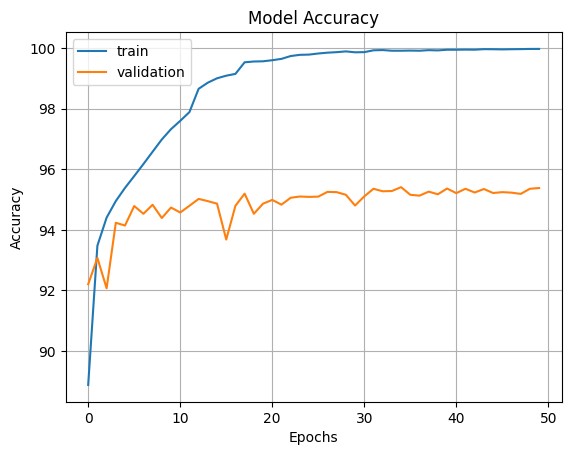

In [12]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

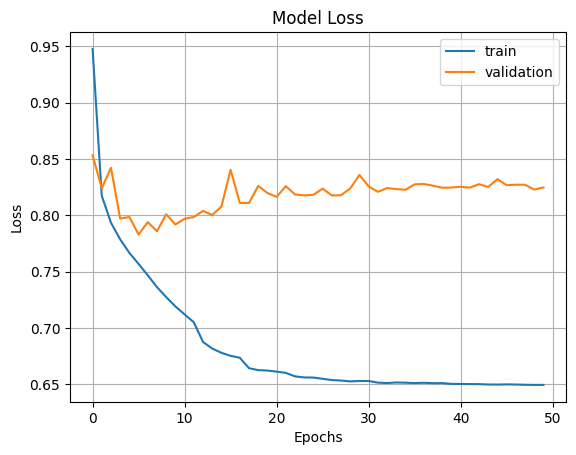

In [13]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [15]:
test = MyTestSet("./eql1/query_eql1.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=31)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./eql1/checkpoint_model_eql1.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [22]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

real_label = pd.read_csv("./eql1/queryy_eql1.csv", index_col=0)
file = open("./eql1/label_encoder_eql1.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)

ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype"])
ari = adjusted_rand_score(real_label_2, pred_label_2)
print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.962, ARI = 0.934
